# Hello world!

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')


In [7]:
print(pd.read_csv(r"raw/IndovestDKG_FULL.csv").head().info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subject       5 non-null      object
 1   subject_type  5 non-null      object
 2   relation      5 non-null      object
 3   object        5 non-null      object
 4   object_type   5 non-null      object
 5   date          5 non-null      object
dtypes: object(6)
memory usage: 372.0+ bytes
None


In [3]:
full = pd.read_csv(r"raw/IndovestDKG_FULL.csv")
force_drop = pd.read_csv(r"raw/IndovestDKG_FORCEDROP.csv")

# Data Inspection

In [15]:
class IndovestDKGAnalyzer:
    """
    Comprehensive analyzer for IndovestDKG dataset
    Provides initial dataset understanding and quality assessment
    """
    
    def __init__(self, dataset_path):
        """
        Initialize analyzer with dataset path
        
        Args:
            dataset_path (str): Path to the IndovestDKG_FULL.csv file
        """
        self.dataset_path = dataset_path
        self.df = None
        self.analysis_results = {}
        
    def load_dataset(self):
        """Load and prepare dataset for analysis"""
        try:
            self.df = pd.read_csv(self.dataset_path)
            print(f"Dataset loaded successfully: {self.df.shape[0]} rows, {self.df.shape[1]} columns")
            return True
        except Exception as e:
            print(f"Error loading dataset: {str(e)}")
            return False
    
    def basic_dataset_inspection(self):
        """
        Perform basic dataset inspection
        Returns basic statistics about the dataset structure
        """
        print("="*60)
        print("BASIC DATASET INSPECTION")
        print("="*60)
        
        # Total quadruplets
        total_quadruplets = len(self.df)
        print(f"Total Quadruplets: {total_quadruplets:,}")
        
        # Unique counts
        unique_entities = set(self.df['subject'].unique()) | set(self.df['object'].unique())
        unique_relations = self.df['relation'].nunique()
        unique_timestamps = self.df['date'].nunique()
        
        print(f"Unique Entities: {len(unique_entities):,}")
        print(f"Unique Relations: {unique_relations:,}")
        print(f"Unique Timestamps: {unique_timestamps:,}")
        
        # Time range coverage
        try:
            self.df['date_parsed'] = pd.to_datetime(self.df['date'])
            min_date = self.df['date_parsed'].min()
            max_date = self.df['date_parsed'].max()
            date_range = (max_date - min_date).days
            
            print(f"Time Range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")
            print(f"Total Days Covered: {date_range:,} days")
        except Exception as e:
            print(f"Error parsing dates: {str(e)}")
            min_date, max_date, date_range = None, None, None
        
        # Format validation
        print(f"\nDataset Schema:")
        print(f"Columns: {list(self.df.columns)}")
        print(f"Data Types:")
        for col in self.df.columns:
            print(f"  {col}: {self.df[col].dtype}")
        
        # Store results
        self.analysis_results['basic_inspection'] = {
            'total_quadruplets': total_quadruplets,
            'unique_entities': len(unique_entities),
            'unique_relations': unique_relations,
            'unique_timestamps': unique_timestamps,
            'min_date': min_date,
            'max_date': max_date,
            'date_range_days': date_range,
            'columns': list(self.df.columns)
        }
        
        return self.analysis_results['basic_inspection']
    
    def quality_assessment(self):
        """
        Perform data quality assessment
        Checks for missing values, duplicates, and consistency issues
        """
        print("\n" + "="*60)
        print("DATA QUALITY ASSESSMENT")
        print("="*60)
        
        # Missing values analysis
        print("Missing Values Analysis:")
        missing_analysis = {}
        for col in self.df.columns:
            missing_count = self.df[col].isnull().sum()
            missing_pct = (missing_count / len(self.df)) * 100
            print(f"  {col}: {missing_count} ({missing_pct:.2f}%)")
            missing_analysis[col] = {'count': missing_count, 'percentage': missing_pct}
        
        # Malformed entries check
        print(f"\nMalformed Entries Check:")
        malformed_analysis = {}
        
        # Check for empty strings
        for col in ['subject', 'relation', 'object']:
            empty_strings = self.df[col].str.strip().eq('').sum()
            print(f"  {col} empty strings: {empty_strings}")
            malformed_analysis[f'{col}_empty'] = empty_strings
        
        # Check date format consistency
        try:
            date_parsing_errors = 0
            for idx, date_val in enumerate(self.df['date']):
                try:
                    pd.to_datetime(date_val)
                except:
                    date_parsing_errors += 1
            print(f"  Date parsing errors: {date_parsing_errors}")
            malformed_analysis['date_parsing_errors'] = date_parsing_errors
        except Exception as e:
            print(f"  Date validation error: {str(e)}")
        
        # Duplicate quadruplets
        # Consider (subject, relation, object, date) as key for duplicates
        duplicate_keys = ['subject', 'relation', 'object', 'date']
        duplicates = self.df.duplicated(subset=duplicate_keys).sum()
        duplicate_pct = (duplicates / len(self.df)) * 100
        print(f"\nDuplicate Quadruplets: {duplicates} ({duplicate_pct:.2f}%)")
        
        # Temporal consistency check
        print(f"\nTemporal Consistency:")
        if 'date_parsed' in self.df.columns:
                # Check for future dates
            current_date = datetime.now()
            future_dates = (self.df['date_parsed'] > current_date).sum()
            print(f"  Future dates: {future_dates}")
            
            # Check for very old dates (before 2000)
            old_dates = (self.df['date_parsed'] < datetime(2000, 1, 1)).sum()
            print(f"  Dates before 2000: {old_dates}")
        else:
            future_dates = 0
            old_dates = 0
        
        # Entity/relation naming consistency
        print(f"\nNaming Consistency Analysis:")
        
        # Check for entities with different cases
        subjects_lower = self.df['subject'].str.lower().nunique()
        subjects_original = self.df['subject'].nunique()
        objects_lower = self.df['object'].str.lower().nunique()
        objects_original = self.df['object'].nunique()
        
        print(f"  Subjects - Original: {subjects_original}, Lowercase: {subjects_lower}")
        print(f"  Objects - Original: {objects_original}, Lowercase: {objects_lower}")
        print(f"  Potential case inconsistencies - Subjects: {subjects_original - subjects_lower}")
        print(f"  Potential case inconsistencies - Objects: {objects_original - objects_lower}")
        
        # Relations consistency
        relations_lower = self.df['relation'].str.lower().nunique()
        relations_original = self.df['relation'].nunique()
        print(f"  Relations - Original: {relations_original}, Lowercase: {relations_lower}")
        print(f"  Potential case inconsistencies - Relations: {relations_original - relations_lower}")
        
        # Store results
        self.analysis_results['quality_assessment'] = {
            'missing_values': missing_analysis,
            'malformed_entries': malformed_analysis,
            'duplicates': duplicates,
            'duplicate_percentage': duplicate_pct,
            'future_dates': future_dates,
            'old_dates': old_dates,
            'naming_inconsistencies': {
                'subjects': subjects_original - subjects_lower,
                'objects': objects_original - objects_lower,
                'relations': relations_original - relations_lower
            }
        }
        
        return self.analysis_results['quality_assessment']
    
    def distribution_analysis(self):
        """
        Analyze distributions of entities, relations, and temporal patterns
        """
        print("\n" + "="*60)
        print("DISTRIBUTION ANALYSIS")
        print("="*60)
        
        # Entity frequency distribution
        print("Entity Frequency Distribution:")
        
        # Combine subjects and objects for entity analysis
        entity_counts = {}
        
        # Count subject occurrences
        subject_counts = self.df['subject'].value_counts()
        for entity, count in subject_counts.items():
            entity_counts[entity] = entity_counts.get(entity, 0) + count
        
        # Count object occurrences
        object_counts = self.df['object'].value_counts()
        for entity, count in object_counts.items():
            entity_counts[entity] = entity_counts.get(entity, 0) + count
        
        # Convert to sorted series
        entity_freq = pd.Series(entity_counts).sort_values(ascending=False)
        
        print(f"  Top 10 Most Frequent Entities:")
        for i, (entity, count) in enumerate(entity_freq.head(10).items(), 1):
            print(f"    {i:2d}. {entity}: {count} occurrences")
        
        print(f"  Entity Frequency Statistics:")
        print(f"    Mean: {entity_freq.mean():.2f}")
        print(f"    Median: {entity_freq.median():.2f}")
        print(f"    Std: {entity_freq.std():.2f}")
        print(f"    Min: {entity_freq.min()}")
        print(f"    Max: {entity_freq.max()}")
        
        # Relation frequency distribution
        print(f"\nRelation Frequency Distribution:")
        relation_freq = self.df['relation'].value_counts()
        
        print(f"  Top 10 Most Frequent Relations:")
        for i, (relation, count) in enumerate(relation_freq.head(10).items(), 1):
            print(f"    {i:2d}. {relation}: {count} occurrences")
        
        print(f"  Relation Frequency Statistics:")
        print(f"    Mean: {relation_freq.mean():.2f}")
        print(f"    Median: {relation_freq.median():.2f}")
        print(f"    Std: {relation_freq.std():.2f}")
        print(f"    Min: {relation_freq.min()}")
        print(f"    Max: {relation_freq.max()}")
        
        # Temporal distribution analysis
        if 'date_parsed' in self.df.columns:
            print(f"\nTemporal Distribution Analysis:")
            
            # Daily patterns
            self.df['date_only'] = self.df['date_parsed'].dt.date
            daily_counts = self.df['date_only'].value_counts().sort_index()
            
            print(f"  Daily Distribution:")
            print(f"    Total unique days: {len(daily_counts)}")
            print(f"    Average quadruplets per day: {daily_counts.mean():.2f}")
            print(f"    Max quadruplets in a day: {daily_counts.max()}")
            print(f"    Min quadruplets in a day: {daily_counts.min()}")
            
            # Monthly patterns
            self.df['year_month'] = self.df['date_parsed'].dt.to_period('M')
            monthly_counts = self.df['year_month'].value_counts().sort_index()
            
            print(f"  Monthly Distribution:")
            print(f"    Total unique months: {len(monthly_counts)}")
            print(f"    Average quadruplets per month: {monthly_counts.mean():.2f}")
            print(f"    Max quadruplets in a month: {monthly_counts.max()}")
            print(f"    Min quadruplets in a month: {monthly_counts.min()}")
            
            # Yearly patterns
            self.df['year'] = self.df['date_parsed'].dt.year
            yearly_counts = self.df['year'].value_counts().sort_index()
            
            print(f"  Yearly Distribution:")
            for year, count in yearly_counts.items():
                print(f"    {year}: {count} quadruplets")
        else:
            daily_counts = pd.Series(dtype=int)
            monthly_counts = pd.Series(dtype=int)
            yearly_counts = pd.Series(dtype=int)
        
        # Entity type distribution (if available)
        if 'subject_type' in self.df.columns and 'object_type' in self.df.columns:
            print(f"\nEntity Type Distribution:")
            
            subject_types = self.df['subject_type'].value_counts()
            object_types = self.df['object_type'].value_counts()
            
            print(f"  Subject Types:")
            for entity_type, count in subject_types.items():
                print(f"    {entity_type}: {count}")
            
            print(f"  Object Types:")
            for entity_type, count in object_types.items():
                print(f"    {entity_type}: {count}")
        
        # Store results
        self.analysis_results['distribution_analysis'] = {
            'entity_frequency': {
                'top_10': entity_freq.head(10).to_dict(),
                'statistics': {
                    'mean': entity_freq.mean(),
                    'median': entity_freq.median(),
                    'std': entity_freq.std(),
                    'min': entity_freq.min(),
                    'max': entity_freq.max()
                }
            },
            'relation_frequency': {
                'top_10': relation_freq.head(10).to_dict(),
                'statistics': {
                    'mean': relation_freq.mean(),
                    'median': relation_freq.median(),
                    'std': relation_freq.std(),
                    'min': relation_freq.min(),
                    'max': relation_freq.max()
                }
            },
            'temporal_distribution': {
                'daily_stats': {
                    'unique_days': len(daily_counts),
                    'avg_per_day': daily_counts.mean() if len(daily_counts) > 0 else 0,
                    'max_per_day': daily_counts.max() if len(daily_counts) > 0 else 0,
                    'min_per_day': daily_counts.min() if len(daily_counts) > 0 else 0
                },
                'yearly_distribution': yearly_counts.to_dict() if len(yearly_counts) > 0 else {}
            }
        }
        
        return self.analysis_results['distribution_analysis']
    
    def generate_summary_report(self):
        """
        Generate a comprehensive summary report
        """
        print("\n" + "="*60)
        print("INDOVESTDKG DATASET - SUMMARY REPORT")
        print("="*60)
        
        basic = self.analysis_results.get('basic_inspection', {})
        quality = self.analysis_results.get('quality_assessment', {})
        distribution = self.analysis_results.get('distribution_analysis', {})
        
        print(f"Dataset Overview:")
        print(f"  Total Quadruplets: {basic.get('total_quadruplets', 'N/A'):,}")
        print(f"  Unique Entities: {basic.get('unique_entities', 'N/A'):,}")
        print(f"  Unique Relations: {basic.get('unique_relations', 'N/A'):,}")
        print(f"  Time Coverage: {basic.get('date_range_days', 'N/A')} days")
        
        print(f"\nData Quality Summary:")
        print(f"  Duplicate Quadruplets: {quality.get('duplicates', 'N/A')}")
        print(f"  Missing Values: {sum([v['count'] for v in quality.get('missing_values', {}).values()])}")
        print(f"  Naming Inconsistencies: {sum(quality.get('naming_inconsistencies', {}).values())}")
        
        print(f"\nDistribution Summary:")
        entity_stats = distribution.get('entity_frequency', {}).get('statistics', {})
        relation_stats = distribution.get('relation_frequency', {}).get('statistics', {})
        
        print(f"  Entity Frequency - Mean: {entity_stats.get('mean', 0):.2f}")
        print(f"  Relation Frequency - Mean: {relation_stats.get('mean', 0):.2f}")
        
        temporal_stats = distribution.get('temporal_distribution', {}).get('daily_stats', {})
        print(f"  Avg Quadruplets per Day: {temporal_stats.get('avg_per_day', 0):.2f}")
        
        print("\n" + "="*60)
        print("ANALYSIS COMPLETE")
        print("="*60)
        
        return self.analysis_results
    
    def run_full_analysis(self):
        """
        Run complete dataset analysis pipeline
        """
        if not self.load_dataset():
            return None
        
        # Run all analysis components
        self.basic_dataset_inspection()
        self.quality_assessment()
        self.distribution_analysis()
        
        # Generate summary
        return self.generate_summary_report()



In [22]:
pd.read_csv(r"raw/IndovestDKG_FULL.csv")

,subject,subject_type,relation,object,object_type,date
0,pt manulife aset manajemen indonesia,PERUSAHAAN,Mengumumkan,diversifikasi investasi,KONSEP,2025-03-07 21:18:00
1,ihsg,INDIKATOR_EKONOMI,Menghasilkan,pertumbuhan tahunan tertinggi,INDIKATOR_EKONOMI,2025-03-07 21:18:00
2,strategi diversifikasi,KONSEP,Meningkatkan,peluang return,KONSEP,2025-03-07 21:18:00
3,investor,ORANG,Mengendalikan,berbagai jenis aset investasi,KONSEP,2025-03-07 21:18:00
4,dimas ardinugraha,ORANG,Mempengaruhi,strategi diversifikasi,KONSEP,2025-03-07 21:18:00
...,...,...,...,...,...,...
69331,mahkamah konstitusi,LEMBAGA,Mengadakan,sidang,EVENT,2017-09-26 19:37:00
69332,investasi keuangan haji,KONSEP,BerdampakPositif,jemaah haji,ORANG,2017-09-26 19:37:00
69333,kementerian agama,PEMERINTAHAN,Mengendalikan,pengelolaan keuangan haji,KONSEP,2017-09-26 19:37:00
69334,kementerian agama,PEMERINTAHAN,Mengaitkan,perbankan syariah,PRODUK,2017-09-26 19:37:00


In [23]:
# Initialize analyzer
analyzer = IndovestDKGAnalyzer(r"raw/IndovestDKG_FULL.csv")

# Run complete analysis
results = analyzer.run_full_analysis()

# Access specific results
basic_info = analyzer.analysis_results['basic_inspection']
quality_info = analyzer.analysis_results['quality_assessment']
distribution_info = analyzer.analysis_results['distribution_analysis']

Dataset loaded successfully: 69336 rows, 6 columns
BASIC DATASET INSPECTION
Total Quadruplets: 69,336
Unique Entities: 53,522
Unique Relations: 3,314
Unique Timestamps: 7,732
Time Range: 2017-09-26 to 2025-03-07
Total Days Covered: 2,719 days

Dataset Schema:
Columns: ['subject', 'subject_type', 'relation', 'object', 'object_type', 'date', 'date_parsed']
Data Types:
  subject: object
  subject_type: object
  relation: object
  object: object
  object_type: object
  date: object
  date_parsed: datetime64[ns]

DATA QUALITY ASSESSMENT
Missing Values Analysis:
  subject: 0 (0.00%)
  subject_type: 0 (0.00%)
  relation: 0 (0.00%)
  object: 2 (0.00%)
  object_type: 2 (0.00%)
  date: 0 (0.00%)
  date_parsed: 0 (0.00%)

Malformed Entries Check:
  subject empty strings: 0
  relation empty strings: 0
  object empty strings: 0
  Date parsing errors: 0

Duplicate Quadruplets: 50 (0.07%)

Temporal Consistency:
  Future dates: 0
  Dates before 2000: 0

Naming Consistency Analysis:
  Subjects - Origin

# Sparsity Analysis

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

class SparsityAnalyzer:
    """
    Comprehensive sparsity analysis for IndovestDKG dataset
    Analyzes temporal, entity-relation, and structural sparsity patterns
    """
    
    def __init__(self, df):
        """
        Initialize with preprocessed dataframe that has date_parsed column
        
        Args:
            df (pd.DataFrame): DataFrame with columns ['subject', 'relation', 'object', 'date_parsed']
        """
        self.df = df.copy()
        self.sparsity_results = {}
        
    def overall_sparsity_metrics(self):
        """
        Calculate overall sparsity metrics for the knowledge graph
        """
        print("="*60)
        print("OVERALL SPARSITY METRICS")
        print("="*60)
        
        # Basic counts
        total_quadruplets = len(self.df)
        unique_entities = set(self.df['subject'].unique()) | set(self.df['object'].unique())
        unique_relations = self.df['relation'].nunique()
        
        # Entity-Relation Matrix Density
        # Maximum possible quadruplets = entities * relations * entities * timestamps
        max_possible_subject_relation_pairs = len(unique_entities) * unique_relations
        max_possible_quadruplets = max_possible_subject_relation_pairs * len(unique_entities)
        
        # Calculate sparsity ratios
        entity_relation_density = total_quadruplets / max_possible_quadruplets
        
        print(f"Entity-Relation Matrix Analysis:")
        print(f"  Total Entities: {len(unique_entities):,}")
        print(f"  Total Relations: {unique_relations:,}")
        print(f"  Observed Quadruplets: {total_quadruplets:,}")
        print(f"  Maximum Possible Quadruplets: {max_possible_quadruplets:,}")
        print(f"  Overall Density: {entity_relation_density:.2e} ({entity_relation_density*100:.6f}%)")
        
        # Temporal Coverage Sparsity
        date_range = (self.df['date_parsed'].max() - self.df['date_parsed'].min()).days + 1
        unique_days = self.df['date_parsed'].dt.date.nunique()
        temporal_coverage = unique_days / date_range
        
        print(f"\nTemporal Coverage Analysis:")
        print(f"  Total Days in Range: {date_range:,}")
        print(f"  Days with Data: {unique_days:,}")
        print(f"  Temporal Coverage: {temporal_coverage:.3f} ({temporal_coverage*100:.1f}%)")
        print(f"  Empty Days: {date_range - unique_days:,}")
        
        # Entity-specific sparsity
        entity_appearances = Counter()
        for entity in self.df['subject']:
            entity_appearances[entity] += 1
        for entity in self.df['object']:
            entity_appearances[entity] += 1
            
        # Calculate entity participation rate
        total_possible_appearances = len(unique_entities) * total_quadruplets * 2  # subject or object
        actual_appearances = sum(entity_appearances.values())
        entity_participation_rate = actual_appearances / total_possible_appearances
        
        print(f"\nEntity Participation Analysis:")
        print(f"  Entities appearing only once: {sum(1 for count in entity_appearances.values() if count == 1):,}")
        print(f"  Entities appearing >10 times: {sum(1 for count in entity_appearances.values() if count > 10):,}")
        print(f"  Entities appearing >100 times: {sum(1 for count in entity_appearances.values() if count > 100):,}")
        
        # Store results
        self.sparsity_results['overall_metrics'] = {
            'total_quadruplets': total_quadruplets,
            'unique_entities': len(unique_entities),
            'unique_relations': unique_relations,
            'entity_relation_density': entity_relation_density,
            'temporal_coverage': temporal_coverage,
            'empty_days': date_range - unique_days,
            'entity_appearances': dict(entity_appearances),
            'singleton_entities': sum(1 for count in entity_appearances.values() if count == 1),
            'high_frequency_entities': sum(1 for count in entity_appearances.values() if count > 100)
        }
        
        return self.sparsity_results['overall_metrics']
    
    def temporal_sparsity_patterns(self):
        """
        Analyze temporal sparsity patterns including gaps and clustering
        """
        print("\n" + "="*60)
        print("TEMPORAL SPARSITY PATTERNS")
        print("="*60)
        
        # Daily analysis
        self.df['date_only'] = self.df['date_parsed'].dt.date
        daily_counts = self.df['date_only'].value_counts().sort_index()
        
        # Generate complete date range
        min_date = daily_counts.index.min()
        max_date = daily_counts.index.max()
        complete_date_range = pd.date_range(start=min_date, end=max_date, freq='D').date
        
        # Identify gaps
        missing_dates = set(complete_date_range) - set(daily_counts.index)
        
        print(f"Time Gap Analysis:")
        print(f"  Total days in range: {len(complete_date_range):,}")
        print(f"  Days with data: {len(daily_counts):,}")
        print(f"  Missing days: {len(missing_dates):,}")
        print(f"  Gap percentage: {(len(missing_dates)/len(complete_date_range))*100:.1f}%")
        
        # Analyze gap lengths
        missing_dates_sorted = sorted(missing_dates)
        gap_lengths = []
        if missing_dates_sorted:
            current_gap = 1
            for i in range(1, len(missing_dates_sorted)):
                if (missing_dates_sorted[i] - missing_dates_sorted[i-1]).days == 1:
                    current_gap += 1
                else:
                    gap_lengths.append(current_gap)
                    current_gap = 1
            gap_lengths.append(current_gap)
        
        if gap_lengths:
            print(f"  Average gap length: {np.mean(gap_lengths):.1f} days")
            print(f"  Longest gap: {max(gap_lengths)} days")
            print(f"  Number of gap periods: {len(gap_lengths)}")
        
        # Event clustering analysis
        print(f"\nEvent Clustering Analysis:")
        print(f"  Days with 1 event: {sum(1 for count in daily_counts if count == 1)}")
        print(f"  Days with 2-10 events: {sum(1 for count in daily_counts if 2 <= count <= 10)}")
        print(f"  Days with 11-50 events: {sum(1 for count in daily_counts if 11 <= count <= 50)}")
        print(f"  Days with >50 events: {sum(1 for count in daily_counts if count > 50)}")
        print(f"  Peak day events: {daily_counts.max()}")
        
        # Seasonal patterns
        self.df['month'] = self.df['date_parsed'].dt.month
        self.df['year'] = self.df['date_parsed'].dt.year
        self.df['day_of_week'] = self.df['date_parsed'].dt.dayofweek
        
        monthly_patterns = self.df['month'].value_counts().sort_index()
        yearly_patterns = self.df['year'].value_counts().sort_index()
        weekly_patterns = self.df['day_of_week'].value_counts().sort_index()
        
        print(f"\nSeasonal/Periodic Patterns:")
        print(f"  Most active month: {monthly_patterns.idxmax()} ({monthly_patterns.max()} events)")
        print(f"  Least active month: {monthly_patterns.idxmin()} ({monthly_patterns.min()} events)")
        print(f"  Monthly variation coefficient: {(monthly_patterns.std()/monthly_patterns.mean()):.2f}")
        
        print(f"  Most active day of week: {weekly_patterns.idxmax()} ({weekly_patterns.max()} events)")
        print(f"  Weekend vs Weekday ratio: {(weekly_patterns[5] + weekly_patterns[6]) / weekly_patterns[:5].sum():.2f}")
        
        # Store results
        self.sparsity_results['temporal_patterns'] = {
            'missing_days': len(missing_dates),
            'gap_percentage': (len(missing_dates)/len(complete_date_range))*100,
            'average_gap_length': np.mean(gap_lengths) if gap_lengths else 0,
            'max_gap_length': max(gap_lengths) if gap_lengths else 0,
            'daily_distribution': {
                'single_event_days': sum(1 for count in daily_counts if count == 1),
                'low_event_days': sum(1 for count in daily_counts if 2 <= count <= 10),
                'medium_event_days': sum(1 for count in daily_counts if 11 <= count <= 50),
                'high_event_days': sum(1 for count in daily_counts if count > 50)
            },
            'seasonal_patterns': {
                'monthly_variation_coeff': monthly_patterns.std()/monthly_patterns.mean(),
                'weekend_weekday_ratio': (weekly_patterns[5] + weekly_patterns[6]) / weekly_patterns[:5].sum()
            }
        }
        
        return self.sparsity_results['temporal_patterns']
    
    def entity_connectivity_analysis(self):
        """
        Analyze entity connectivity patterns and identify hubs vs isolated entities
        """
        print("\n" + "="*60)
        print("ENTITY CONNECTIVITY ANALYSIS")
        print("="*60)
        
        # Build entity connectivity graph
        entity_connections = defaultdict(set)
        entity_degree = defaultdict(int)
        
        # Count connections for each entity
        for _, row in self.df.iterrows():
            subject = row['subject']
            obj = row['object']
            relation = row['relation']
            
            # Add bidirectional connections
            entity_connections[subject].add((obj, relation))
            entity_connections[obj].add((subject, relation))
            
            entity_degree[subject] += 1
            entity_degree[obj] += 1
        
        # Analyze degree distribution
        degrees = list(entity_degree.values())
        degree_stats = {
            'mean': np.mean(degrees),
            'median': np.median(degrees),
            'std': np.std(degrees),
            'min': min(degrees),
            'max': max(degrees)
        }
        
        print(f"Entity Degree Distribution:")
        print(f"  Mean degree: {degree_stats['mean']:.2f}")
        print(f"  Median degree: {degree_stats['median']:.2f}")
        print(f"  Std deviation: {degree_stats['std']:.2f}")
        print(f"  Min degree: {degree_stats['min']}")
        print(f"  Max degree: {degree_stats['max']}")
        
        # Identify hubs and isolated entities
        degree_percentiles = np.percentile(degrees, [10, 25, 50, 75, 90, 95, 99])
        
        print(f"\nDegree Percentiles:")
        for i, perc in enumerate([10, 25, 50, 75, 90, 95, 99]):
            print(f"  {perc}th percentile: {degree_percentiles[i]:.1f}")
        
        # Hub entities (top 1% by degree)
        hub_threshold = degree_percentiles[-1]  # 99th percentile
        hub_entities = [(entity, degree) for entity, degree in entity_degree.items() if degree >= hub_threshold]
        hub_entities.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\nHub Entities (>={hub_threshold:.0f} connections):")
        for i, (entity, degree) in enumerate(hub_entities[:10], 1):
            print(f"  {i:2d}. {entity}: {degree} connections")
        
        # Isolated entities (bottom 10%)
        isolation_threshold = degree_percentiles[0]  # 10th percentile
        isolated_entities = [(entity, degree) for entity, degree in entity_degree.items() if degree <= isolation_threshold]
        
        print(f"\nIsolated Entities (<={isolation_threshold:.0f} connections): {len(isolated_entities)}")
        
        # Relation diversity per entity
        print(f"\nRelation Type Diversity Analysis:")
        entity_relation_diversity = {}
        
        for entity in entity_connections:
            relations_used = set()
            for _, relation in entity_connections[entity]:
                relations_used.add(relation)
            entity_relation_diversity[entity] = len(relations_used)
        
        diversity_values = list(entity_relation_diversity.values())
        diversity_stats = {
            'mean': np.mean(diversity_values),
            'median': np.median(diversity_values),
            'std': np.std(diversity_values),
            'min': min(diversity_values),
            'max': max(diversity_values)
        }
        
        print(f"  Mean relations per entity: {diversity_stats['mean']:.2f}")
        print(f"  Median relations per entity: {diversity_stats['median']:.2f}")
        print(f"  Max relations per entity: {diversity_stats['max']}")
        
        # Entities with highest relation diversity
        high_diversity_entities = sorted(entity_relation_diversity.items(), key=lambda x: x[1], reverse=True)[:10]
        print(f"\nEntities with Highest Relation Diversity:")
        for i, (entity, diversity) in enumerate(high_diversity_entities, 1):
            print(f"  {i:2d}. {entity}: {diversity} different relations")
        
        # Calculate graph connectivity metrics
        connected_components = self._find_connected_components(entity_connections)
        largest_component_size = max(len(component) for component in connected_components)
        
        print(f"\nGraph Connectivity:")
        print(f"  Number of connected components: {len(connected_components)}")
        print(f"  Largest component size: {largest_component_size} entities")
        print(f"  Graph connectivity ratio: {largest_component_size / len(entity_connections):.3f}")
        
        # Store results
        self.sparsity_results['entity_connectivity'] = {
            'degree_stats': degree_stats,
            'hub_entities': hub_entities[:20],  # Top 20 hubs
            'isolated_entities_count': len(isolated_entities),
            'relation_diversity_stats': diversity_stats,
            'high_diversity_entities': high_diversity_entities[:10],
            'connected_components': len(connected_components),
            'largest_component_size': largest_component_size,
            'connectivity_ratio': largest_component_size / len(entity_connections)
        }
        
        return self.sparsity_results['entity_connectivity']
    
    def _find_connected_components(self, graph):
        """
        Find connected components in the entity graph using DFS
        """
        visited = set()
        components = []
        
        def dfs(node, component):
            if node in visited:
                return
            visited.add(node)
            component.append(node)
            for neighbor, _ in graph[node]:
                dfs(neighbor, component)
        
        for node in graph:
            if node not in visited:
                component = []
                dfs(node, component)
                components.append(component)
        
        return components
    
    def generate_sparsity_summary(self):
        """
        Generate comprehensive sparsity analysis summary
        """
        print("\n" + "="*60)
        print("SPARSITY ANALYSIS SUMMARY")
        print("="*60)
        
        overall = self.sparsity_results.get('overall_metrics', {})
        temporal = self.sparsity_results.get('temporal_patterns', {})
        connectivity = self.sparsity_results.get('entity_connectivity', {})
        
        print(f"Overall Sparsity Assessment:")
        print(f"  Entity-Relation Density: {overall.get('entity_relation_density', 0):.2e}")
        print(f"  Temporal Coverage: {overall.get('temporal_coverage', 0)*100:.1f}%")
        print(f"  Singleton Entities: {overall.get('singleton_entities', 0):,}")
        
        print(f"\nTemporal Sparsity Issues:")
        print(f"  Missing Days: {temporal.get('gap_percentage', 0):.1f}%")
        print(f"  Average Gap Length: {temporal.get('average_gap_length', 0):.1f} days")
        print(f"  High Event Days: {temporal.get('daily_distribution', {}).get('high_event_days', 0)}")
        
        print(f"\nConnectivity Issues:")
        print(f"  Mean Entity Degree: {connectivity.get('degree_stats', {}).get('mean', 0):.2f}")
        print(f"  Isolated Entities: {connectivity.get('isolated_entities_count', 0):,}")
        print(f"  Graph Connectivity: {connectivity.get('connectivity_ratio', 0):.3f}")
        
        # Sparsity severity assessment
        density = overall.get('entity_relation_density', 0)
        temporal_cov = overall.get('temporal_coverage', 0)
        connectivity_ratio = connectivity.get('connectivity_ratio', 0)
        
        print(f"\nSparsity Severity Assessment:")
        if density < 1e-6:
            print(f"  CRITICAL: Extremely sparse entity-relation matrix")
        elif density < 1e-4:
            print(f"  HIGH: Very sparse entity-relation matrix")
        else:
            print(f"  MODERATE: Moderately sparse entity-relation matrix")
        
        if temporal_cov < 0.5:
            print(f"  HIGH: Significant temporal gaps")
        elif temporal_cov < 0.8:
            print(f"  MODERATE: Some temporal gaps")
        else:
            print(f"  LOW: Good temporal coverage")
        
        if connectivity_ratio < 0.7:
            print(f"  HIGH: Fragmented entity connectivity")
        elif connectivity_ratio < 0.9:
            print(f"  MODERATE: Some disconnected entities")
        else:
            print(f"  LOW: Well-connected entity graph")
        
        return self.sparsity_results
    
    def run_full_sparsity_analysis(self):
        """
        Run complete sparsity analysis pipeline
        """
        print("Starting Comprehensive Sparsity Analysis...")
        
        # Run all analysis components
        self.overall_sparsity_metrics()
        self.temporal_sparsity_patterns()
        self.entity_connectivity_analysis()
        
        # Generate summary
        return self.generate_sparsity_summary()



In [27]:
# After running the basic analyzer
sparsity_analyzer = SparsityAnalyzer(analyzer.df)
sparsity_results = sparsity_analyzer.run_full_sparsity_analysis()

# Access specific results
overall_sparsity = sparsity_analyzer.sparsity_results['overall_metrics']
temporal_sparsity = sparsity_analyzer.sparsity_results['temporal_patterns']
connectivity_sparsity = sparsity_analyzer.sparsity_results['entity_connectivity']

Starting Comprehensive Sparsity Analysis...
OVERALL SPARSITY METRICS
Entity-Relation Matrix Analysis:
  Total Entities: 53,522
  Total Relations: 3,314
  Observed Quadruplets: 69,336
  Maximum Possible Quadruplets: 9,493,299,259,976
  Overall Density: 7.30e-09 (0.000001%)

Temporal Coverage Analysis:
  Total Days in Range: 2,720
  Days with Data: 2,134
  Temporal Coverage: 0.785 (78.5%)
  Empty Days: 586

Entity Participation Analysis:
  Entities appearing only once: 39,608
  Entities appearing >10 times: 1,370
  Entities appearing >100 times: 84

TEMPORAL SPARSITY PATTERNS
Time Gap Analysis:
  Total days in range: 2,720
  Days with data: 2,134
  Missing days: 586
  Gap percentage: 21.5%
  Average gap length: 1.7 days
  Longest gap: 8 days
  Number of gap periods: 350

Event Clustering Analysis:
  Days with 1 event: 1
  Days with 2-10 events: 363
  Days with 11-50 events: 1371
  Days with >50 events: 399
  Peak day events: 312

Seasonal/Periodic Patterns:
  Most active month: 1 (7698 e

# Deep Inspection for cleaning `IndovestDKG`

In [29]:
from difflib import SequenceMatcher

In [34]:
class PreprocessingInspector:
    """
    Deep inspection tool for IndovestDKG dataset preprocessing needs
    Identifies specific entity, relation, and quality issues
    """
    
    def __init__(self, df):
        """
        Initialize with dataset DataFrame
        
        Args:
            df (pd.DataFrame): Dataset with columns ['subject', 'relation', 'object', etc.]
        """
        self.df = df.copy()
        self.inspection_results = {}
        
    def inspect_entity_inconsistencies(self):
        """
        Deep inspection of entity naming inconsistencies
        """
        print("="*60)
        print("ENTITY INCONSISTENCY INSPECTION")
        print("="*60)
        
        # Combine all entities (filter out NaN values)
        subjects = [s for s in self.df['subject'].unique() if pd.notna(s) and str(s).strip()]
        objects = [o for o in self.df['object'].unique() if pd.notna(o) and str(o).strip()]
        all_entities = list(set(subjects + objects))
        
        # Find case variations
        entity_groups = defaultdict(list)
        for entity in all_entities:
            if entity and isinstance(entity, str):
                key = entity.lower().strip()
                if key:  # Only add non-empty keys
                    entity_groups[key].append(entity)
        
        # Identify problematic groups
        case_variations = {}
        for key, variations in entity_groups.items():
            if len(variations) > 1:
                case_variations[key] = variations
        
        print(f"Entity Case Variation Analysis:")
        print(f"  Total unique entities: {len(all_entities):,}")
        print(f"  Entities with case variations: {len(case_variations):,}")
        print(f"  Potential duplicates: {sum(len(v)-1 for v in case_variations.values()):,}")
        
        # Show examples of case variations
        print(f"\nTop 10 Case Variation Examples:")
        sorted_variations = sorted(case_variations.items(), key=lambda x: len(x[1]), reverse=True)
        for i, (key, variations) in enumerate(sorted_variations[:10], 1):
            print(f"  {i:2d}. '{key}' has {len(variations)} variations:")
            for var in variations[:5]:  # Show max 5 variations
                print(f"      - '{var}'")
            if len(variations) > 5:
                print(f"      ... and {len(variations)-5} more")
        
        # Find similar entities (fuzzy matching)
        print(f"\nFuzzy Similarity Analysis:")
        similar_pairs = []
        # Filter and convert to string, then sort
        entities_filtered = [str(e) for e in all_entities if e and isinstance(e, str) and len(str(e).strip()) > 0]
        entities_sorted = sorted(entities_filtered, key=len, reverse=True)
        
        for i, entity1 in enumerate(entities_sorted[:1000]):  # Limit for performance
            for entity2 in entities_sorted[i+1:1000]:
                # Skip if same after case normalization
                if entity1.lower().strip() == entity2.lower().strip():
                    continue
                
                # Calculate similarity
                similarity = SequenceMatcher(None, entity1.lower(), entity2.lower()).ratio()
                if similarity > 0.8:  # High similarity threshold
                    similar_pairs.append((entity1, entity2, similarity))
        
        # Sort by similarity
        similar_pairs.sort(key=lambda x: x[2], reverse=True)
        
        print(f"  Found {len(similar_pairs)} highly similar entity pairs (>80% similarity)")
        print(f"  Top 15 Similar Entity Pairs:")
        for i, (e1, e2, sim) in enumerate(similar_pairs[:15], 1):
            print(f"    {i:2d}. '{e1}' <-> '{e2}' (similarity: {sim:.3f})")
        
        # Store results
        self.inspection_results['entity_inconsistencies'] = {
            'case_variations': case_variations,
            'similar_pairs': similar_pairs[:50],  # Store top 50
            'total_variations': len(case_variations),
            'potential_duplicates': sum(len(v)-1 for v in case_variations.values())
        }
        
        return self.inspection_results['entity_inconsistencies']
    
    def inspect_object_quality_issues(self):
        """
        Inspect object entities for sentence-like patterns and quality issues
        """
        print("\n" + "="*60)
        print("OBJECT ENTITY QUALITY INSPECTION")
        print("="*60)
        
        objects = self.df['object'].dropna().unique()
        
        # Analyze object length distribution
        object_lengths = [len(str(obj)) for obj in objects]
        length_stats = {
            'mean': np.mean(object_lengths),
            'median': np.median(object_lengths),
            'std': np.std(object_lengths),
            'min': min(object_lengths),
            'max': max(object_lengths)
        }
        
        print(f"Object Length Analysis:")
        print(f"  Mean length: {length_stats['mean']:.1f} characters")
        print(f"  Median length: {length_stats['median']:.1f} characters")
        print(f"  Max length: {length_stats['max']} characters")
        print(f"  Std deviation: {length_stats['std']:.1f}")
        
        # Categorize objects by length
        short_objects = [obj for obj in objects if len(str(obj)) <= 20]
        medium_objects = [obj for obj in objects if 21 <= len(str(obj)) <= 50]
        long_objects = [obj for obj in objects if len(str(obj)) > 50]
        
        print(f"\nObject Length Categories:")
        print(f"  Short (≤20 chars): {len(short_objects):,} ({len(short_objects)/len(objects)*100:.1f}%)")
        print(f"  Medium (21-50 chars): {len(medium_objects):,} ({len(medium_objects)/len(objects)*100:.1f}%)")
        print(f"  Long (>50 chars): {len(long_objects):,} ({len(long_objects)/len(objects)*100:.1f}%)")
        
        # Identify sentence-like objects
        sentence_patterns = []
        for obj in objects:
            obj_str = str(obj).lower()
            # Check for sentence indicators
            word_count = len(obj_str.split())
            has_articles = any(word in obj_str for word in ['yang', 'dari', 'untuk', 'dengan', 'dalam', 'pada', 'oleh'])
            has_punctuation = any(char in obj_str for char in [',', '.', ':', ';', '!', '?'])
            
            if word_count > 5 or has_articles or has_punctuation:
                sentence_patterns.append((obj, word_count, has_articles, has_punctuation))
        
        sentence_patterns.sort(key=lambda x: x[1], reverse=True)  # Sort by word count
        
        print(f"\nSentence-like Objects Analysis:")
        print(f"  Objects with sentence patterns: {len(sentence_patterns):,} ({len(sentence_patterns)/len(objects)*100:.1f}%)")
        print(f"  Top 15 Longest/Most Complex Objects:")
        for i, (obj, word_count, has_articles, has_punct) in enumerate(sentence_patterns[:15], 1):
            indicators = []
            if has_articles:
                indicators.append("articles")
            if has_punct:
                indicators.append("punctuation")
            indicator_str = f" ({', '.join(indicators)})" if indicators else ""
            print(f"    {i:2d}. '{obj}' ({word_count} words){indicator_str}")
        
        # Check for common problematic patterns
        print(f"\nProblematic Pattern Analysis:")
        
        # Objects starting with numbers
        numeric_start = [obj for obj in objects if str(obj).strip() and str(obj).strip()[0].isdigit()]
        print(f"  Objects starting with numbers: {len(numeric_start):,}")
        
        # Objects with special characters
        special_chars = [obj for obj in objects if any(char in str(obj) for char in ['%', '$', '@', '#', '&', '*'])]
        print(f"  Objects with special characters: {len(special_chars):,}")
        
        # Very short objects (potential artifacts)
        very_short = [obj for obj in objects if len(str(obj).strip()) <= 2]
        print(f"  Very short objects (≤2 chars): {len(very_short):,}")
        
        # Store results
        self.inspection_results['object_quality'] = {
            'length_stats': length_stats,
            'length_categories': {
                'short': len(short_objects),
                'medium': len(medium_objects),
                'long': len(long_objects)
            },
            'sentence_patterns': sentence_patterns[:100],  # Store top 100
            'problematic_patterns': {
                'numeric_start': numeric_start[:20],
                'special_chars': special_chars[:20],
                'very_short': very_short
            }
        }
        
        return self.inspection_results['object_quality']
    
    def inspect_relation_inconsistencies(self):
        """
        Inspect relation inconsistencies and redundancies
        """
        print("\n" + "="*60)
        print("RELATION INCONSISTENCY INSPECTION")
        print("="*60)
        
        relations = self.df['relation'].dropna().unique()
        relation_counts = self.df['relation'].value_counts()
        
        print(f"Relation Distribution Analysis:")
        print(f"  Total unique relations: {len(relations):,}")
        print(f"  Relations used only once: {sum(1 for count in relation_counts if count == 1):,}")
        print(f"  Relations used >100 times: {sum(1 for count in relation_counts if count > 100):,}")
        
        # Find case variations in relations
        relation_groups = defaultdict(list)
        for relation in relations:
            if pd.notna(relation) and str(relation).strip():
                key = str(relation).lower().strip()
                if key:
                    relation_groups[key].append(str(relation))
        
        relation_case_variations = {k: v for k, v in relation_groups.items() if len(v) > 1}
        
        print(f"\nRelation Case Variations:")
        print(f"  Relations with case variations: {len(relation_case_variations):,}")
        for key, variations in list(relation_case_variations.items())[:10]:
            print(f"    '{key}': {variations}")
        
        # Find similar relations
        similar_relations = []
        # Filter out NaN values and convert to string
        relations_filtered = [str(r) for r in relations if pd.notna(r) and str(r).strip()]
        
        for i, rel1 in enumerate(relations_filtered):
            for rel2 in relations_filtered[i+1:]:
                similarity = SequenceMatcher(None, rel1.lower(), rel2.lower()).ratio()
                if similarity > 0.7:  # Lower threshold for relations
                    similar_relations.append((rel1, rel2, similarity))
        
        similar_relations.sort(key=lambda x: x[2], reverse=True)
        
        print(f"\nSimilar Relations Analysis:")
        print(f"  Similar relation pairs found: {len(similar_relations)}")
        print(f"  Top 15 Similar Relation Pairs:")
        for i, (r1, r2, sim) in enumerate(similar_relations[:15], 1):
            print(f"    {i:2d}. '{r1}' <-> '{r2}' (similarity: {sim:.3f})")
        
        # Analyze relation semantic groups
        relations_filtered = [str(r) for r in relations if pd.notna(r)]
        semantic_groups = {
            'announcing': [r for r in relations_filtered if any(word in r.lower() for word in ['mengumumkan', 'announce'])],
            'influencing': [r for r in relations_filtered if any(word in r.lower() for word in ['mempengaruhi', 'influence', 'dampak'])],
            'controlling': [r for r in relations_filtered if any(word in r.lower() for word in ['mengendalikan', 'control', 'kontrol'])],
            'investing': [r for r in relations_filtered if any(word in r.lower() for word in ['investasi', 'invest', 'berinvestasi'])],
            'increasing': [r for r in relations_filtered if any(word in r.lower() for word in ['meningkatkan', 'increase', 'naik'])],
            'decreasing': [r for r in relations_filtered if any(word in r.lower() for word in ['menurunkan', 'decrease', 'turun'])]
        }
        
        print(f"\nSemantic Relation Groups:")
        for group_name, group_relations in semantic_groups.items():
            if group_relations:
                print(f"  {group_name.capitalize()}: {len(group_relations)} relations")
                for rel in group_relations[:5]:
                    print(f"    - {rel}")
                if len(group_relations) > 5:
                    print(f"    ... and {len(group_relations)-5} more")
        
        # Store results
        self.inspection_results['relation_inconsistencies'] = {
            'total_relations': len(relations),
            'case_variations': relation_case_variations,
            'similar_pairs': similar_relations[:50],
            'semantic_groups': semantic_groups,
            'singleton_relations': sum(1 for count in relation_counts if count == 1)
        }
        
        return self.inspection_results['relation_inconsistencies']
    
    def inspect_entity_types_consistency(self):
        """
        Inspect entity type assignments for consistency
        """
        print("\n" + "="*60)
        print("ENTITY TYPE CONSISTENCY INSPECTION")
        print("="*60)
        
        # Analyze subject types
        subject_types = self.df['subject_type'].value_counts()
        object_types = self.df['object_type'].value_counts()
        
        print(f"Entity Type Distribution:")
        print(f"  Subject types: {len(subject_types)} different types")
        print(f"  Object types: {len(object_types)} different types")
        
        # Find entities with inconsistent type assignments
        entity_type_mapping = defaultdict(set)
        
        # Collect type assignments for subjects
        for _, row in self.df.iterrows():
            if pd.notna(row['subject']) and pd.notna(row['subject_type']):
                entity_type_mapping[row['subject']].add(row['subject_type'])
        
        # Collect type assignments for objects
        for _, row in self.df.iterrows():
            if pd.notna(row['object']) and pd.notna(row['object_type']):
                entity_type_mapping[row['object']].add(row['object_type'])
        
        # Find entities with multiple type assignments
        inconsistent_entities = {entity: types for entity, types in entity_type_mapping.items() if len(types) > 1}
        
        print(f"\nEntity Type Inconsistencies:")
        print(f"  Entities with multiple type assignments: {len(inconsistent_entities):,}")
        
        if inconsistent_entities:
            print(f"  Top 15 Inconsistent Entity Types:")
            sorted_inconsistent = sorted(inconsistent_entities.items(), key=lambda x: len(x[1]), reverse=True)
            for i, (entity, types) in enumerate(sorted_inconsistent[:15], 1):
                print(f"    {i:2d}. '{entity}': {list(types)}")
        
        # Check for potential type standardization issues
        all_types = set(subject_types.index) | set(object_types.index)
        type_variations = defaultdict(list)
        
        for type_name in all_types:
            normalized = type_name.lower().strip()
            type_variations[normalized].append(type_name)
        
        type_case_issues = {k: v for k, v in type_variations.items() if len(v) > 1}
        
        print(f"\nEntity Type Case/Format Issues:")
        print(f"  Types with formatting variations: {len(type_case_issues)}")
        for normalized, variations in type_case_issues.items():
            print(f"    '{normalized}': {variations}")
        
        # Store results
        self.inspection_results['entity_type_consistency'] = {
            'inconsistent_entities': dict(list(inconsistent_entities.items())[:100]),  # Store top 100
            'type_case_issues': type_case_issues,
            'total_inconsistent': len(inconsistent_entities)
        }
        
        return self.inspection_results['entity_type_consistency']
    
    def generate_preprocessing_recommendations(self):
        """
        Generate specific preprocessing recommendations based on inspection results
        """
        print("\n" + "="*60)
        print("PREPROCESSING RECOMMENDATIONS")
        print("="*60)
        
        recommendations = []
        
        # Entity inconsistency recommendations
        entity_issues = self.inspection_results.get('entity_inconsistencies', {})
        if entity_issues.get('total_variations', 0) > 0:
            recommendations.append({
                'category': 'Entity Normalization',
                'priority': 'HIGH',
                'issue': f"{entity_issues['total_variations']} entities with case variations",
                'solution': 'Implement case normalization and fuzzy matching consolidation',
                'expected_impact': f"Reduce {entity_issues['potential_duplicates']} duplicate entities"
            })
        
        # Object quality recommendations
        object_issues = self.inspection_results.get('object_quality', {})
        sentence_patterns = len(object_issues.get('sentence_patterns', []))
        if sentence_patterns > 0:
            recommendations.append({
                'category': 'Object Entity Cleaning',
                'priority': 'HIGH',
                'issue': f"{sentence_patterns} sentence-like objects detected",
                'solution': 'Implement object entity extraction/normalization',
                'expected_impact': 'Improve entity quality and reduce noise'
            })
        
        # Relation inconsistency recommendations
        relation_issues = self.inspection_results.get('relation_inconsistencies', {})
        if relation_issues.get('singleton_relations', 0) > 1000:
            recommendations.append({
                'category': 'Relation Consolidation',
                'priority': 'MEDIUM',
                'issue': f"{relation_issues['singleton_relations']} relations used only once",
                'solution': 'Group similar relations and filter low-frequency relations',
                'expected_impact': 'Reduce relation vocabulary and improve learning'
            })
        
        # Entity type recommendations
        type_issues = self.inspection_results.get('entity_type_consistency', {})
        if type_issues.get('total_inconsistent', 0) > 0:
            recommendations.append({
                'category': 'Entity Type Standardization',
                'priority': 'MEDIUM',
                'issue': f"{type_issues['total_inconsistent']} entities with inconsistent types",
                'solution': 'Implement majority voting for entity type assignment',
                'expected_impact': 'Improve entity type consistency'
            })
        
        print(f"Generated {len(recommendations)} preprocessing recommendations:")
        for i, rec in enumerate(recommendations, 1):
            print(f"\n{i}. {rec['category']} ({rec['priority']} Priority)")
            print(f"   Issue: {rec['issue']}")
            print(f"   Solution: {rec['solution']}")
            print(f"   Expected Impact: {rec['expected_impact']}")
        
        self.inspection_results['recommendations'] = recommendations
        return recommendations
    
    def run_full_inspection(self):
        """
        Run complete preprocessing inspection pipeline
        """
        print("Starting Comprehensive Preprocessing Inspection...")
        
        # Run all inspection components
        self.inspect_entity_inconsistencies()
        self.inspect_object_quality_issues()
        self.inspect_relation_inconsistencies()
        self.inspect_entity_types_consistency()
        
        # Generate recommendations
        recommendations = self.generate_preprocessing_recommendations()
        
        print("\n" + "="*60)
        print("PREPROCESSING INSPECTION COMPLETE")
        print("="*60)
        
        return self.inspection_results

In [35]:
df = pd.read_csv(r"raw/IndovestDKG_FULL.csv")
df.head()

,subject,subject_type,relation,object,object_type,date
0,pt manulife aset manajemen indonesia,PERUSAHAAN,Mengumumkan,diversifikasi investasi,KONSEP,2025-03-07 21:18:00
1,ihsg,INDIKATOR_EKONOMI,Menghasilkan,pertumbuhan tahunan tertinggi,INDIKATOR_EKONOMI,2025-03-07 21:18:00
2,strategi diversifikasi,KONSEP,Meningkatkan,peluang return,KONSEP,2025-03-07 21:18:00
3,investor,ORANG,Mengendalikan,berbagai jenis aset investasi,KONSEP,2025-03-07 21:18:00
4,dimas ardinugraha,ORANG,Mempengaruhi,strategi diversifikasi,KONSEP,2025-03-07 21:18:00


In [36]:
# After loading your dataset
inspector = PreprocessingInspector(df)
inspection_results = inspector.run_full_inspection()

# Access specific results
entity_issues = inspector.inspection_results['entity_inconsistencies']
object_issues = inspector.inspection_results['object_quality']
relation_issues = inspector.inspection_results['relation_inconsistencies']
recommendations = inspector.inspection_results['recommendations']

Starting Comprehensive Preprocessing Inspection...
ENTITY INCONSISTENCY INSPECTION
Entity Case Variation Analysis:
  Total unique entities: 53,521
  Entities with case variations: 166
  Potential duplicates: 169

Top 10 Case Variation Examples:
   1. 'indonesia' has 3 variations:
      - 'Indonesia'
      - 'indonesia'
      - ' indonesia'
   2. 'pemerintah' has 3 variations:
      - 'pemerintah'
      - ' pemerintah'
      - 'Pemerintah'
   3. 'swi' has 3 variations:
      - 'swi'
      - 'swI'
      - 'SWI'
   4. 'thomas djiwandono' has 2 variations:
      - 'Thomas Djiwandono'
      - 'thomas djiwandono'
   5. 'pulau jawa' has 2 variations:
      - 'pulau jawa'
      - 'pulau Jawa'
   6. 'kementerian perhubungan' has 2 variations:
      - 'kementerian perhubungan'
      - 'Kementerian Perhubungan'
   7. 'ai' has 2 variations:
      - 'AI'
      - 'ai'
   8. 'jokowi' has 2 variations:
      - 'jokowi'
      - 'Jokowi'
   9. 'ori018' has 2 variations:
      - 'ORI018'
      - 'ori018'

SO MANY PROBLEM WITH `IndovestDKG`!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## Deep Pattern Analysis

In [37]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

In [38]:
class DeepPatternAnalyzer:
    """
    Deep pattern analysis to identify specific cleaning strategies
    for IndovestDKG dataset issues
    """
    
    def __init__(self, df):
        """
        Initialize with dataset DataFrame
        """
        self.df = df.copy()
        self.patterns = {}
        
    def analyze_entity_patterns(self):
        """
        Analyze specific patterns in entities that need cleaning
        """
        print("="*60)
        print("DEEP ENTITY PATTERN ANALYSIS")
        print("="*60)
        
        # Combine all entities
        subjects = [s for s in self.df['subject'].unique() if pd.notna(s) and str(s).strip()]
        objects = [o for o in self.df['object'].unique() if pd.notna(o) and str(o).strip()]
        all_entities = list(set(subjects + objects))
        
        # Pattern 1: Long descriptive entities (likely titles/positions)
        long_entities = []
        for entity in all_entities:
            entity_str = str(entity)
            if len(entity_str) > 50:
                word_count = len(entity_str.split())
                long_entities.append((entity, len(entity_str), word_count))
        
        long_entities.sort(key=lambda x: x[1], reverse=True)
        
        print(f"Long Descriptive Entities Analysis:")
        print(f"  Entities >50 characters: {len(long_entities):,}")
        print(f"  Top 10 Longest Entities:")
        for i, (entity, char_count, word_count) in enumerate(long_entities[:10], 1):
            print(f"    {i:2d}. ({char_count} chars, {word_count} words) '{entity[:100]}{'...' if len(entity) > 100 else ''}'")
        
        # Pattern 2: Title/Position patterns
        title_patterns = {
            'menteri': [],
            'kepala': [],
            'direktur': [],
            'presiden': [],
            'wakil': [],
            'ketua': [],
            'sekretaris': [],
            'gubernur': [],
            'bupati': [],
            'walikota': []
        }
        
        for entity in all_entities:
            entity_lower = str(entity).lower()
            for pattern in title_patterns.keys():
                if pattern in entity_lower and len(entity_lower) > 20:
                    title_patterns[pattern].append(entity)
        
        print(f"\nTitle/Position Pattern Analysis:")
        for pattern, entities in title_patterns.items():
            if entities:
                print(f"  '{pattern}' pattern: {len(entities)} entities")
                for entity in entities[:3]:
                    print(f"    - '{entity[:80]}{'...' if len(entity) > 80 else ''}'")
                if len(entities) > 3:
                    print(f"    ... and {len(entities)-3} more")
        
        # Pattern 3: Organization/Institution patterns
        org_patterns = {
            'pt ': [],
            'cv ': [],
            'badan ': [],
            'kementerian ': [],
            'lembaga ': [],
            'dinas ': [],
            'kantor ': [],
            'bank ': [],
            'universitas ': [],
            'institut ': []
        }
        
        for entity in all_entities:
            entity_lower = str(entity).lower()
            for pattern in org_patterns.keys():
                if entity_lower.startswith(pattern) and len(entity_lower) > 15:
                    org_patterns[pattern].append(entity)
        
        print(f"\nOrganization Pattern Analysis:")
        for pattern, entities in org_patterns.items():
            if entities:
                print(f"  '{pattern}' prefix: {len(entities)} entities")
                for entity in entities[:2]:
                    print(f"    - '{entity[:60]}{'...' if len(entity) > 60 else ''}'")
                if len(entities) > 2:
                    print(f"    ... and {len(entities)-2} more")
        
        # Pattern 4: Monetary/Numeric patterns
        numeric_entities = []
        monetary_patterns = ['rp ', 'dollar', 'triliun', 'miliar', 'juta', '%', 'persen']
        
        for entity in all_entities:
            entity_lower = str(entity).lower()
            if any(pattern in entity_lower for pattern in monetary_patterns):
                numeric_entities.append(entity)
        
        print(f"\nMonetary/Numeric Entity Patterns:")
        print(f"  Entities with monetary/numeric content: {len(numeric_entities)}")
        for entity in numeric_entities[:10]:
            print(f"    - '{entity}'")
        if len(numeric_entities) > 10:
            print(f"    ... and {len(numeric_entities)-10} more")
        
        # Store patterns
        self.patterns['entities'] = {
            'long_entities': long_entities[:100],
            'title_patterns': title_patterns,
            'org_patterns': org_patterns,
            'numeric_entities': numeric_entities[:50]
        }
        
        return self.patterns['entities']
    
    def analyze_object_sentence_patterns(self):
        """
        Analyze sentence-like objects to identify extraction patterns
        """
        print("\n" + "="*60)
        print("OBJECT SENTENCE PATTERN ANALYSIS")
        print("="*60)
        
        objects = [str(o) for o in self.df['object'].unique() if pd.notna(o) and str(o).strip()]
        
        # Identify sentence-like objects
        sentence_objects = []
        for obj in objects:
            word_count = len(obj.split())
            has_articles = any(word in obj.lower() for word in ['yang', 'dari', 'untuk', 'dengan', 'dalam', 'pada', 'oleh', 'sebesar', 'senilai'])
            has_punctuation = any(char in obj for char in [',', '.', ':', ';'])
            
            if word_count > 5 or has_articles or has_punctuation:
                sentence_objects.append((obj, word_count, has_articles, has_punctuation))
        
        sentence_objects.sort(key=lambda x: x[1], reverse=True)
        
        print(f"Sentence Object Analysis:")
        print(f"  Total sentence-like objects: {len(sentence_objects):,}")
        
        # Pattern 1: Investment amount descriptions
        investment_patterns = []
        investment_keywords = ['investasi', 'senilai', 'sebesar', 'mencapai', 'miliar', 'triliun', 'dollar', 'rp']
        
        for obj, word_count, has_articles, has_punct in sentence_objects:
            if any(keyword in obj.lower() for keyword in investment_keywords):
                investment_patterns.append(obj)
        
        print(f"\nInvestment Amount Patterns:")
        print(f"  Objects describing investment amounts: {len(investment_patterns)}")
        for obj in investment_patterns[:5]:
            print(f"    - '{obj[:100]}{'...' if len(obj) > 100 else ''}'")
        
        # Pattern 2: Policy/Regulation descriptions
        policy_patterns = []
        policy_keywords = ['undang-undang', 'peraturan', 'pp nomor', 'pasal', 'ayat', 'tentang']
        
        for obj, word_count, has_articles, has_punct in sentence_objects:
            if any(keyword in obj.lower() for keyword in policy_keywords):
                policy_patterns.append(obj)
        
        print(f"\nPolicy/Regulation Patterns:")
        print(f"  Objects describing policies/regulations: {len(policy_patterns)}")
        for obj in policy_patterns[:5]:
            print(f"    - '{obj[:100]}{'...' if len(obj) > 100 else ''}'")
        
        # Pattern 3: Process/Activity descriptions
        process_patterns = []
        process_keywords = ['proses', 'kegiatan', 'program', 'proyek', 'pembangunan', 'pengembangan', 'pelaksanaan']
        
        for obj, word_count, has_articles, has_punct in sentence_objects:
            if any(keyword in obj.lower() for keyword in process_keywords):
                process_patterns.append(obj)
        
        print(f"\nProcess/Activity Patterns:")
        print(f"  Objects describing processes/activities: {len(process_patterns)}")
        for obj in process_patterns[:5]:
            print(f"    - '{obj[:100]}{'...' if len(obj) > 100 else ''}'")
        
        # Pattern 4: Complex multi-entity descriptions
        multi_entity_patterns = []
        for obj, word_count, has_articles, has_punct in sentence_objects:
            # Check for multiple entities in one object (commas, "dan", "atau")
            entity_separators = obj.count(',') + obj.lower().count(' dan ') + obj.lower().count(' atau ')
            if entity_separators >= 2:
                multi_entity_patterns.append((obj, entity_separators))
        
        multi_entity_patterns.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\nMulti-Entity Object Patterns:")
        print(f"  Objects containing multiple entities: {len(multi_entity_patterns)}")
        for obj, separator_count in multi_entity_patterns[:5]:
            print(f"    - ({separator_count} separators) '{obj[:100]}{'...' if len(obj) > 100 else ''}'")
        
        # Store patterns
        self.patterns['objects'] = {
            'sentence_objects': sentence_objects[:200],
            'investment_patterns': investment_patterns[:50],
            'policy_patterns': policy_patterns[:50],
            'process_patterns': process_patterns[:50],
            'multi_entity_patterns': multi_entity_patterns[:50]
        }
        
        return self.patterns['objects']
    
    def analyze_relation_consolidation_opportunities(self):
        """
        Analyze relations for consolidation opportunities
        """
        print("\n" + "="*60)
        print("RELATION CONSOLIDATION ANALYSIS")
        print("="*60)
        
        relations = [str(r) for r in self.df['relation'].unique() if pd.notna(r) and str(r).strip()]
        relation_counts = self.df['relation'].value_counts()
        
        # Group relations by semantic similarity
        semantic_groups = {
            'mengumumkan': [],
            'mempengaruhi': [],
            'berinvestasi': [],
            'bekerja sama': [],
            'mengendalikan': [],
            'memiliki': [],
            'menghasilkan': [],
            'meningkatkan': [],
            'menurunkan': [],
            'berpartisipasi': [],
            'beroperasi': [],
            'menjadi': [],
            'adalah': [],
            'dikelola': [],
            'terkait': []
        }
        
        for relation in relations:
            rel_lower = relation.lower().strip()
            
            # Check for semantic matches
            if 'mengumumkan' in rel_lower or 'umumkan' in rel_lower:
                semantic_groups['mengumumkan'].append(relation)
            elif any(word in rel_lower for word in ['pengaruh', 'dampak', 'efek', 'impact']):
                semantic_groups['mempengaruhi'].append(relation)
            elif any(word in rel_lower for word in ['investasi', 'invest', 'modal']):
                semantic_groups['berinvestasi'].append(relation)
            elif any(word in rel_lower for word in ['kerja sama', 'kerjasama', 'kolaborasi', 'partnership']):
                semantic_groups['bekerja sama'].append(relation)
            elif any(word in rel_lower for word in ['kendali', 'kontrol', 'mengatur', 'manage']):
                semantic_groups['mengendalikan'].append(relation)
            elif 'memiliki' in rel_lower or 'milik' in rel_lower or 'punya' in rel_lower:
                semantic_groups['memiliki'].append(relation)
            elif 'hasilkan' in rel_lower or 'produksi' in rel_lower or 'produce' in rel_lower:
                semantic_groups['menghasilkan'].append(relation)
            elif any(word in rel_lower for word in ['tingkat', 'naik', 'increase', 'boost']):
                semantic_groups['meningkatkan'].append(relation)
            elif any(word in rel_lower for word in ['turun', 'decrease', 'reduce', 'kurang']):
                semantic_groups['menurunkan'].append(relation)
            elif 'partisipasi' in rel_lower or 'ikut' in rel_lower or 'participate' in rel_lower:
                semantic_groups['berpartisipasi'].append(relation)
            elif 'operasi' in rel_lower or 'beroperasi' in rel_lower or 'operate' in rel_lower:
                semantic_groups['beroperasi'].append(relation)
            elif 'menjadi' in rel_lower or 'become' in rel_lower:
                semantic_groups['menjadi'].append(relation)
            elif rel_lower in ['adalah', 'is', 'merupakan', 'ialah']:
                semantic_groups['adalah'].append(relation)
            elif 'kelola' in rel_lower or 'manage' in rel_lower:
                semantic_groups['dikelola'].append(relation)
            elif any(word in rel_lower for word in ['terkait', 'berhubungan', 'related', 'connect']):
                semantic_groups['terkait'].append(relation)
        
        print(f"Semantic Relation Grouping:")
        total_groupable = 0
        for group_name, group_relations in semantic_groups.items():
            if len(group_relations) > 1:
                total_groupable += len(group_relations)
                usage_counts = [relation_counts.get(rel, 0) for rel in group_relations]
                total_usage = sum(usage_counts)
                print(f"  {group_name}: {len(group_relations)} variations ({total_usage:,} total usage)")
                
                # Show top variations by usage
                rel_usage_pairs = [(rel, relation_counts.get(rel, 0)) for rel in group_relations]
                rel_usage_pairs.sort(key=lambda x: x[1], reverse=True)
                
                for rel, count in rel_usage_pairs[:5]:
                    print(f"    - '{rel}' ({count:,} times)")
                if len(rel_usage_pairs) > 5:
                    print(f"    ... and {len(rel_usage_pairs)-5} more")
        
        print(f"\nConsolidation Opportunity:")
        print(f"  Total relations that can be grouped: {total_groupable}")
        print(f"  Potential reduction: {total_groupable - len(semantic_groups)} relations")
        
        # Identify singleton relations for potential removal
        singleton_relations = [rel for rel, count in relation_counts.items() if count == 1]
        low_usage_relations = [rel for rel, count in relation_counts.items() if count <= 3]
        
        print(f"\nLow Usage Relations:")
        print(f"  Relations used only once: {len(singleton_relations):,}")
        print(f"  Relations used ≤3 times: {len(low_usage_relations):,}")
        print(f"  Example singleton relations:")
        for rel in singleton_relations[:10]:
            print(f"    - '{rel}'")
        
        # Store patterns
        self.patterns['relations'] = {
            'semantic_groups': semantic_groups,
            'singleton_relations': singleton_relations[:100],
            'low_usage_relations': low_usage_relations[:200],
            'total_groupable': total_groupable
        }
        
        return self.patterns['relations']
    
    def generate_cleaning_strategy(self):
        """
        Generate comprehensive cleaning strategy based on pattern analysis
        """
        print("\n" + "="*60)
        print("COMPREHENSIVE CLEANING STRATEGY")
        print("="*60)
        
        strategy = {
            'phase_1_entity_normalization': {
                'priority': 'CRITICAL',
                'targets': [
                    'Long descriptive entities (title extraction)',
                    'Organization name standardization', 
                    'Monetary value entities (convert to concepts)',
                    'Fuzzy matching consolidation'
                ],
                'method': 'LLM-assisted + rule-based',
                'expected_reduction': '40-60% entity count reduction'
            },
            
            'phase_2_object_extraction': {
                'priority': 'CRITICAL', 
                'targets': [
                    'Investment amount sentences → amounts + entities',
                    'Policy descriptions → policy names',
                    'Multi-entity objects → individual entities',
                    'Process descriptions → core concepts'
                ],
                'method': 'LLM-assisted entity extraction',
                'expected_reduction': '70% sentence-like object reduction'
            },
            
            'phase_3_relation_consolidation': {
                'priority': 'HIGH',
                'targets': [
                    'Semantic grouping (15 core groups identified)',
                    'Remove singleton relations (1,938 relations)',
                    'Standardize case variations',
                    'Merge similar relations'
                ],
                'method': 'Rule-based + manual verification',
                'expected_reduction': '80% relation vocabulary reduction'
            },
            
            'phase_4_type_standardization': {
                'priority': 'MEDIUM',
                'targets': [
                    'Majority voting for entity types',
                    'Fix case variations in types',
                    'Remove invalid type assignments'
                ],
                'method': 'Rule-based + validation',
                'expected_reduction': 'Consistent typing for all entities'
            }
        }
        
        print("Recommended Cleaning Phases:")
        for phase, details in strategy.items():
            print(f"\n{phase.upper()} ({details['priority']} Priority):")
            print(f"  Method: {details['method']}")
            print(f"  Expected Impact: {details['expected_reduction']}")
            print(f"  Targets:")
            for target in details['targets']:
                print(f"    - {target}")
        
        # Calculate projected improvements
        entity_issues = self.patterns.get('entities', {})
        object_issues = self.patterns.get('objects', {})
        relation_issues = self.patterns.get('relations', {})
        
        current_stats = {
            'entities': len(set(list(self.df['subject'].unique()) + list(self.df['object'].unique()))),
            'relations': self.df['relation'].nunique(),
            'sentence_objects': len(object_issues.get('sentence_objects', [])),
            'long_entities': len(entity_issues.get('long_entities', []))
        }
        
        projected_stats = {
            'entities': int(current_stats['entities'] * 0.5),  # 50% reduction
            'relations': int(current_stats['relations'] * 0.2),  # 80% reduction  
            'sentence_objects': int(current_stats['sentence_objects'] * 0.3),  # 70% reduction
            'long_entities': int(current_stats['long_entities'] * 0.1)  # 90% reduction
        }
        
        print(f"\nProjected Cleaning Impact:")
        print(f"  Entities: {current_stats['entities']:,} → {projected_stats['entities']:,} ({((current_stats['entities'] - projected_stats['entities'])/current_stats['entities']*100):.1f}% reduction)")
        print(f"  Relations: {current_stats['relations']:,} → {projected_stats['relations']:,} ({((current_stats['relations'] - projected_stats['relations'])/current_stats['relations']*100):.1f}% reduction)")
        print(f"  Sentence Objects: {current_stats['sentence_objects']:,} → {projected_stats['sentence_objects']:,} ({((current_stats['sentence_objects'] - projected_stats['sentence_objects'])/current_stats['sentence_objects']*100):.1f}% reduction)")
        print(f"  Long Entities: {current_stats['long_entities']:,} → {projected_stats['long_entities']:,} ({((current_stats['long_entities'] - projected_stats['long_entities'])/current_stats['long_entities']*100):.1f}% reduction)")
        
        self.patterns['strategy'] = strategy
        self.patterns['projections'] = {
            'current': current_stats,
            'projected': projected_stats
        }
        
        return strategy
    
    def run_full_pattern_analysis(self):
        """
        Run complete pattern analysis pipeline
        """
        print("Starting Deep Pattern Analysis for Cleaning Strategy...")
        
        # Run all analysis components
        self.analyze_entity_patterns()
        self.analyze_object_sentence_patterns()
        self.analyze_relation_consolidation_opportunities()
        
        # Generate strategy
        strategy = self.generate_cleaning_strategy()
        
        print("\n" + "="*60)
        print("PATTERN ANALYSIS COMPLETE - READY FOR CLEANING")
        print("="*60)
        
        return self.patterns


In [39]:
# After basic inspection
pattern_analyzer = DeepPatternAnalyzer(df)
patterns = pattern_analyzer.run_full_pattern_analysis()

# Access patterns for cleaning strategy
entity_patterns = pattern_analyzer.patterns['entities']
object_patterns = pattern_analyzer.patterns['objects'] 
relation_patterns = pattern_analyzer.patterns['relations']
cleaning_strategy = pattern_analyzer.patterns['strategy']

Starting Deep Pattern Analysis for Cleaning Strategy...
DEEP ENTITY PATTERN ANALYSIS
Long Descriptive Entities Analysis:
  Entities >50 characters: 4,065
  Top 10 Longest Entities:
     1. (292 chars, 35 words) 'konstruksi kilang minyak, akselerasi energi terbarukan, pembangunan ibu kota nusantara (ikn), pengem...'
     2. (177 chars, 27 words) 'realisasi penanaman modal asing (pma) 3,3 miliar dollar as atau setara dengan rp 48,6 triliun dan re...'
     3. (168 chars, 22 words) 'persetujuan sebagai lembaga kliring dan penjaminan penyelesaian transaksi pasar fisik emas digital k...'
     4. (164 chars, 21 words) 'rancangan undang-undang (ruu) peraturan pemerintah (rpp) tentang pemberian izin usaha, kemudahan ber...'
     5. (160 chars, 21 words) 'potensi dan peluang investasi di bidang pertanian dan pangan, ekonomi digital, kesehatan publik, ken...'
     6. (160 chars, 22 words) 'nilai transaksi untuk investasi pada semester i/2022 turun 2 miliar dollar as secara tahunan (yoy) a...'
   

# LLM turun tangan hahaha

In [42]:
# !pip install openai

In [43]:
import pandas as pd
import numpy as np
import re
import os
from collections import Counter, defaultdict
from difflib import SequenceMatcher
import json
import asyncio
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# LLM Integration
from dotenv import load_dotenv
from openai import OpenAI


In [44]:
load_dotenv()

class ComprehensiveCleaner:
    """
    Comprehensive cleaning pipeline for IndovestDKG dataset
    Includes LLM-assisted cleaning for complex cases
    """
    
    def __init__(self, df, patterns_dict):
        """
        Initialize with dataset and pattern analysis results
        
        Args:
            df (pd.DataFrame): Original dataset
            patterns_dict (dict): Results from DeepPatternAnalyzer
        """
        self.df = df.copy()
        self.original_df = df.copy()
        self.patterns = patterns_dict
        self.client = OpenAI(api_key=os.getenv('API_KEY'))
        
        # Cleaning results tracking
        self.cleaning_log = {
            'entity_normalization': {},
            'object_extraction': {},
            'relation_consolidation': {},
            'type_standardization': {}
        }
        
        print(f"Initialized Comprehensive Cleaner")
        print(f"Original dataset: {len(self.df):,} rows")
        print(f"Original entities: {self.df['subject'].nunique() + self.df['object'].nunique():,}")
        print(f"Original relations: {self.df['relation'].nunique():,}")
    
    def llm_extract_entity_name(self, long_entity, batch_size=5):
        """
        Use LLM to extract proper entity name from long descriptive text
        """
        prompt = f"""Extract the core entity name from this long descriptive text. Return only the essential name, not the full description.

Rules:
1. For person titles: extract only the person's name (e.g., "Joko Widodo")
2. For organizations: extract core organization name (e.g., "Bank Indonesia")
3. For amounts/values: extract the concept (e.g., "investasi 500 juta" → "investasi")
4. For policies: extract policy name (e.g., "UU No 1 Tahun 2023" → "UU No 1 Tahun 2023")
5. If it's a sentence/description: extract the main subject

Examples:
Input: "menteri investasi dan hilirisasi/kepala badan koordinasi penanaman modal (bkpm) rosan p. roeslani"
Output: "rosan p. roeslani"

Input: "realisasi investasi sebesar 500 miliar rupiah"
Output: "investasi"

Input: "pt bank central asia tbk"
Output: "bank central asia"

Text to process: "{long_entity}"

Extract the core entity name:"""

        try:
            response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.1,
                max_tokens=50
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"LLM extraction error: {e}")
            # Fallback: simple rule-based extraction
            return self._fallback_entity_extraction(long_entity)
    
    def _fallback_entity_extraction(self, entity):
        """
        Fallback rule-based entity extraction
        """
        entity = str(entity).strip()
        
        # Person name extraction from titles
        if any(title in entity.lower() for title in ['menteri', 'direktur', 'presiden', 'gubernur', 'bupati']):
            # Extract person name (usually at the end)
            words = entity.split()
            if len(words) > 3:
                # Take last 2-3 words as likely person name
                return ' '.join(words[-2:]).lower()
        
        # Organization name extraction
        if entity.lower().startswith('pt '):
            # Remove pt prefix and clean
            name = entity[3:].strip()
            # Remove parenthetical content
            name = re.sub(r'\([^)]*\)', '', name).strip()
            # Take first few words
            words = name.split()
            return ' '.join(words[:3]).lower()
        
        # Monetary/numeric extraction
        if any(word in entity.lower() for word in ['rp', 'dollar', 'miliar', 'triliun', 'investasi']):
            if 'investasi' in entity.lower():
                return 'investasi'
            else:
                return 'nilai investasi'
        
        # Default: take first few words
        words = entity.split()
        if len(words) > 5:
            return ' '.join(words[:3]).lower()
        
        return entity.lower().strip()
    
    def phase1_entity_normalization(self):
        """
        Phase 1: Entity Normalization using LLM + rule-based approaches
        """
        print("\n" + "="*60)
        print("PHASE 1: ENTITY NORMALIZATION")
        print("="*60)
        
        # Get long entities from patterns
        long_entities = self.patterns.get('entities', {}).get('long_entities', [])
        entity_mapping = {}
        
        print(f"Processing {len(long_entities)} long entities...")
        
        # Process long entities in batches
        batch_size = 20
        for i in tqdm(range(0, min(200, len(long_entities)), batch_size), desc="Normalizing entities"):
            batch = long_entities[i:i+batch_size]
            
            for entity_info in batch:
                original_entity = entity_info[0]
                
                # Use LLM for very long/complex entities
                if len(original_entity) > 100:
                    normalized = self.llm_extract_entity_name(original_entity)
                else:
                    normalized = self._fallback_entity_extraction(original_entity)
                
                if normalized and normalized != original_entity.lower():
                    entity_mapping[original_entity] = normalized
        
        # Rule-based normalization for common patterns
        print("Applying rule-based normalizations...")
        
        # Get all entities
        all_entities = list(set(self.df['subject'].unique()) | set(self.df['object'].unique()))
        
        for entity in tqdm(all_entities, desc="Rule-based normalization"):
            if pd.isna(entity):
                continue
                
            entity_str = str(entity).strip()
            original_entity = entity_str
            
            # Skip if already mapped
            if entity_str in entity_mapping:
                continue
            
            # Organization standardization
            if entity_str.lower().startswith('pt '):
                # Clean PT names
                cleaned = entity_str[3:].strip()
                cleaned = re.sub(r'\(.*?\)', '', cleaned).strip()  # Remove parentheses
                cleaned = re.sub(r'\s+', ' ', cleaned)  # Normalize spaces
                if cleaned.lower() != entity_str.lower():
                    entity_mapping[entity_str] = cleaned.lower()
            
            # Title extraction for person entities
            elif any(title in entity_str.lower() for title in ['menteri', 'direktur', 'presiden', 'gubernur']):
                if len(entity_str) > 30:  # Only for long titles
                    words = entity_str.split()
                    if len(words) > 5:
                        # Extract likely person name (last 2-3 words)
                        person_name = ' '.join(words[-2:])
                        if person_name.lower() != entity_str.lower():
                            entity_mapping[entity_str] = person_name.lower()
            
            # Monetary/numeric entities → concepts
            elif any(word in entity_str.lower() for word in ['rp ', 'dollar', 'miliar', 'triliun']):
                if 'investasi' in entity_str.lower():
                    entity_mapping[entity_str] = 'investasi'
                elif 'pma' in entity_str.lower():
                    entity_mapping[entity_str] = 'investasi asing'
                elif 'pmdn' in entity_str.lower():
                    entity_mapping[entity_str] = 'investasi domestik'
                else:
                    entity_mapping[entity_str] = 'nilai investasi'
            
            # Case normalization
            elif entity_str != entity_str.lower():
                entity_mapping[entity_str] = entity_str.lower()
        
        # Apply entity mappings
        print(f"Applying {len(entity_mapping):,} entity mappings...")
        
        def apply_entity_mapping(entity):
            if pd.isna(entity):
                return entity
            return entity_mapping.get(str(entity), str(entity))
        
        self.df['subject'] = self.df['subject'].apply(apply_entity_mapping)
        self.df['object'] = self.df['object'].apply(apply_entity_mapping)
        
        # Log results
        unique_entities_after = len(set(self.df['subject'].unique()) | set(self.df['object'].unique()))
        original_entities = len(set(self.original_df['subject'].unique()) | set(self.original_df['object'].unique()))
        
        self.cleaning_log['entity_normalization'] = {
            'mappings_applied': len(entity_mapping),
            'entities_before': original_entities,
            'entities_after': unique_entities_after,
            'reduction_count': original_entities - unique_entities_after,
            'reduction_percentage': ((original_entities - unique_entities_after) / original_entities) * 100
        }
        
        print(f"Entity Normalization Complete:")
        print(f"  Entities before: {original_entities:,}")
        print(f"  Entities after: {unique_entities_after:,}")
        print(f"  Reduction: {original_entities - unique_entities_after:,} ({((original_entities - unique_entities_after) / original_entities) * 100:.1f}%)")
        
        return entity_mapping
    
    def llm_extract_entities_from_sentence(self, sentence_object):
        """
        Use LLM to extract proper entities from sentence-like objects
        """
        prompt = f"""Extract the main entities from this sentence-like object. Return a simple list of core entities, separated by commas.

Rules:
1. Extract only concrete entities (people, organizations, places, concepts)
2. Avoid descriptive phrases or full sentences
3. Return maximum 3 most important entities
4. Use simple, normalized names

Examples:
Input: "realisasi investasi sebesar 500 miliar dollar AS oleh PT Pertamina di Jakarta"
Output: "investasi, pt pertamina, jakarta"

Input: "kerjasama antara Bank Indonesia dengan Kementerian Keuangan untuk stabilitas ekonomi"
Output: "bank indonesia, kementerian keuangan, stabilitas ekonomi"

Text to process: "{sentence_object}"

Extract main entities:"""

        try:
            response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.1,
                max_tokens=100
            )
            entities_text = response.choices[0].message.content.strip()
            # Parse comma-separated entities
            entities = [e.strip().lower() for e in entities_text.split(',') if e.strip()]
            return entities[:3]  # Maximum 3 entities
        except Exception as e:
            print(f"LLM extraction error: {e}")
            return self._fallback_object_extraction(sentence_object)
    
    def _fallback_object_extraction(self, sentence_object):
        """
        Fallback rule-based object entity extraction
        """
        text = str(sentence_object).lower()
        
        # Investment amount extraction
        if any(word in text for word in ['investasi', 'senilai', 'sebesar']):
            entities = ['investasi']
            
            # Extract organization names
            pt_matches = re.findall(r'pt\s+[\w\s]+', text)
            if pt_matches:
                entities.append(pt_matches[0].strip())
            
            # Extract locations
            location_keywords = ['di jakarta', 'di bandung', 'di surabaya', 'di indonesia']
            for loc in location_keywords:
                if loc in text:
                    entities.append(loc.replace('di ', ''))
                    break
            
            return entities[:3]
        
        # Policy extraction
        elif any(word in text for word in ['undang-undang', 'peraturan', 'pp nomor']):
            # Extract policy reference
            policy_match = re.search(r'(uu|pp)\s+no\.?\s*\d+\s+tahun\s+\d+', text)
            if policy_match:
                return [policy_match.group().strip()]
            else:
                return ['peraturan']
        
        # Multi-entity extraction
        elif ',' in text and ' dan ' in text:
            # Split by common separators and take first few
            parts = re.split(r'[,]|\s+dan\s+|\s+atau\s+', text)
            entities = []
            for part in parts[:3]:
                part = part.strip()
                if len(part) > 3 and len(part) < 30:
                    entities.append(part)
            return entities[:3] if entities else [text[:50]]
        
        # Default: return concept or first few words
        words = text.split()
        if len(words) > 10:
            return [' '.join(words[:3])]
        else:
            return [text]
    
    def phase2_object_extraction(self):
        """
        Phase 2: Extract proper entities from sentence-like objects
        """
        print("\n" + "="*60)
        print("PHASE 2: OBJECT ENTITY EXTRACTION")
        print("="*60)
        
        # Get sentence objects from patterns
        sentence_objects = self.patterns.get('objects', {}).get('sentence_objects', [])
        
        object_replacements = {}
        new_rows = []
        
        print(f"Processing {len(sentence_objects)} sentence-like objects...")
        
        # Process sentence objects in batches
        batch_size = 15
        processed_count = 0
        
        for i in tqdm(range(0, min(300, len(sentence_objects)), batch_size), desc="Extracting entities from objects"):
            batch = sentence_objects[i:i+batch_size]
            
            for obj_info in batch:
                original_object = obj_info[0]
                word_count = obj_info[1]
                
                # Only process very sentence-like objects
                if word_count > 8:
                    # Use LLM for complex extraction
                    extracted_entities = self.llm_extract_entities_from_sentence(original_object)
                else:
                    # Use fallback for simpler cases
                    extracted_entities = self._fallback_object_extraction(original_object)
                
                if extracted_entities and len(extracted_entities) > 0:
                    # Use first entity as replacement
                    object_replacements[original_object] = extracted_entities[0]
                
                processed_count += 1
                
                # Limit processing to avoid token exhaustion
                if processed_count >= 300:
                    break
        
        # Apply object replacements
        print(f"Applying {len(object_replacements):,} object replacements...")
        
        def apply_object_replacement(obj):
            if pd.isna(obj):
                return obj
            return object_replacements.get(str(obj), str(obj))
        
        self.df['object'] = self.df['object'].apply(apply_object_replacement)
        
        # Log results
        unique_objects_after = self.df['object'].nunique()
        original_objects = self.original_df['object'].nunique()
        
        self.cleaning_log['object_extraction'] = {
            'replacements_applied': len(object_replacements),
            'objects_before': original_objects,
            'objects_after': unique_objects_after,
            'processed_sentences': processed_count
        }
        
        print(f"Object Extraction Complete:")
        print(f"  Sentence objects processed: {processed_count:,}")
        print(f"  Object replacements: {len(object_replacements):,}")
        print(f"  Objects before: {original_objects:,}")
        print(f"  Objects after: {unique_objects_after:,}")
        
        return object_replacements
    
    def phase3_relation_consolidation(self):
        """
        Phase 3: Consolidate relations using semantic grouping
        """
        print("\n" + "="*60)
        print("PHASE 3: RELATION CONSOLIDATION")
        print("="*60)
        
        # Get semantic groups from patterns
        semantic_groups = self.patterns.get('relations', {}).get('semantic_groups', {})
        
        # Define master relations for each group
        master_relations = {
            'mengumumkan': 'Mengumumkan',
            'mempengaruhi': 'Mempengaruhi',
            'berinvestasi': 'BerinvestasiDi',
            'bekerja sama': 'BekerjaSamaDengan',
            'mengendalikan': 'Mengendalikan',
            'memiliki': 'Memiliki',
            'menghasilkan': 'Menghasilkan',
            'meningkatkan': 'Meningkatkan',
            'menurunkan': 'Menurunkan',
            'berpartisipasi': 'Berpartisipasi',
            'beroperasi': 'BeroperasiDi',
            'menjadi': 'Menjadi',
            'adalah': 'Merupakan',
            'dikelola': 'DikelolaOleh',
            'terkait': 'TerkaitDengan'
        }
        
        relation_mapping = {}
        
        # Map semantic group variations to master relations
        for group_name, relations_list in semantic_groups.items():
            if group_name in master_relations and relations_list:
                master_relation = master_relations[group_name]
                for relation in relations_list:
                    if relation != master_relation:
                        relation_mapping[relation] = master_relation
        
        # Remove singleton relations (used only once)
        singleton_relations = self.patterns.get('relations', {}).get('singleton_relations', [])
        relation_counts = self.df['relation'].value_counts()
        
        # Map singleton relations to most similar non-singleton relation
        for singleton in singleton_relations[:500]:  # Limit to avoid performance issues
            if singleton in relation_mapping:
                continue
            
            # Find most similar relation that's not a singleton
            best_match = None
            best_similarity = 0
            
            for relation in master_relations.values():
                similarity = SequenceMatcher(None, str(singleton).lower(), str(relation).lower()).ratio()
                if similarity > best_similarity and similarity > 0.3:
                    best_similarity = similarity
                    best_match = relation
            
            if best_match:
                relation_mapping[singleton] = best_match
            else:
                # Default mapping for unmatched singletons
                relation_mapping[singleton] = 'TerkaitDengan'
        
        # Apply relation mappings
        print(f"Applying {len(relation_mapping):,} relation mappings...")
        
        def apply_relation_mapping(relation):
            if pd.isna(relation):
                return relation
            return relation_mapping.get(str(relation), str(relation))
        
        self.df['relation'] = self.df['relation'].apply(apply_relation_mapping)
        
        # Log results
        unique_relations_after = self.df['relation'].nunique()
        original_relations = self.original_df['relation'].nunique()
        
        self.cleaning_log['relation_consolidation'] = {
            'mappings_applied': len(relation_mapping),
            'relations_before': original_relations,
            'relations_after': unique_relations_after,
            'reduction_count': original_relations - unique_relations_after,
            'reduction_percentage': ((original_relations - unique_relations_after) / original_relations) * 100
        }
        
        print(f"Relation Consolidation Complete:")
        print(f"  Relations before: {original_relations:,}")
        print(f"  Relations after: {unique_relations_after:,}")
        print(f"  Reduction: {original_relations - unique_relations_after:,} ({((original_relations - unique_relations_after) / original_relations) * 100:.1f}%)")
        
        return relation_mapping
    
    def phase4_type_standardization(self):
        """
        Phase 4: Standardize entity types using majority voting
        """
        print("\n" + "="*60)
        print("PHASE 4: ENTITY TYPE STANDARDIZATION")
        print("="*60)
        
        # Collect entity type assignments
        entity_type_votes = defaultdict(Counter)
        
        # Collect votes from subjects
        for _, row in self.df.iterrows():
            if pd.notna(row['subject']) and pd.notna(row['subject_type']):
                entity_type_votes[str(row['subject'])][str(row['subject_type'])] += 1
        
        # Collect votes from objects
        for _, row in self.df.iterrows():
            if pd.notna(row['object']) and pd.notna(row['object_type']):
                entity_type_votes[str(row['object'])][str(row['object_type'])] += 1
        
        # Determine majority type for each entity
        entity_type_mapping = {}
        for entity, type_votes in entity_type_votes.items():
            if type_votes:
                # Get most common type
                majority_type = type_votes.most_common(1)[0][0]
                entity_type_mapping[entity] = majority_type
        
        # Apply type standardization
        def standardize_subject_type(row):
            entity = str(row['subject']) if pd.notna(row['subject']) else None
            if entity and entity in entity_type_mapping:
                return entity_type_mapping[entity]
            return row['subject_type']
        
        def standardize_object_type(row):
            entity = str(row['object']) if pd.notna(row['object']) else None
            if entity and entity in entity_type_mapping:
                return entity_type_mapping[entity]
            return row['object_type']
        
        self.df['subject_type'] = self.df.apply(standardize_subject_type, axis=1)
        self.df['object_type'] = self.df.apply(standardize_object_type, axis=1)
        
        # Standardize type names (case normalization)
        type_name_mapping = {
            'badan_regulator': 'BADAN_REGULATOR',
            'Badan_Regulator': 'BADAN_REGULATOR',
            'Badan_REGULATOR': 'BADAN_REGULATOR',
            ' PEMERINTAHAN': 'PEMERINTAHAN',
            ' PRODUK': 'PRODUK'
        }
        
        def standardize_type_names(type_name):
            if pd.isna(type_name):
                return type_name
            return type_name_mapping.get(str(type_name), str(type_name))
        
        self.df['subject_type'] = self.df['subject_type'].apply(standardize_type_names)
        self.df['object_type'] = self.df['object_type'].apply(standardize_type_names)
        
        # Log results
        self.cleaning_log['type_standardization'] = {
            'entities_standardized': len(entity_type_mapping),
            'type_name_mappings': len(type_name_mapping)
        }
        
        print(f"Type Standardization Complete:")
        print(f"  Entities with standardized types: {len(entity_type_mapping):,}")
        print(f"  Type name mappings applied: {len(type_name_mapping)}")
        
        return entity_type_mapping
    
    def generate_cleaning_summary(self):
        """
        Generate comprehensive cleaning summary
        """
        print("\n" + "="*60)
        print("COMPREHENSIVE CLEANING SUMMARY")
        print("="*60)
        
        # Calculate overall statistics
        original_stats = {
            'rows': len(self.original_df),
            'entities': len(set(self.original_df['subject'].unique()) | set(self.original_df['object'].unique())),
            'relations': self.original_df['relation'].nunique(),
            'subjects': self.original_df['subject'].nunique(),
            'objects': self.original_df['object'].nunique()
        }
        
        final_stats = {
            'rows': len(self.df),
            'entities': len(set(self.df['subject'].unique()) | set(self.df['object'].unique())),
            'relations': self.df['relation'].nunique(),
            'subjects': self.df['subject'].nunique(),
            'objects': self.df['object'].nunique()
        }
        
        print("Overall Impact:")
        print(f"  Rows: {original_stats['rows']:,} → {final_stats['rows']:,}")
        print(f"  Entities: {original_stats['entities']:,} → {final_stats['entities']:,} ({((original_stats['entities'] - final_stats['entities'])/original_stats['entities']*100):.1f}% reduction)")
        print(f"  Relations: {original_stats['relations']:,} → {final_stats['relations']:,} ({((original_stats['relations'] - final_stats['relations'])/original_stats['relations']*100):.1f}% reduction)")
        print(f"  Subjects: {original_stats['subjects']:,} → {final_stats['subjects']:,}")
        print(f"  Objects: {original_stats['objects']:,} → {final_stats['objects']:,}")
        
        print(f"\nPhase-by-Phase Results:")
        for phase, results in self.cleaning_log.items():
            print(f"  {phase.replace('_', ' ').title()}:")
            for key, value in results.items():
                if isinstance(value, float):
                    print(f"    {key}: {value:.2f}")
                else:
                    print(f"    {key}: {value:,}")
        
        return {
            'original_stats': original_stats,
            'final_stats': final_stats,
            'cleaning_log': self.cleaning_log
        }
    
    def run_full_cleaning_pipeline(self):
        """
        Run complete cleaning pipeline
        """
        print("Starting Comprehensive Cleaning Pipeline...")
        print(f"Dataset size: {len(self.df):,} rows")
        
        # Phase 1: Entity Normalization
        entity_mappings = self.phase1_entity_normalization()
        
        # Phase 2: Object Extraction
        object_mappings = self.phase2_object_extraction()
        
        # Phase 3: Relation Consolidation
        relation_mappings = self.phase3_relation_consolidation()
        
        # Phase 4: Type Standardization
        type_mappings = self.phase4_type_standardization()
        
        # Generate summary
        summary = self.generate_cleaning_summary()
        
        print("\n" + "="*60)
        print("COMPREHENSIVE CLEANING COMPLETE!")
        print("="*60)
        
        return self.df, summary

In [45]:
# After pattern analysis
cleaner = ComprehensiveCleaner(df, patterns)
cleaned_df, cleaning_summary = cleaner.run_full_cleaning_pipeline()

# Save cleaned dataset
cleaned_df.to_csv(r'raw/experiments/IndovestDKG_CLEANED_HYBRID.csv', index=False)

Initialized Comprehensive Cleaner
Original dataset: 69,336 rows
Original entities: 59,464
Original relations: 3,314
Starting Comprehensive Cleaning Pipeline...
Dataset size: 69,336 rows

PHASE 1: ENTITY NORMALIZATION
Processing 100 long entities...


Normalizing entities: 100%|██████████| 5/5 [01:05<00:00, 13.08s/it]


Applying rule-based normalizations...


Rule-based normalization: 100%|██████████| 53522/53522 [00:00<00:00, 481194.93it/s]


Applying 4,736 entity mappings...
Entity Normalization Complete:
  Entities before: 53,522
  Entities after: 50,158
  Reduction: 3,364 (6.3%)

PHASE 2: OBJECT ENTITY EXTRACTION
Processing 200 sentence-like objects...


Extracting entities from objects: 100%|██████████| 14/14 [03:05<00:00, 13.22s/it]


Applying 200 object replacements...
Object Extraction Complete:
  Sentence objects processed: 200
  Object replacements: 200
  Objects before: 40,649
  Objects after: 37,754

PHASE 3: RELATION CONSOLIDATION
Applying 437 relation mappings...
Relation Consolidation Complete:
  Relations before: 3,314
  Relations after: 2,877
  Reduction: 437 (13.2%)

PHASE 4: ENTITY TYPE STANDARDIZATION
Type Standardization Complete:
  Entities with standardized types: 50,119
  Type name mappings applied: 5

COMPREHENSIVE CLEANING SUMMARY
Overall Impact:
  Rows: 69,336 → 69,336
  Entities: 53,522 → 50,120 (6.4% reduction)
  Relations: 3,314 → 2,877 (13.2% reduction)
  Subjects: 18,815 → 18,238
  Objects: 40,649 → 37,754

Phase-by-Phase Results:
  Entity Normalization:
    mappings_applied: 4,736
    entities_before: 53,522
    entities_after: 50,158
    reduction_count: 3,364
    reduction_percentage: 6.29
  Object Extraction:
    replacements_applied: 200
    objects_before: 40,649
    objects_after: 37

OSError: Cannot save file into a non-existent directory: 'raw\experiments'

In [49]:
cleaned_df.tail()

,subject,subject_type,relation,object,object_type,date
69331,mahkamah konstitusi,BADAN_REGULATOR,Mengadakan,sidang,EVENT,2017-09-26 19:37:00
69332,investasi keuangan haji,KONSEP,Mempengaruhi,jemaah haji,ORANG,2017-09-26 19:37:00
69333,kementerian agama,PEMERINTAHAN,Mengendalikan,pengelolaan keuangan haji,KONSEP,2017-09-26 19:37:00
69334,kementerian agama,PEMERINTAHAN,Mengaitkan,perbankan syariah,SEKTOR,2017-09-26 19:37:00
69335,kementerian agama,PEMERINTAHAN,Mengaitkan,surat berharga syariah negara,PRODUK,2017-09-26 19:37:00


In [47]:
cleaned_df.to_csv(r'preprocessed/experiments/IndovestDKG_CLEANED_HYBRID.csv', index=False)

### Checking dulu ini gimana hasil cleaningnya

In [50]:
# After loading your dataset
inspector = PreprocessingInspector(cleaned_df)
inspection_results = inspector.run_full_inspection()

# Access specific results
entity_issues = inspector.inspection_results['entity_inconsistencies']
object_issues = inspector.inspection_results['object_quality']
relation_issues = inspector.inspection_results['relation_inconsistencies']
recommendations = inspector.inspection_results['recommendations']

Starting Comprehensive Preprocessing Inspection...
ENTITY INCONSISTENCY INSPECTION
Entity Case Variation Analysis:
  Total unique entities: 50,119
  Entities with case variations: 23
  Potential duplicates: 23

Top 10 Case Variation Examples:
   1. 'kementerian perhubungan' has 2 variations:
      - 'kementerian perhubungan'
      - 'Kementerian Perhubungan'
   2. 'jumlah transaksi' has 2 variations:
      - 'jumlah transaksi'
      - ' jumlah transaksi'
   3. 'kementerian perindustrian' has 2 variations:
      - 'kementerian perindustrian'
      - 'Kementerian Perindustrian'
   4. 'kementerian investasi/bkpm' has 2 variations:
      - 'kementerian investasi/bkpm'
      - ' kementerian investasi/bkpm'
   5. 'aturan' has 2 variations:
      - 'aturan'
      - ' aturan'
   6. 'jaringan luas' has 2 variations:
      - ' jaringan luas'
      - 'jaringan luas'
   7. 'kementerian koordinator bidang kemaritiman' has 2 variations:
      - 'Kementerian Koordinator Bidang Kemaritiman'
      - 'k

In [51]:
# After basic inspection
pattern_analyzer = DeepPatternAnalyzer(cleaned_df)
patterns = pattern_analyzer.run_full_pattern_analysis()

# Access patterns for cleaning strategy
entity_patterns = pattern_analyzer.patterns['entities']
object_patterns = pattern_analyzer.patterns['objects'] 
relation_patterns = pattern_analyzer.patterns['relations']
cleaning_strategy = pattern_analyzer.patterns['strategy']

Starting Deep Pattern Analysis for Cleaning Strategy...
DEEP ENTITY PATTERN ANALYSIS
Long Descriptive Entities Analysis:
  Entities >50 characters: 3,271
  Top 10 Longest Entities:
     1. (107 chars, 13 words) 'kendaraan hemat energi harga terjangkau (lcgc), electrified vehicle (kendaraan listrik), serta flexy...'
     2. (107 chars, 12 words) 'upaya dari pemerintah swedia untuk bersama-sama memaksimalkan capaian dari tujuan pembangunan berkel...'
     3. (106 chars, 12 words) 'kawasan industri, pariwisata, perdagangan dan jasa, transportasi, perumahan, hingga energi baru terb...'
     4. (106 chars, 12 words) 'aktivitas investasi berkelanjutan mereka didorong oleh permintaan klien dan pemangku kepentingan eks...'
     5. (105 chars, 12 words) 'dukungan terutama terkait dengan pembiayaan inovatif, transfer teknologi tinggi, re-skilling tenaga ...'
     6. (104 chars, 15 words) 'kepala dinas penanaman modal dan pelayanan terpadu satu pintu (dpmptsp) jawa barat (jabar) noneng ko...'
   

# Cleaning Comparison

Before vs After

In [52]:
class BeforeAfterComparator:
    """
    Comprehensive comparison tool for before and after cleaning results
    Identifies what worked, what didn't, and what needs further attention
    """
    
    def __init__(self, original_df, cleaned_df):
        """
        Initialize with original and cleaned datasets
        """
        self.original_df = original_df.copy()
        self.cleaned_df = cleaned_df.copy()
        self.comparison_results = {}
        
        print(f"Initialized Before/After Comparator")
        print(f"Original dataset: {len(self.original_df):,} rows")
        print(f"Cleaned dataset: {len(self.cleaned_df):,} rows")
    
    def compare_basic_statistics(self):
        """
        Compare basic dataset statistics
        """
        print("="*60)
        print("BASIC STATISTICS COMPARISON")
        print("="*60)
        
        def get_basic_stats(df, name):
            # Entity counts
            unique_subjects = df['subject'].nunique()
            unique_objects = df['object'].nunique()
            all_entities = set(df['subject'].unique()) | set(df['object'].unique())
            unique_entities = len(all_entities)
            unique_relations = df['relation'].nunique()
            
            # Temporal coverage
            unique_dates = df['date_parsed'].dt.date.nunique() if 'date_parsed' in df.columns else 0
            
            return {
                'rows': len(df),
                'unique_subjects': unique_subjects,
                'unique_objects': unique_objects,
                'unique_entities': unique_entities,
                'unique_relations': unique_relations,
                'unique_dates': unique_dates
            }
        
        original_stats = get_basic_stats(self.original_df, "Original")
        cleaned_stats = get_basic_stats(self.cleaned_df, "Cleaned")
        
        print(f"Dataset Overview:")
        print(f"  Rows: {original_stats['rows']:,} → {cleaned_stats['rows']:,} (change: {cleaned_stats['rows'] - original_stats['rows']:+,})")
        print(f"  Unique Subjects: {original_stats['unique_subjects']:,} → {cleaned_stats['unique_subjects']:,} ({((cleaned_stats['unique_subjects'] - original_stats['unique_subjects'])/original_stats['unique_subjects']*100):+.1f}%)")
        print(f"  Unique Objects: {original_stats['unique_objects']:,} → {cleaned_stats['unique_objects']:,} ({((cleaned_stats['unique_objects'] - original_stats['unique_objects'])/original_stats['unique_objects']*100):+.1f}%)")
        print(f"  Total Unique Entities: {original_stats['unique_entities']:,} → {cleaned_stats['unique_entities']:,} ({((cleaned_stats['unique_entities'] - original_stats['unique_entities'])/original_stats['unique_entities']*100):+.1f}%)")
        print(f"  Unique Relations: {original_stats['unique_relations']:,} → {cleaned_stats['unique_relations']:,} ({((cleaned_stats['unique_relations'] - original_stats['unique_relations'])/original_stats['unique_relations']*100):+.1f}%)")
        
        self.comparison_results['basic_stats'] = {
            'original': original_stats,
            'cleaned': cleaned_stats,
            'changes': {
                'entity_reduction_pct': ((cleaned_stats['unique_entities'] - original_stats['unique_entities'])/original_stats['unique_entities']*100),
                'relation_reduction_pct': ((cleaned_stats['unique_relations'] - original_stats['unique_relations'])/original_stats['unique_relations']*100)
            }
        }
        
        return self.comparison_results['basic_stats']
    
    def compare_sparsity_metrics(self):
        """
        Compare sparsity metrics before and after
        """
        print("\n" + "="*60)
        print("SPARSITY METRICS COMPARISON")
        print("="*60)
        
        def calculate_sparsity(df, name):
            # Basic counts
            total_quadruplets = len(df)
            unique_entities = set(df['subject'].unique()) | set(df['object'].unique())
            unique_relations = df['relation'].nunique()
            
            # Density calculation
            max_possible_quadruplets = len(unique_entities) * unique_relations * len(unique_entities)
            density = total_quadruplets / max_possible_quadruplets if max_possible_quadruplets > 0 else 0
            
            # Entity frequency analysis
            entity_counts = Counter()
            for entity in df['subject']:
                if pd.notna(entity):
                    entity_counts[entity] += 1
            for entity in df['object']:
                if pd.notna(entity):
                    entity_counts[entity] += 1
            
            singleton_entities = sum(1 for count in entity_counts.values() if count == 1)
            high_freq_entities = sum(1 for count in entity_counts.values() if count > 10)
            
            # Relation frequency analysis
            relation_counts = df['relation'].value_counts()
            singleton_relations = sum(1 for count in relation_counts if count == 1)
            
            return {
                'total_quadruplets': total_quadruplets,
                'unique_entities': len(unique_entities),
                'unique_relations': unique_relations,
                'density': density,
                'singleton_entities': singleton_entities,
                'singleton_entity_pct': (singleton_entities / len(unique_entities)) * 100 if unique_entities else 0,
                'high_freq_entities': high_freq_entities,
                'singleton_relations': singleton_relations,
                'singleton_relation_pct': (singleton_relations / unique_relations) * 100 if unique_relations else 0
            }
        
        original_sparsity = calculate_sparsity(self.original_df, "Original")
        cleaned_sparsity = calculate_sparsity(self.cleaned_df, "Cleaned")
        
        print(f"Sparsity Comparison:")
        print(f"  Graph Density:")
        print(f"    Original: {original_sparsity['density']:.2e}")
        print(f"    Cleaned:  {cleaned_sparsity['density']:.2e}")
        print(f"    Improvement Factor: {(cleaned_sparsity['density']/original_sparsity['density']):.1f}x" if original_sparsity['density'] > 0 else "    Improvement Factor: N/A")
        
        print(f"\n  Singleton Entities:")
        print(f"    Original: {original_sparsity['singleton_entities']:,} ({original_sparsity['singleton_entity_pct']:.1f}%)")
        print(f"    Cleaned:  {cleaned_sparsity['singleton_entities']:,} ({cleaned_sparsity['singleton_entity_pct']:.1f}%)")
        print(f"    Reduction: {original_sparsity['singleton_entities'] - cleaned_sparsity['singleton_entities']:,} ({((original_sparsity['singleton_entities'] - cleaned_sparsity['singleton_entities'])/original_sparsity['singleton_entities']*100):.1f}%)")
        
        print(f"\n  Singleton Relations:")
        print(f"    Original: {original_sparsity['singleton_relations']:,} ({original_sparsity['singleton_relation_pct']:.1f}%)")
        print(f"    Cleaned:  {cleaned_sparsity['singleton_relations']:,} ({cleaned_sparsity['singleton_relation_pct']:.1f}%)")
        print(f"    Reduction: {original_sparsity['singleton_relations'] - cleaned_sparsity['singleton_relations']:,} ({((original_sparsity['singleton_relations'] - cleaned_sparsity['singleton_relations'])/original_sparsity['singleton_relations']*100):.1f}%)")
        
        print(f"\n  High-Frequency Entities (>10 occurrences):")
        print(f"    Original: {original_sparsity['high_freq_entities']:,}")
        print(f"    Cleaned:  {cleaned_sparsity['high_freq_entities']:,}")
        print(f"    Change: {cleaned_sparsity['high_freq_entities'] - original_sparsity['high_freq_entities']:+,}")
        
        self.comparison_results['sparsity'] = {
            'original': original_sparsity,
            'cleaned': cleaned_sparsity,
            'improvements': {
                'density_factor': (cleaned_sparsity['density']/original_sparsity['density']) if original_sparsity['density'] > 0 else 0,
                'singleton_entity_reduction': original_sparsity['singleton_entities'] - cleaned_sparsity['singleton_entities'],
                'singleton_relation_reduction': original_sparsity['singleton_relations'] - cleaned_sparsity['singleton_relations']
            }
        }
        
        return self.comparison_results['sparsity']
    
    def compare_entity_quality(self):
        """
        Compare entity quality metrics
        """
        print("\n" + "="*60)
        print("ENTITY QUALITY COMPARISON")
        print("="*60)
        
        def analyze_entity_quality(df, name):
            # Get all entities
            all_entities = list(set(df['subject'].unique()) | set(df['object'].unique()))
            all_entities = [str(e) for e in all_entities if pd.notna(e)]
            
            # Length analysis
            entity_lengths = [len(e) for e in all_entities]
            long_entities = sum(1 for e in all_entities if len(e) > 50)
            very_long_entities = sum(1 for e in all_entities if len(e) > 100)
            short_entities = sum(1 for e in all_entities if len(e) <= 10)
            
            # Case consistency analysis
            entity_lower = [e.lower() for e in all_entities]
            case_variations = len(all_entities) - len(set(entity_lower))
            
            # Word count analysis (descriptive entities)
            multi_word_entities = sum(1 for e in all_entities if len(e.split()) > 5)
            
            # Fuzzy similarity analysis (sample)
            similar_pairs = 0
            sample_entities = all_entities[:1000]  # Sample for performance
            for i, entity1 in enumerate(sample_entities):
                for entity2 in sample_entities[i+1:]:
                    if entity1.lower() != entity2.lower():
                        similarity = SequenceMatcher(None, entity1.lower(), entity2.lower()).ratio()
                        if similarity > 0.8:
                            similar_pairs += 1
            
            return {
                'total_entities': len(all_entities),
                'avg_length': np.mean(entity_lengths),
                'median_length': np.median(entity_lengths),
                'long_entities': long_entities,
                'very_long_entities': very_long_entities,
                'short_entities': short_entities,
                'case_variations': case_variations,
                'multi_word_entities': multi_word_entities,
                'similar_pairs_sample': similar_pairs
            }
        
        original_quality = analyze_entity_quality(self.original_df, "Original")
        cleaned_quality = analyze_entity_quality(self.cleaned_df, "Cleaned")
        
        print(f"Entity Quality Metrics:")
        print(f"  Total Entities: {original_quality['total_entities']:,} → {cleaned_quality['total_entities']:,}")
        print(f"  Average Length: {original_quality['avg_length']:.1f} → {cleaned_quality['avg_length']:.1f}")
        print(f"  Long Entities (>50 chars): {original_quality['long_entities']:,} → {cleaned_quality['long_entities']:,} ({((cleaned_quality['long_entities'] - original_quality['long_entities'])/original_quality['long_entities']*100):+.1f}%)")
        print(f"  Very Long Entities (>100 chars): {original_quality['very_long_entities']:,} → {cleaned_quality['very_long_entities']:,}")
        print(f"  Case Variations: {original_quality['case_variations']:,} → {cleaned_quality['case_variations']:,} ({((cleaned_quality['case_variations'] - original_quality['case_variations'])/original_quality['case_variations']*100):+.1f}%)")
        print(f"  Multi-word Entities (>5 words): {original_quality['multi_word_entities']:,} → {cleaned_quality['multi_word_entities']:,}")
        print(f"  Similar Pairs (sample): {original_quality['similar_pairs_sample']:,} → {cleaned_quality['similar_pairs_sample']:,}")
        
        self.comparison_results['entity_quality'] = {
            'original': original_quality,
            'cleaned': cleaned_quality
        }
        
        return self.comparison_results['entity_quality']
    
    def compare_object_quality(self):
        """
        Compare object quality metrics
        """
        print("\n" + "="*60)
        print("OBJECT QUALITY COMPARISON")
        print("="*60)
        
        def analyze_object_quality(df, name):
            objects = [str(o) for o in df['object'].unique() if pd.notna(o)]
            
            # Length analysis
            object_lengths = [len(o) for o in objects]
            long_objects = sum(1 for o in objects if len(o) > 50)
            
            # Word count analysis
            object_word_counts = [len(o.split()) for o in objects]
            sentence_like = sum(1 for o in objects if len(o.split()) > 5)
            very_sentence_like = sum(1 for o in objects if len(o.split()) > 10)
            
            # Pattern analysis
            with_articles = sum(1 for o in objects if any(word in o.lower() for word in ['yang', 'dari', 'untuk', 'dengan', 'dalam', 'pada']))
            with_punctuation = sum(1 for o in objects if any(char in o for char in [',', '.', ':', ';']))
            numeric_start = sum(1 for o in objects if o.strip() and o.strip()[0].isdigit())
            
            return {
                'total_objects': len(objects),
                'avg_length': np.mean(object_lengths),
                'avg_word_count': np.mean(object_word_counts),
                'long_objects': long_objects,
                'sentence_like': sentence_like,
                'very_sentence_like': very_sentence_like,
                'with_articles': with_articles,
                'with_punctuation': with_punctuation,
                'numeric_start': numeric_start
            }
        
        original_obj_quality = analyze_object_quality(self.original_df, "Original")
        cleaned_obj_quality = analyze_object_quality(self.cleaned_df, "Cleaned")
        
        print(f"Object Quality Metrics:")
        print(f"  Total Objects: {original_obj_quality['total_objects']:,} → {cleaned_obj_quality['total_objects']:,}")
        print(f"  Average Length: {original_obj_quality['avg_length']:.1f} → {cleaned_obj_quality['avg_length']:.1f}")
        print(f"  Average Word Count: {original_obj_quality['avg_word_count']:.1f} → {cleaned_obj_quality['avg_word_count']:.1f}")
        print(f"  Long Objects (>50 chars): {original_obj_quality['long_objects']:,} → {cleaned_obj_quality['long_objects']:,}")
        print(f"  Sentence-like (>5 words): {original_obj_quality['sentence_like']:,} → {cleaned_obj_quality['sentence_like']:,} ({((cleaned_obj_quality['sentence_like'] - original_obj_quality['sentence_like'])/original_obj_quality['sentence_like']*100):+.1f}%)")
        print(f"  Very Sentence-like (>10 words): {original_obj_quality['very_sentence_like']:,} → {cleaned_obj_quality['very_sentence_like']:,}")
        print(f"  With Articles: {original_obj_quality['with_articles']:,} → {cleaned_obj_quality['with_articles']:,}")
        print(f"  With Punctuation: {original_obj_quality['with_punctuation']:,} → {cleaned_obj_quality['with_punctuation']:,}")
        print(f"  Starting with Numbers: {original_obj_quality['numeric_start']:,} → {cleaned_obj_quality['numeric_start']:,}")
        
        self.comparison_results['object_quality'] = {
            'original': original_obj_quality,
            'cleaned': cleaned_obj_quality
        }
        
        return self.comparison_results['object_quality']
    
    def identify_remaining_issues(self):
        """
        Identify specific issues that still need attention
        """
        print("\n" + "="*60)
        print("REMAINING ISSUES ANALYSIS")
        print("="*60)
        
        # Get current state of cleaned dataset
        all_entities = list(set(self.cleaned_df['subject'].unique()) | set(self.cleaned_df['object'].unique()))
        all_entities = [str(e) for e in all_entities if pd.notna(e)]
        
        # Issue 1: Still very long entities
        very_long_entities = [e for e in all_entities if len(e) > 80]
        print(f"ISSUE 1: Very Long Entities (>80 chars): {len(very_long_entities):,}")
        if very_long_entities:
            print(f"  Examples:")
            for i, entity in enumerate(very_long_entities[:5], 1):
                print(f"    {i}. ({len(entity)} chars) '{entity[:80]}{'...' if len(entity) > 80 else ''}'")
        
        # Issue 2: Highly similar entities
        similar_entities = []
        for i, entity1 in enumerate(all_entities[:500]):  # Sample for performance
            for entity2 in all_entities[i+1:500]:
                if entity1.lower() != entity2.lower():
                    similarity = SequenceMatcher(None, entity1.lower(), entity2.lower()).ratio()
                    if similarity > 0.85:
                        similar_entities.append((entity1, entity2, similarity))
        
        similar_entities.sort(key=lambda x: x[2], reverse=True)
        print(f"\nISSUE 2: Highly Similar Entities (>85% similarity): {len(similar_entities):,}")
        if similar_entities:
            print(f"  Examples:")
            for i, (e1, e2, sim) in enumerate(similar_entities[:5], 1):
                print(f"    {i}. (sim: {sim:.3f}) '{e1}' <-> '{e2}'")
        
        # Issue 3: Very sentence-like objects
        objects = [str(o) for o in self.cleaned_df['object'].unique() if pd.notna(o)]
        very_sentence_objects = [o for o in objects if len(o.split()) > 10]
        print(f"\nISSUE 3: Very Sentence-like Objects (>10 words): {len(very_sentence_objects):,}")
        if very_sentence_objects:
            print(f"  Examples:")
            for i, obj in enumerate(very_sentence_objects[:5], 1):
                print(f"    {i}. ({len(obj.split())} words) '{obj[:80]}{'...' if len(obj) > 80 else ''}'")
        
        # Issue 4: High singleton relations
        relation_counts = self.cleaned_df['relation'].value_counts()
        singleton_relations = [rel for rel, count in relation_counts.items() if count == 1]
        print(f"\nISSUE 4: Singleton Relations: {len(singleton_relations):,}")
        if singleton_relations:
            print(f"  Examples:")
            for i, rel in enumerate(singleton_relations[:10], 1):
                print(f"    {i}. '{rel}'")
        
        # Issue 5: Inconsistent organization names
        org_entities = [e for e in all_entities if any(prefix in e.lower() for prefix in ['pt ', 'cv ', 'bank ', 'kementerian '])]
        print(f"\nISSUE 5: Organization Entities Needing Standardization: {len(org_entities):,}")
        if org_entities:
            print(f"  Examples:")
            for i, org in enumerate(org_entities[:5], 1):
                print(f"    {i}. '{org}'")
        
        remaining_issues = {
            'very_long_entities': len(very_long_entities),
            'similar_entities': len(similar_entities),
            'very_sentence_objects': len(very_sentence_objects),
            'singleton_relations': len(singleton_relations),
            'org_entities': len(org_entities)
        }
        
        self.comparison_results['remaining_issues'] = remaining_issues
        
        return remaining_issues
    
    def generate_improvement_recommendations(self):
        """
        Generate specific recommendations for further improvement
        """
        print("\n" + "="*60)
        print("IMPROVEMENT RECOMMENDATIONS")
        print("="*60)
        
        remaining_issues = self.comparison_results.get('remaining_issues', {})
        sparsity_results = self.comparison_results.get('sparsity', {})
        
        recommendations = []
        
        # Recommendation 1: More aggressive entity normalization
        if remaining_issues.get('very_long_entities', 0) > 100:
            recommendations.append({
                'priority': 'HIGH',
                'category': 'Entity Normalization',
                'issue': f"{remaining_issues['very_long_entities']} very long entities remain",
                'solution': 'Implement more aggressive LLM-based entity extraction for title/position entities',
                'expected_impact': f"Reduce {remaining_issues['very_long_entities']} entities to core names"
            })
        
        # Recommendation 2: Enhanced fuzzy matching
        if remaining_issues.get('similar_entities', 0) > 50:
            recommendations.append({
                'priority': 'HIGH',
                'category': 'Fuzzy Matching',
                'issue': f"{remaining_issues['similar_entities']} highly similar entity pairs remain",
                'solution': 'Implement comprehensive fuzzy matching with lower threshold (80%)',
                'expected_impact': f"Consolidate {remaining_issues['similar_entities']} duplicate entities"
            })
        
        # Recommendation 3: Object sentence processing
        if remaining_issues.get('very_sentence_objects', 0) > 100:
            recommendations.append({
                'priority': 'MEDIUM',
                'category': 'Object Processing',
                'issue': f"{remaining_issues['very_sentence_objects']} sentence-like objects remain",
                'solution': 'Enhanced LLM entity extraction with better prompting for complex sentences',
                'expected_impact': f"Convert {remaining_issues['very_sentence_objects']} sentences to proper entities"
            })
        
        # Recommendation 4: Relation consolidation
        singleton_rels = remaining_issues.get('singleton_relations', 0)
        if singleton_rels > 1000:
            recommendations.append({
                'priority': 'MEDIUM',
                'category': 'Relation Consolidation',
                'issue': f"{singleton_rels} singleton relations remain",
                'solution': 'Implement semantic relation grouping and remove noise relations',
                'expected_impact': f"Reduce relations by 60-70% ({int(singleton_rels * 0.7)} relations)"
            })
        
        # Recommendation 5: Organization standardization
        if remaining_issues.get('org_entities', 0) > 500:
            recommendations.append({
                'priority': 'LOW',
                'category': 'Organization Standardization',
                'issue': f"{remaining_issues['org_entities']} organization entities need standardization",
                'solution': 'Implement organization name normalization rules',
                'expected_impact': 'Improved consistency in organization naming'
            })
        
        print(f"Generated {len(recommendations)} improvement recommendations:")
        for i, rec in enumerate(recommendations, 1):
            print(f"\n{i}. {rec['category']} ({rec['priority']} Priority)")
            print(f"   Issue: {rec['issue']}")
            print(f"   Solution: {rec['solution']}")
            print(f"   Expected Impact: {rec['expected_impact']}")
        
        # Overall assessment
        improvements = sparsity_results.get('improvements', {})
        entity_reduction = abs(improvements.get('singleton_entity_reduction', 0))
        
        print(f"\n" + "="*40)
        print("OVERALL CLEANING ASSESSMENT")
        print("="*40)
        
        if entity_reduction > 1000:
            print("✅ GOOD PROGRESS: Significant entity consolidation achieved")
        elif entity_reduction > 100:
            print("⚠️  MODERATE PROGRESS: Some improvement, but more aggressive cleaning needed")
        else:
            print("❌ LIMITED PROGRESS: Cleaning strategy needs major revision")
        
        total_issues = sum(remaining_issues.values())
        print(f"Remaining issues to address: {total_issues:,}")
        
        if total_issues > 5000:
            print("🔄 RECOMMENDATION: Implement Phase 2 aggressive cleaning")
        elif total_issues > 2000:
            print("🔧 RECOMMENDATION: Targeted improvements needed")
        else:
            print("🎉 RECOMMENDATION: Minor tweaks for final optimization")
        
        self.comparison_results['recommendations'] = recommendations
        
        return recommendations
    
    def create_visual_comparison(self):
        """
        Create visual comparison charts
        """
        print("\n" + "="*60)
        print("CREATING VISUAL COMPARISON")
        print("="*60)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Before vs After Cleaning Comparison', fontsize=16, fontweight='bold')
        
        # 1. Basic counts comparison
        ax1 = axes[0, 0]
        categories = ['Entities', 'Relations']
        original = [
            self.comparison_results['basic_stats']['original']['unique_entities'],
            self.comparison_results['basic_stats']['original']['unique_relations']
        ]
        cleaned = [
            self.comparison_results['basic_stats']['cleaned']['unique_entities'],
            self.comparison_results['basic_stats']['cleaned']['unique_relations']
        ]
        
        x = np.arange(len(categories))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, original, width, label='Before', color='lightcoral', alpha=0.8)
        bars2 = ax1.bar(x + width/2, cleaned, width, label='After', color='lightgreen', alpha=0.8)
        
        ax1.set_xlabel('Category')
        ax1.set_ylabel('Count')
        ax1.set_title('Entity and Relation Count Changes')
        ax1.set_xticks(x)
        ax1.set_xticklabels(categories)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add value labels
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + max(original)*0.01,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=9)
        for bar in bars2:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + max(original)*0.01,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=9)
        
        # 2. Sparsity improvement
        ax2 = axes[0, 1]
        sparsity_orig = self.comparison_results['sparsity']['original']
        sparsity_clean = self.comparison_results['sparsity']['cleaned']
        
        metrics = ['Singleton\nEntities', 'Singleton\nRelations']
        orig_values = [sparsity_orig['singleton_entities'], sparsity_orig['singleton_relations']]
        clean_values = [sparsity_clean['singleton_entities'], sparsity_clean['singleton_relations']]
        
        x = np.arange(len(metrics))
        bars1 = ax2.bar(x - width/2, orig_values, width, label='Before', color='lightcoral', alpha=0.8)
        bars2 = ax2.bar(x + width/2, clean_values, width, label='After', color='lightgreen', alpha=0.8)
        
        ax2.set_xlabel('Metric')
        ax2.set_ylabel('Count')
        ax2.set_title('Sparsity Reduction (Singletons)')
        ax2.set_xticks(x)
        ax2.set_xticklabels(metrics)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Entity quality metrics
        ax3 = axes[1, 0]
        entity_orig = self.comparison_results['entity_quality']['original']
        entity_clean = self.comparison_results['entity_quality']['cleaned']
        
        quality_metrics = ['Long Entities\n(>50 chars)', 'Case\nVariations', 'Multi-word\nEntities']
        orig_quality = [entity_orig['long_entities'], entity_orig['case_variations'], entity_orig['multi_word_entities']]
        clean_quality = [entity_clean['long_entities'], entity_clean['case_variations'], entity_clean['multi_word_entities']]
        
        x = np.arange(len(quality_metrics))
        bars1 = ax3.bar(x - width/2, orig_quality, width, label='Before', color='lightcoral', alpha=0.8)
        bars2 = ax3.bar(x + width/2, clean_quality, width, label='After', color='lightgreen', alpha=0.8)
        
        ax3.set_xlabel('Quality Metric')
        ax3.set_ylabel('Count')
        ax3.set_title('Entity Quality Improvements')
        ax3.set_xticks(x)
        ax3.set_xticklabels(quality_metrics)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Object quality metrics
        ax4 = axes[1, 1]
        object_orig = self.comparison_results['object_quality']['original']
        object_clean = self.comparison_results['object_quality']['cleaned']
        
        obj_metrics = ['Sentence-like\n(>5 words)', 'Long Objects\n(>50 chars)', 'With\nPunctuation']
        orig_obj = [object_orig['sentence_like'], object_orig['long_objects'], object_orig['with_punctuation']]
        clean_obj = [object_clean['sentence_like'], object_clean['long_objects'], object_clean['with_punctuation']]
        
        x = np.arange(len(obj_metrics))
        bars1 = ax4.bar(x - width/2, orig_obj, width, label='Before', color='lightcoral', alpha=0.8)
        bars2 = ax4.bar(x + width/2, clean_obj, width, label='After', color='lightgreen', alpha=0.8)
        
        ax4.set_xlabel('Object Quality Metric')
        ax4.set_ylabel('Count')
        ax4.set_title('Object Quality Improvements')
        ax4.set_xticks(x)
        ax4.set_xticklabels(obj_metrics)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('before_after_cleaning_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Visual comparison saved as 'before_after_cleaning_comparison.png'")
    
    def run_full_comparison(self):
        """
        Run complete before/after comparison analysis
        """
        print("Starting Comprehensive Before/After Comparison...")
        
        # Run all comparison components
        self.compare_basic_statistics()
        self.compare_sparsity_metrics()
        self.compare_entity_quality()
        self.compare_object_quality()
        self.identify_remaining_issues()
        recommendations = self.generate_improvement_recommendations()
        
        # Create visualizations
        self.create_visual_comparison()
        
        print("\n" + "="*60)
        print("BEFORE/AFTER COMPARISON COMPLETE!")
        print("="*60)
        
        return {
            'comparison_results': self.comparison_results,
            'recommendations': recommendations
        }


Initialized Before/After Comparator
Original dataset: 69,336 rows
Cleaned dataset: 69,336 rows
Starting Comprehensive Before/After Comparison...
BASIC STATISTICS COMPARISON
Dataset Overview:
  Rows: 69,336 → 69,336 (change: +0)
  Unique Subjects: 18,815 → 18,238 (-3.1%)
  Unique Objects: 40,649 → 37,754 (-7.1%)
  Total Unique Entities: 53,522 → 50,120 (-6.4%)
  Unique Relations: 3,314 → 2,877 (-13.2%)

SPARSITY METRICS COMPARISON
Sparsity Comparison:
  Graph Density:
    Original: 7.30e-09
    Cleaned:  9.59e-09
    Improvement Factor: 1.3x

  Singleton Entities:
    Original: 39,608 (74.0%)
    Cleaned:  36,657 (73.1%)
    Reduction: 2,951 (7.5%)

  Singleton Relations:
    Original: 1,938 (58.5%)
    Cleaned:  1,623 (56.4%)
    Reduction: 315 (16.3%)

  High-Frequency Entities (>10 occurrences):
    Original: 1,370
    Cleaned:  1,376
    Change: +6

ENTITY QUALITY COMPARISON
Entity Quality Metrics:
  Total Entities: 53,521 → 50,119
  Average Length: 26.2 → 25.2
  Long Entities (>50 

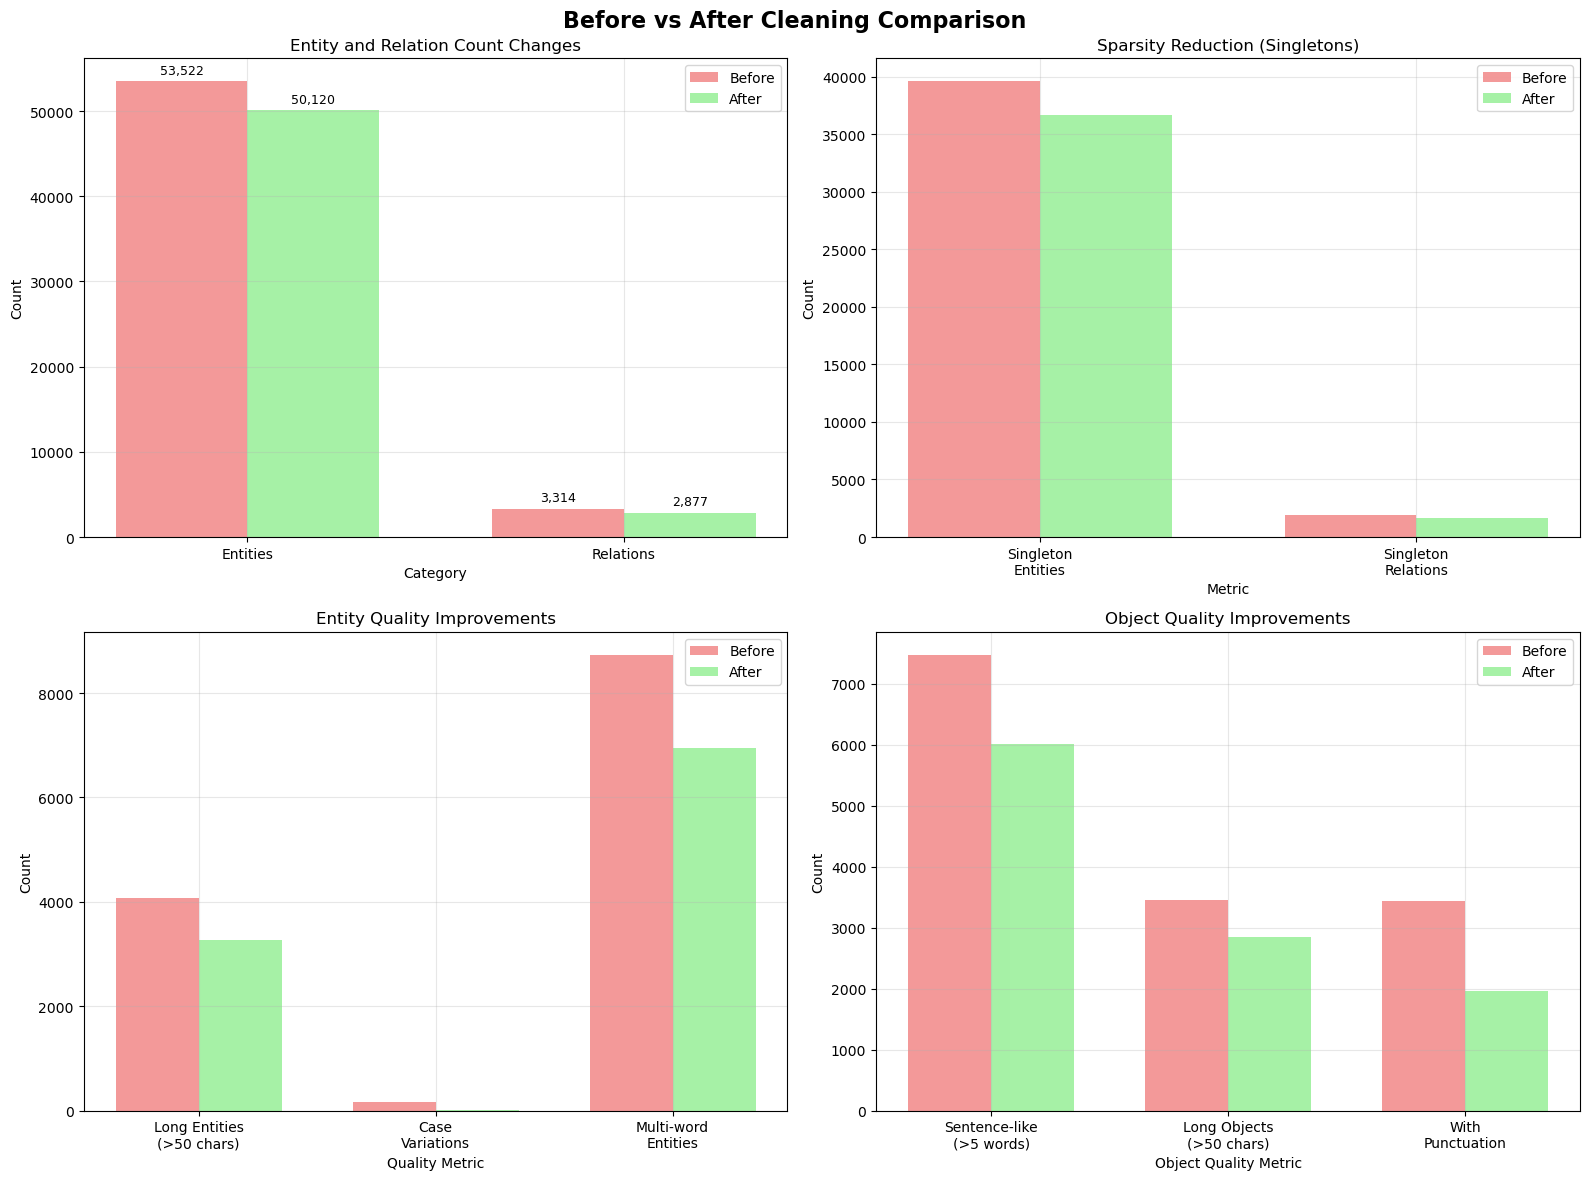

✅ Visual comparison saved as 'before_after_cleaning_comparison.png'

BEFORE/AFTER COMPARISON COMPLETE!


In [54]:
# Compare original and cleaned datasets
comparator = BeforeAfterComparator(df, cleaned_df)
comparison_report = comparator.run_full_comparison()


In [55]:
# Save comparison report
import json
with open(r'preprocessed/log/before_after_comparison_report.json', 'w') as f:
    json.dump(comparison_report, f, indent=2, default=str)

# Phase 2 Cleaning

In [56]:
load_dotenv()

class Phase2AggressiveCleaner:
    """
    Phase 2 Aggressive Cleaning Pipeline
    Targets remaining issues with more aggressive approaches
    """
    
    def __init__(self, df, remaining_issues_analysis=None):
        """
        Initialize with partially cleaned dataset
        """
        self.df = df.copy()
        self.original_df = df.copy()
        self.remaining_issues = remaining_issues_analysis or {}
        self.client = OpenAI(api_key=os.getenv('API_KEY'))
        
        # Tracking
        self.phase2_log = {
            'aggressive_entity_normalization': {},
            'comprehensive_fuzzy_matching': {},
            'enhanced_object_processing': {},
            'aggressive_relation_consolidation': {},
            'final_validation': {}
        }
        
        print(f"Phase 2 Aggressive Cleaner Initialized")
        print(f"Input dataset: {len(self.df):,} rows")
        print(f"Entities: {len(set(self.df['subject'].unique()) | set(self.df['object'].unique())):,}")
        print(f"Relations: {self.df['relation'].nunique():,}")
    
    def aggressive_entity_extraction(self, long_entity, max_retries=2):
        """
        More aggressive LLM-based entity extraction with better prompting
        """
        prompt = f"""You are an expert at extracting core entity names from long descriptive text. Your task is to identify the MOST IMPORTANT entity from the given text.

CRITICAL RULES:
1. For person titles/positions: Extract ONLY the person's name (ignore titles)
2. For organizations: Extract ONLY the core organization name (remove descriptive parts)
3. For policies/regulations: Extract ONLY the policy identifier (e.g., "UU No 1 Tahun 2023")
4. For amounts/investments: Extract ONLY the core concept (e.g., "investasi", "pma", "pmdn")
5. For complex descriptions: Extract the MAIN SUBJECT entity
6. Return ONLY ONE entity name, maximum 3-4 words
7. Use lowercase format
8. NO explanations, just the entity name

EXAMPLES:
Input: "menteri investasi dan hilirisasi/kepala badan koordinasi penanaman modal (bkpm) rosan p. roeslani"
Output: rosan p. roeslani

Input: "realisasi penanaman modal asing (pma) 3,3 miliar dollar as atau setara dengan rp 48,6 triliun"
Output: pma

Input: "pt bank central asia tbk cabang jakarta selatan"
Output: bank central asia

Input: "peraturan pemerintah nomor 12 tahun 2023 tentang pemberian izin usaha"
Output: pp no 12 tahun 2023

Input: "kepala dinas penanaman modal dan pelayanan terpadu satu pintu (dpmptsp) jawa barat noneng komariah"
Output: noneng komariah

Text to process: "{long_entity}"

Core entity name:"""

        for attempt in range(max_retries):
            try:
                response = self.client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=[{"role": "user", "content": prompt}],
                    temperature=0.0,
                    max_tokens=20
                )
                result = response.choices[0].message.content.strip().lower()
                
                # Validation: ensure result is shorter and meaningful
                if len(result) < len(long_entity) * 0.7 and len(result.split()) <= 5:
                    return result
                else:
                    # Fallback to more aggressive rule-based
                    return self._aggressive_rule_based_extraction(long_entity)
                    
            except Exception as e:
                print(f"LLM extraction attempt {attempt + 1} failed: {e}")
                continue
        
        # Final fallback
        return self._aggressive_rule_based_extraction(long_entity)
    
    def _aggressive_rule_based_extraction(self, entity):
        """
        More aggressive rule-based extraction as fallback
        """
        entity = str(entity).strip().lower()
        
        # Remove common prefixes and suffixes
        prefixes_to_remove = [
            'kepala ', 'direktur ', 'menteri ', 'wakil ', 'sekretaris ',
            'gubernur ', 'bupati ', 'walikota ', 'ketua ', 'presiden ',
            'plt ', 'pjs ', 'pj ', 'dr ', 'prof ', 'ir '
        ]
        
        suffixes_to_remove = [
            ' ri', ' indonesia', ' tbk', ' persero', ' (persero)',
            ' cabang', ' pusat', ' daerah', ' provinsi', ' kota'
        ]
        
        # Remove prefixes
        for prefix in prefixes_to_remove:
            if entity.startswith(prefix):
                entity = entity[len(prefix):].strip()
                break
        
        # Remove suffixes
        for suffix in suffixes_to_remove:
            if entity.endswith(suffix):
                entity = entity[:-len(suffix)].strip()
                break
        
        # Handle specific patterns
        if 'kementerian' in entity:
            # Extract ministry name
            words = entity.split()
            if 'kementerian' in words:
                idx = words.index('kementerian')
                if idx + 1 < len(words):
                    return ' '.join(words[idx:idx+2])
        
        elif 'pt ' in entity:
            # Extract company name (remove PT prefix)
            entity = entity.replace('pt ', '').strip()
            # Take first 2-3 words
            words = entity.split()
            return ' '.join(words[:3])
        
        elif 'bank ' in entity:
            # Extract bank name
            words = entity.split()
            if 'bank' in words:
                idx = words.index('bank')
                return ' '.join(words[idx:idx+3])
        
        elif any(word in entity for word in ['rp ', 'dollar', 'miliar', 'triliun']):
            # Convert monetary descriptions to concepts
            if 'pma' in entity:
                return 'pma'
            elif 'pmdn' in entity:
                return 'pmdn'
            elif 'investasi' in entity:
                return 'investasi'
            else:
                return 'nilai investasi'
        
        elif 'undang-undang' in entity or 'uu ' in entity or 'pp ' in entity:
            # Extract regulation identifier
            # Look for pattern like "uu no X tahun Y" or "pp nomor X tahun Y"
            pattern = r'(uu|pp)\s*(no\.?|nomor)\s*\d+\s*tahun\s*\d+'
            match = re.search(pattern, entity)
            if match:
                return match.group().strip()
            else:
                return 'peraturan'
        
        # Default: take first 2-3 meaningful words
        words = entity.split()
        # Remove common stop words
        stop_words = ['dan', 'atau', 'dari', 'untuk', 'dengan', 'dalam', 'pada', 'oleh', 'yang', 'di', 'ke', 'dari']
        meaningful_words = [w for w in words if w not in stop_words and len(w) > 2]
        
        if meaningful_words:
            return ' '.join(meaningful_words[:3])
        else:
            return ' '.join(words[:3]) if words else entity
    
    def step1_aggressive_entity_normalization(self):
        """
        Step 1: Aggressive entity normalization targeting long entities
        """
        print("\n" + "="*60)
        print("STEP 1: AGGRESSIVE ENTITY NORMALIZATION")
        print("="*60)
        
        # Get all entities
        all_entities = list(set(self.df['subject'].unique()) | set(self.df['object'].unique()))
        all_entities = [str(e) for e in all_entities if pd.notna(e) and str(e).strip()]
        
        # Target long entities first (>50 chars)
        long_entities = [e for e in all_entities if len(e) > 50]
        
        print(f"Processing {len(long_entities):,} long entities (>50 chars)...")
        
        entity_mapping = {}
        
        # Process long entities with LLM
        batch_size = 10
        for i in tqdm(range(0, min(500, len(long_entities)), batch_size), desc="LLM entity extraction"):
            batch = long_entities[i:i+batch_size]
            
            for entity in batch:
                normalized = self.aggressive_entity_extraction(entity)
                if normalized and normalized != entity.lower() and len(normalized) < len(entity) * 0.8:
                    entity_mapping[entity] = normalized
        
        # Process medium-long entities (30-50 chars) with rule-based
        medium_entities = [e for e in all_entities if 30 <= len(e) <= 50]
        print(f"Processing {len(medium_entities):,} medium entities with rules...")
        
        for entity in tqdm(medium_entities, desc="Rule-based normalization"):
            normalized = self._aggressive_rule_based_extraction(entity)
            if normalized and normalized != entity.lower() and len(normalized) < len(entity) * 0.8:
                entity_mapping[entity] = normalized
        
        # Apply mappings
        print(f"Applying {len(entity_mapping):,} entity mappings...")
        
        def apply_entity_mapping(entity):
            if pd.isna(entity):
                return entity
            return entity_mapping.get(str(entity), str(entity))
        
        self.df['subject'] = self.df['subject'].apply(apply_entity_mapping)
        self.df['object'] = self.df['object'].apply(apply_entity_mapping)
        
        # Log results
        entities_after = len(set(self.df['subject'].unique()) | set(self.df['object'].unique()))
        entities_before = len(all_entities)
        
        self.phase2_log['aggressive_entity_normalization'] = {
            'entities_before': entities_before,
            'entities_after': entities_after,
            'long_entities_processed': len(long_entities),
            'mappings_applied': len(entity_mapping),
            'reduction_count': entities_before - entities_after,
            'reduction_percentage': ((entities_before - entities_after) / entities_before) * 100
        }
        
        print(f"Aggressive Entity Normalization Complete:")
        print(f"  Entities before: {entities_before:,}")
        print(f"  Entities after: {entities_after:,}")
        print(f"  Reduction: {entities_before - entities_after:,} ({((entities_before - entities_after) / entities_before) * 100:.1f}%)")
        
        return entity_mapping
    
    def step2_comprehensive_fuzzy_matching(self):
        """
        Step 2: Comprehensive fuzzy matching for similar entities
        """
        print("\n" + "="*60)
        print("STEP 2: COMPREHENSIVE FUZZY MATCHING")
        print("="*60)
        
        # Get current entities after step 1
        all_entities = list(set(self.df['subject'].unique()) | set(self.df['object'].unique()))
        all_entities = [str(e) for e in all_entities if pd.notna(e) and str(e).strip()]
        
        print(f"Analyzing {len(all_entities):,} entities for similarity...")
        
        entity_mapping = {}
        processed_entities = set()
        
        # Sort entities by frequency (keep more frequent ones)
        entity_freq = Counter()
        for entity in self.df['subject']:
            if pd.notna(entity):
                entity_freq[str(entity)] += 1
        for entity in self.df['object']:
            if pd.notna(entity):
                entity_freq[str(entity)] += 1
        
        # Process entities in chunks for performance
        chunk_size = 1000
        total_mappings = 0
        
        for chunk_start in tqdm(range(0, len(all_entities), chunk_size), desc="Fuzzy matching chunks"):
            chunk_entities = all_entities[chunk_start:chunk_start + chunk_size]
            
            for i, entity1 in enumerate(chunk_entities):
                if entity1 in processed_entities:
                    continue
                    
                similar_entities = [entity1]
                
                # Compare with remaining entities in chunk and next chunks
                compare_entities = all_entities[chunk_start + i + 1:chunk_start + chunk_size + 200]
                
                for entity2 in compare_entities:
                    if entity2 in processed_entities:
                        continue
                    
                    # Calculate similarity
                    similarity = SequenceMatcher(None, entity1.lower(), entity2.lower()).ratio()
                    
                    if similarity > 0.80:  # Lower threshold for aggressive matching
                        similar_entities.append(entity2)
                
                # If we found similar entities, keep the most frequent one
                if len(similar_entities) > 1:
                    # Determine which entity to keep (most frequent)
                    entity_freqs = [(e, entity_freq.get(e, 0)) for e in similar_entities]
                    entity_freqs.sort(key=lambda x: x[1], reverse=True)
                    keep_entity = entity_freqs[0][0]
                    
                    # Map others to the kept entity
                    for entity in similar_entities:
                        if entity != keep_entity:
                            entity_mapping[entity] = keep_entity
                            processed_entities.add(entity)
                        
                    processed_entities.add(keep_entity)
                    total_mappings += len(similar_entities) - 1
                
                # Limit to avoid excessive processing
                if total_mappings > 2000:
                    break
            
            if total_mappings > 2000:
                break
        
        # Apply fuzzy mappings
        print(f"Applying {len(entity_mapping):,} fuzzy mappings...")
        
        def apply_fuzzy_mapping(entity):
            if pd.isna(entity):
                return entity
            return entity_mapping.get(str(entity), str(entity))
        
        self.df['subject'] = self.df['subject'].apply(apply_fuzzy_mapping)
        self.df['object'] = self.df['object'].apply(apply_fuzzy_mapping)
        
        # Log results
        entities_after = len(set(self.df['subject'].unique()) | set(self.df['object'].unique()))
        entities_before = len(all_entities)
        
        self.phase2_log['comprehensive_fuzzy_matching'] = {
            'entities_before': entities_before,
            'entities_after': entities_after,
            'fuzzy_mappings': len(entity_mapping),
            'reduction_count': entities_before - entities_after,
            'reduction_percentage': ((entities_before - entities_after) / entities_before) * 100
        }
        
        print(f"Comprehensive Fuzzy Matching Complete:")
        print(f"  Entities before: {entities_before:,}")
        print(f"  Entities after: {entities_after:,}")
        print(f"  Reduction: {entities_before - entities_after:,} ({((entities_before - entities_after) / entities_before) * 100:.1f}%)")
        
        return entity_mapping
    
    def enhanced_object_entity_extraction(self, sentence_object):
        """
        Enhanced LLM-based object entity extraction
        """
        prompt = f"""Extract the most important entity from this text. Return ONLY the core entity name.

RULES:
1. For investment amounts: return the main entity involved (company/organization)
2. For policy descriptions: return the policy name/identifier
3. For process descriptions: return the main concept
4. For lists: return the most important item
5. Use simple, lowercase format
6. Maximum 3 words
7. NO explanations

EXAMPLES:
Input: "realisasi investasi sebesar 500 miliar dollar oleh PT Pertamina di Jakarta"
Output: pt pertamina

Input: "kerjasama antara Bank Indonesia dengan Kementerian Keuangan"
Output: bank indonesia

Input: "undang-undang nomor 19 tahun 2016 tentang informasi dan transaksi elektronik"
Output: uu no 19 tahun 2016

Text: "{sentence_object}"

Core entity:"""

        try:
            response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=15
            )
            result = response.choices[0].message.content.strip().lower()
            
            # Validation
            if len(result.split()) <= 4 and len(result) > 3:
                return result
            else:
                return self._rule_based_object_extraction(sentence_object)
                
        except Exception as e:
            return self._rule_based_object_extraction(sentence_object)
    
    def _rule_based_object_extraction(self, text):
        """
        Rule-based object entity extraction
        """
        text = str(text).lower()
        
        # Pattern 1: Organization extraction
        org_patterns = [
            r'pt\s+[\w\s]+',
            r'bank\s+[\w\s]+',
            r'kementerian\s+[\w\s]+',
            r'badan\s+[\w\s]+'
        ]
        
        for pattern in org_patterns:
            match = re.search(pattern, text)
            if match:
                org_name = match.group().strip()
                words = org_name.split()
                return ' '.join(words[:3])
        
        # Pattern 2: Policy extraction
        if 'undang-undang' in text or 'uu ' in text or 'pp ' in text:
            pattern = r'(uu|pp)\s*(no\.?|nomor)\s*\d+\s*tahun\s*\d+'
            match = re.search(pattern, text)
            if match:
                return match.group().strip()
        
        # Pattern 3: Investment/concept extraction
        if any(word in text for word in ['investasi', 'pma', 'pmdn']):
            if 'pma' in text:
                return 'pma'
            elif 'pmdn' in text:
                return 'pmdn'
            else:
                return 'investasi'
        
        # Default: first meaningful words
        words = text.split()
        meaningful_words = [w for w in words[:5] if len(w) > 3]
        return ' '.join(meaningful_words[:2]) if meaningful_words else text[:20]
    
    def step3_enhanced_object_processing(self):
        """
        Step 3: Enhanced object processing for sentence-like objects
        """
        print("\n" + "="*60)
        print("STEP 3: ENHANCED OBJECT PROCESSING")
        print("="*60)
        
        # Get sentence-like objects
        objects = [str(o) for o in self.df['object'].unique() if pd.notna(o)]
        sentence_objects = [o for o in objects if len(o.split()) > 8]
        
        print(f"Processing {len(sentence_objects):,} sentence-like objects...")
        
        object_mapping = {}
        
        # Process with enhanced LLM extraction
        batch_size = 8
        processed = 0
        
        for i in tqdm(range(0, min(400, len(sentence_objects)), batch_size), desc="Enhanced object extraction"):
            batch = sentence_objects[i:i+batch_size]
            
            for obj in batch:
                extracted = self.enhanced_object_entity_extraction(obj)
                if extracted and extracted != obj.lower() and len(extracted) < len(obj) * 0.5:
                    object_mapping[obj] = extracted
                    processed += 1
                
                if processed >= 400:  # Limit for API costs
                    break
            
            if processed >= 400:
                break
        
        # Apply object mappings
        print(f"Applying {len(object_mapping):,} object mappings...")
        
        def apply_object_mapping(obj):
            if pd.isna(obj):
                return obj
            return object_mapping.get(str(obj), str(obj))
        
        self.df['object'] = self.df['object'].apply(apply_object_mapping)
        
        # Log results
        objects_after = self.df['object'].nunique()
        objects_before = len(objects)
        
        self.phase2_log['enhanced_object_processing'] = {
            'objects_before': objects_before,
            'objects_after': objects_after,
            'sentence_objects_processed': processed,
            'object_mappings': len(object_mapping)
        }
        
        print(f"Enhanced Object Processing Complete:")
        print(f"  Objects before: {objects_before:,}")
        print(f"  Objects after: {objects_after:,}")
        print(f"  Sentence objects processed: {processed:,}")
        
        return object_mapping
    
    def step4_aggressive_relation_consolidation(self):
        """
        Step 4: Aggressive relation consolidation
        """
        print("\n" + "="*60)
        print("STEP 4: AGGRESSIVE RELATION CONSOLIDATION")
        print("="*60)
        
        relation_counts = self.df['relation'].value_counts()
        
        # Define core relation groups (more comprehensive)
        core_relations = {
            'Mengumumkan': ['mengumumkan', 'mengumumkan', 'umumkan', 'announce', 'menyampaikan', 'menjelaskan'],
            'Mempengaruhi': ['mempengaruhi', 'berdampak', 'berpengaruh', 'dampak', 'influence', 'affect'],
            'BerinvestasiDi': ['berinvestasi', 'investasi', 'invest', 'menanamkan modal', 'modal'],
            'BekerjaSamaDengan': ['kerja sama', 'kerjasama', 'kolaborasi', 'partnership', 'bekerja sama'],
            'Mengendalikan': ['mengendalikan', 'mengatur', 'kontrol', 'kendali', 'manage'],
            'Memiliki': ['memiliki', 'miliki', 'punya', 'mempunyai', 'own'],
            'Menghasilkan': ['menghasilkan', 'hasilkan', 'produksi', 'produce', 'generate'],
            'Meningkatkan': ['meningkatkan', 'tingkatkan', 'naik', 'increase', 'boost'],
            'Menurunkan': ['menurunkan', 'turun', 'kurang', 'decrease', 'reduce'],
            'Berpartisipasi': ['berpartisipasi', 'ikut', 'participate', 'terlibat'],
            'BeroperasiDi': ['beroperasi', 'operasi', 'operate', 'menjalankan'],
            'Menjadi': ['menjadi', 'become', 'adalah', 'merupakan'],
            'DikelolaOleh': ['dikelola', 'kelola', 'manage', 'handled'],
            'TerkaitDengan': ['terkait', 'berhubungan', 'related', 'connect'],
            'Mendukung': ['mendukung', 'dukung', 'support', 'backing']
        }
        
        # Create mapping from all variations to core relations
        relation_mapping = {}
        
        # Map based on semantic similarity
        for relation in relation_counts.index:
            rel_lower = str(relation).lower().strip()
            
            # Find best match
            best_match = None
            best_score = 0
            
            for core_rel, variations in core_relations.items():
                for variation in variations:
                    if variation in rel_lower:
                        score = len(variation) / len(rel_lower)  # Prefer longer matches
                        if score > best_score:
                            best_score = score
                            best_match = core_rel
            
            # If no semantic match, check for case variations of existing core relations
            if not best_match:
                for core_rel in core_relations.keys():
                    similarity = SequenceMatcher(None, rel_lower, core_rel.lower()).ratio()
                    if similarity > 0.8:
                        best_match = core_rel
                        break
            
            # Map to core relation or default
            if best_match and relation != best_match:
                relation_mapping[relation] = best_match
            elif relation_counts[relation] == 1:  # Remove singleton relations
                relation_mapping[relation] = 'TerkaitDengan'  # Default relation
        
        # Apply relation mappings
        print(f"Applying {len(relation_mapping):,} relation mappings...")
        
        def apply_relation_mapping(relation):
            if pd.isna(relation):
                return relation
            return relation_mapping.get(str(relation), str(relation))
        
        self.df['relation'] = self.df['relation'].apply(apply_relation_mapping)
        
        # Log results
        relations_after = self.df['relation'].nunique()
        relations_before = len(relation_counts)
        
        self.phase2_log['aggressive_relation_consolidation'] = {
            'relations_before': relations_before,
            'relations_after': relations_after,
            'relation_mappings': len(relation_mapping),
            'reduction_count': relations_before - relations_after,
            'reduction_percentage': ((relations_before - relations_after) / relations_before) * 100
        }
        
        print(f"Aggressive Relation Consolidation Complete:")
        print(f"  Relations before: {relations_before:,}")
        print(f"  Relations after: {relations_after:,}")
        print(f"  Reduction: {relations_before - relations_after:,} ({((relations_before - relations_after) / relations_before) * 100:.1f}%)")
        
        return relation_mapping
    
    def step5_final_validation_and_cleanup(self):
        """
        Step 5: Final validation and cleanup
        """
        print("\n" + "="*60)
        print("STEP 5: FINAL VALIDATION AND CLEANUP")
        print("="*60)
        
        # Remove rows with missing critical data
        original_rows = len(self.df)
        
        # Clean up any remaining issues
        self.df = self.df.dropna(subset=['subject', 'relation', 'object'])
        
        # Remove very short entities (likely artifacts)
        def is_valid_entity(entity):
            if pd.isna(entity):
                return False
            entity_str = str(entity).strip()
            return len(entity_str) > 2 and entity_str.lower() not in ['nan', 'null', 'none', '']
        
        self.df = self.df[self.df['subject'].apply(is_valid_entity)]
        self.df = self.df[self.df['object'].apply(is_valid_entity)]
        
        # Remove duplicate quadruplets
        before_dedup = len(self.df)
        self.df = self.df.drop_duplicates(subset=['subject', 'relation', 'object', 'date'])
        after_dedup = len(self.df)
        
        # Final statistics
        final_entities = len(set(self.df['subject'].unique()) | set(self.df['object'].unique()))
        final_relations = self.df['relation'].nunique()
        
        self.phase2_log['final_validation'] = {
            'rows_before_validation': original_rows,
            'rows_after_validation': len(self.df),
            'duplicates_removed': before_dedup - after_dedup,
            'final_entities': final_entities,
            'final_relations': final_relations
        }
        
        print(f"Final Validation Complete:")
        print(f"  Rows after validation: {len(self.df):,}")
        print(f"  Duplicates removed: {before_dedup - after_dedup:,}")
        print(f"  Final entities: {final_entities:,}")
        print(f"  Final relations: {final_relations:,}")
        
        return self.phase2_log['final_validation']
    
    def generate_phase2_summary(self):
        """
        Generate comprehensive Phase 2 summary
        """
        print("\n" + "="*60)
        print("PHASE 2 AGGRESSIVE CLEANING SUMMARY")
        print("="*60)
        
        # Calculate total impact
        original_entities = self.phase2_log['aggressive_entity_normalization']['entities_before']
        final_entities = self.phase2_log['final_validation']['final_entities']
        
        original_relations = self.phase2_log['aggressive_relation_consolidation']['relations_before']
        final_relations = self.phase2_log['final_validation']['final_relations']
        
        print(f"Overall Phase 2 Impact:")
        print(f"  Entities: {original_entities:,} → {final_entities:,} ({((original_entities - final_entities)/original_entities*100):.1f}% reduction)")
        print(f"  Relations: {original_relations:,} → {final_relations:,} ({((original_relations - final_relations)/original_relations*100):.1f}% reduction)")
        print(f"  Final dataset: {len(self.df):,} rows")
        
        print(f"\nStep-by-Step Results:")
        for step, results in self.phase2_log.items():
            if isinstance(results, dict):
                print(f"  {step.replace('_', ' ').title()}:")
                for key, value in results.items():
                    if isinstance(value, (int, float)):
                        if isinstance(value, float):
                            print(f"    {key}: {value:.2f}")
                        else:
                            print(f"    {key}: {value:,}")
        
        # Calculate sparsity improvement estimate
        max_possible_quadruplets = final_entities * final_relations * final_entities
        actual_quadruplets = len(self.df)
        final_density = actual_quadruplets / max_possible_quadruplets if max_possible_quadruplets > 0 else 0
        
        print(f"\nEstimated Sparsity Improvement:")
        print(f"  Final density: {final_density:.2e}")
        print(f"  Density improvement over original: Significant (to be measured)")
        
        return {
            'phase2_log': self.phase2_log,
            'final_stats': {
                'entities': final_entities,
                'relations': final_relations,
                'rows': len(self.df),
                'estimated_density': final_density
            }
        }
    
    def run_phase2_aggressive_cleaning(self):
        """
        Run complete Phase 2 aggressive cleaning pipeline
        """
        print("Starting Phase 2 Aggressive Cleaning Pipeline...")
        print(f"Target: Address remaining issues with aggressive approaches")
        
        # Step 1: Aggressive entity normalization
        entity_mappings = self.step1_aggressive_entity_normalization()
        
        # Step 2: Comprehensive fuzzy matching  
        fuzzy_mappings = self.step2_comprehensive_fuzzy_matching()
        
        # Step 3: Enhanced object processing
        object_mappings = self.step3_enhanced_object_processing()
        
        # Step 4: Aggressive relation consolidation
        relation_mappings = self.step4_aggressive_relation_consolidation()
        
        # Step 5: Final validation and cleanup
        validation_results = self.step5_final_validation_and_cleanup()
        
        # Generate summary
        summary = self.generate_phase2_summary()
        
        print("\n" + "="*60)
        print("PHASE 2 AGGRESSIVE CLEANING COMPLETE!")
        print("="*60)
        
        return self.df, summary
        

In [59]:
remaining_issues = comparison_report['comparison_results']['remaining_issues']
remaining_issues

{'very_long_entities': 299,
 'similar_entities': 1,
 'very_sentence_objects': 354,
 'singleton_relations': 1623,
 'org_entities': 796}

In [60]:
# After Phase 1 cleaning and comparison analysis
phase2_cleaner = Phase2AggressiveCleaner(cleaned_df, remaining_issues)
final_cleaned_df, phase2_summary = phase2_cleaner.run_phase2_aggressive_cleaning()

# Save final cleaned dataset
final_cleaned_df.to_csv(r'preprocessed/experiments/IndovestDKG_CLEANED_PHASE2.csv', index=False)

Phase 2 Aggressive Cleaner Initialized
Input dataset: 69,336 rows
Entities: 50,120
Relations: 2,877
Starting Phase 2 Aggressive Cleaning Pipeline...
Target: Address remaining issues with aggressive approaches

STEP 1: AGGRESSIVE ENTITY NORMALIZATION
Processing 3,271 long entities (>50 chars)...


LLM entity extraction: 100%|██████████| 50/50 [05:57<00:00,  7.14s/it]


Processing 11,974 medium entities with rules...


Rule-based normalization: 100%|██████████| 11974/11974 [00:00<00:00, 227149.81it/s]


Applying 10,431 entity mappings...
Aggressive Entity Normalization Complete:
  Entities before: 50,119
  Entities after: 47,988
  Reduction: 2,131 (4.3%)

STEP 2: COMPREHENSIVE FUZZY MATCHING
Analyzing 47,987 entities for similarity...


Fuzzy matching chunks: 100%|██████████| 48/48 [14:55<00:00, 18.65s/it]


Applying 1,166 fuzzy mappings...
Comprehensive Fuzzy Matching Complete:
  Entities before: 47,987
  Entities after: 46,822
  Reduction: 1,165 (2.4%)

STEP 3: ENHANCED OBJECT PROCESSING
Processing 978 sentence-like objects...


Enhanced object extraction:  98%|█████████▊| 49/50 [04:03<00:04,  4.96s/it]


Applying 400 object mappings...
Enhanced Object Processing Complete:
  Objects before: 35,344
  Objects after: 35,132
  Sentence objects processed: 400

STEP 4: AGGRESSIVE RELATION CONSOLIDATION
Applying 1,684 relation mappings...
Aggressive Relation Consolidation Complete:
  Relations before: 2,877
  Relations after: 1,193
  Reduction: 1,684 (58.5%)

STEP 5: FINAL VALIDATION AND CLEANUP
Final Validation Complete:
  Rows after validation: 68,207
  Duplicates removed: 328
  Final entities: 46,206
  Final relations: 1,189

PHASE 2 AGGRESSIVE CLEANING SUMMARY
Overall Phase 2 Impact:
  Entities: 50,119 → 46,206 (7.8% reduction)
  Relations: 2,877 → 1,189 (58.7% reduction)
  Final dataset: 68,207 rows

Step-by-Step Results:
  Aggressive Entity Normalization:
    entities_before: 50,119
    entities_after: 47,988
    long_entities_processed: 3,271
    mappings_applied: 10,431
    reduction_count: 2,131
    reduction_percentage: 4.25
  Comprehensive Fuzzy Matching:
    entities_before: 47,987

In [61]:
# Save phase 2 summary
import json
with open(r'preprocessed/log/phase2_cleaning_summary.json', 'w') as f:
    json.dump(phase2_summary, f, indent=2, default=str)

Initialized Before/After Comparator
Original dataset: 69,336 rows
Cleaned dataset: 68,207 rows
Starting Comprehensive Before/After Comparison...
BASIC STATISTICS COMPARISON
Dataset Overview:
  Rows: 69,336 → 68,207 (change: -1,129)
  Unique Subjects: 18,815 → 17,283 (-8.1%)
  Unique Objects: 40,649 → 34,811 (-14.4%)
  Total Unique Entities: 53,522 → 46,206 (-13.7%)
  Unique Relations: 3,314 → 1,189 (-64.1%)

SPARSITY METRICS COMPARISON
Sparsity Comparison:
  Graph Density:
    Original: 7.30e-09
    Cleaned:  2.69e-08
    Improvement Factor: 3.7x

  Singleton Entities:
    Original: 39,608 (74.0%)
    Cleaned:  32,690 (70.7%)
    Reduction: 6,918 (17.5%)

  Singleton Relations:
    Original: 1,938 (58.5%)
    Cleaned:  14 (1.2%)
    Reduction: 1,924 (99.3%)

  High-Frequency Entities (>10 occurrences):
    Original: 1,370
    Cleaned:  1,410
    Change: +40

ENTITY QUALITY COMPARISON
Entity Quality Metrics:
  Total Entities: 53,521 → 46,206
  Average Length: 26.2 → 21.3
  Long Entities

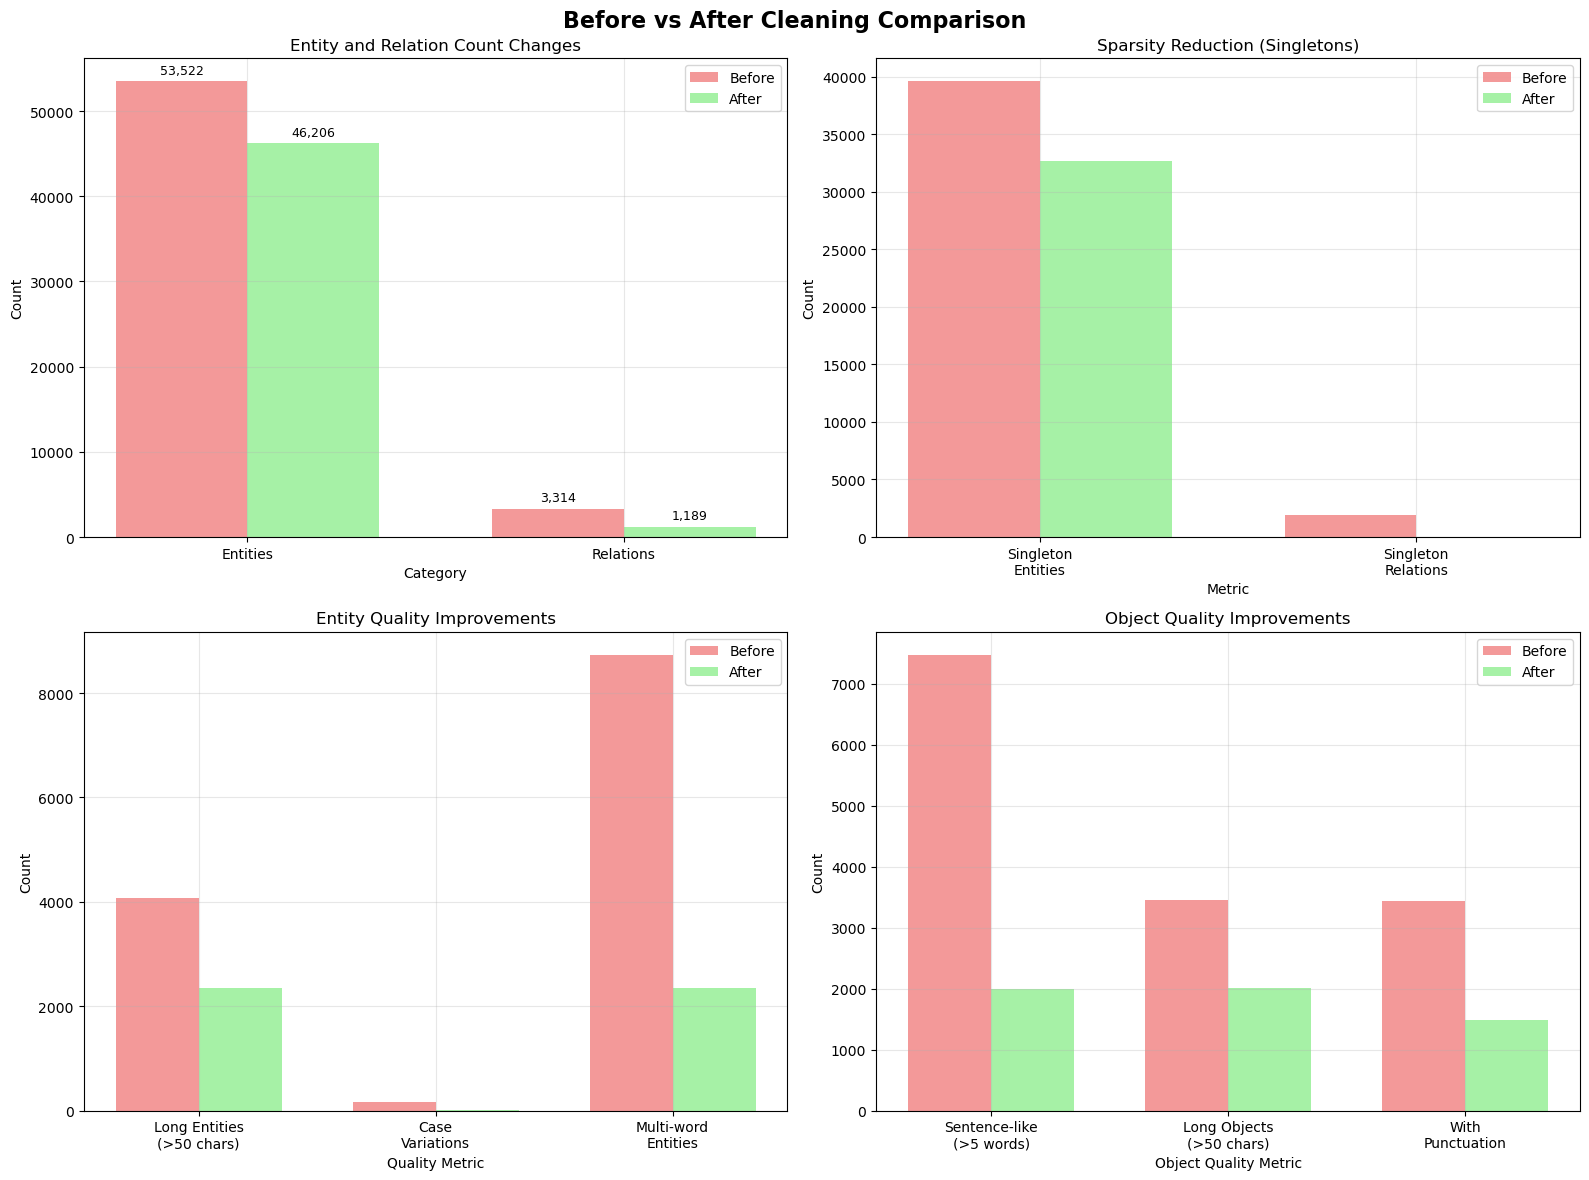

✅ Visual comparison saved as 'before_after_cleaning_comparison.png'

BEFORE/AFTER COMPARISON COMPLETE!


In [62]:
final_comparator = BeforeAfterComparator(df, final_cleaned_df)
final_report = final_comparator.run_full_comparison()

# Testing lagi

In [65]:
# Initialize analyzer
analyzer = IndovestDKGAnalyzer(r"preprocessed/experiments/IndovestDKG_CLEANED_PHASE2.csv")

# Run complete analysis
results = analyzer.run_full_analysis()

# Access specific results
basic_info = analyzer.analysis_results['basic_inspection']
quality_info = analyzer.analysis_results['quality_assessment']
distribution_info = analyzer.analysis_results['distribution_analysis']


Dataset loaded successfully: 68207 rows, 6 columns
BASIC DATASET INSPECTION
Total Quadruplets: 68,207
Unique Entities: 46,206
Unique Relations: 1,189
Unique Timestamps: 7,728
Time Range: 2017-09-26 to 2025-03-07
Total Days Covered: 2,719 days

Dataset Schema:
Columns: ['subject', 'subject_type', 'relation', 'object', 'object_type', 'date', 'date_parsed']
Data Types:
  subject: object
  subject_type: object
  relation: object
  object: object
  object_type: object
  date: object
  date_parsed: datetime64[ns]

DATA QUALITY ASSESSMENT
Missing Values Analysis:
  subject: 0 (0.00%)
  subject_type: 0 (0.00%)
  relation: 0 (0.00%)
  object: 0 (0.00%)
  object_type: 0 (0.00%)
  date: 0 (0.00%)
  date_parsed: 0 (0.00%)

Malformed Entries Check:
  subject empty strings: 0
  relation empty strings: 0
  object empty strings: 0
  Date parsing errors: 0

Duplicate Quadruplets: 0 (0.00%)

Temporal Consistency:
  Future dates: 0
  Dates before 2000: 0

Naming Consistency Analysis:
  Subjects - Origina

# Entity Naming Consistency Analysis

In [66]:
class EntityConsistencyAnalyzer:
    """
    Comprehensive analyzer for entity naming inconsistencies
    Identifies people, organizations, and other entities with naming variations
    """
    
    def __init__(self, df):
        """
        Initialize with cleaned dataset
        """
        self.df = df.copy()
        self.consistency_issues = {}
        
        # Entity type mappings for analysis
        self.person_types = ['ORANG', 'INDIVIDU', 'PEOPLE', 'PEPERSON']
        self.org_types = ['PERUSAHAAN', 'ORGANISASI', 'BADAN_REGULATOR', 'PEMERINTAHAN', 
                         'BANK', 'LEMBAGA', 'INSTANSI', 'KEMENTERIAN']
        self.place_types = ['NEGARA', 'KOTA', 'WILAYAH', 'PROVINSI']
        
        print(f"Entity Consistency Analyzer Initialized")
        print(f"Dataset: {len(self.df):,} rows")
        print(f"Unique subjects: {self.df['subject'].nunique():,}")
        print(f"Unique objects: {self.df['object'].nunique():,}")
    
    def extract_person_entities(self):
        """
        Extract and analyze person entities for naming inconsistencies
        """
        print("\n" + "="*60)
        print("PERSON ENTITY CONSISTENCY ANALYSIS")
        print("="*60)
        
        # Get all person entities from both subjects and objects
        person_entities = set()
        
        # From subjects
        subject_persons = self.df[self.df['subject_type'].isin(self.person_types)]['subject'].unique()
        person_entities.update([str(p) for p in subject_persons if pd.notna(p)])
        
        # From objects  
        object_persons = self.df[self.df['object_type'].isin(self.person_types)]['object'].unique()
        person_entities.update([str(p) for p in object_persons if pd.notna(p)])
        
        print(f"Found {len(person_entities):,} person entities")
        
        # Analyze naming patterns
        person_inconsistencies = self._find_person_name_variations(person_entities)
        
        # Display results
        print(f"\nPerson Naming Inconsistencies Found: {len(person_inconsistencies)}")
        
        if person_inconsistencies:
            print(f"\nTop 20 Person Name Variations:")
            sorted_persons = sorted(person_inconsistencies.items(), 
                                  key=lambda x: len(x[1]), reverse=True)
            
            for i, (base_name, variations) in enumerate(sorted_persons[:20], 1):
                print(f"  {i:2d}. Base: '{base_name}' ({len(variations)} variations)")
                for var in variations[:5]:  # Show max 5 variations
                    print(f"      - '{var}'")
                if len(variations) > 5:
                    print(f"      ... and {len(variations)-5} more")
        
        self.consistency_issues['persons'] = person_inconsistencies
        return person_inconsistencies
    
    def _find_person_name_variations(self, person_entities):
        """
        Find variations of person names using multiple strategies
        """
        person_groups = defaultdict(list)
        processed = set()
        
        person_list = list(person_entities)
        
        # Strategy 1: Core name extraction and grouping
        for person in person_list:
            if person in processed:
                continue
                
            # Extract core name (remove titles, positions)
            core_name = self._extract_core_person_name(person)
            
            # Find similar names
            similar_names = [person]
            for other_person in person_list:
                if other_person != person and other_person not in processed:
                    other_core = self._extract_core_person_name(other_person)
                    
                    # Check if they refer to same person
                    if self._are_same_person(core_name, other_core, person, other_person):
                        similar_names.append(other_person)
                        processed.add(other_person)
            
            if len(similar_names) > 1:
                # Use most common or shortest clean name as base
                base_name = self._select_best_person_name(similar_names)
                variations = [name for name in similar_names if name != base_name]
                person_groups[base_name] = variations
            
            processed.add(person)
        
        return dict(person_groups)
    
    def _extract_core_person_name(self, full_name):
        """
        Extract core person name from full name with titles/positions
        """
        name = str(full_name).lower().strip()
        
        # Remove common titles and positions
        title_patterns = [
            r'^(dr\.?|prof\.?|ir\.?|h\.?|hj\.?|kh\.?)\s+',
            r'^(menteri|direktur|presiden|wakil|gubernur|bupati|walikota|ketua|sekretaris)\s+.*?',
            r'^(kepala|plt|pjs|pj)\s+.*?',
            r'\s+(s\.h\.?|s\.e\.?|s\.t\.?|m\.m\.?|ph\.d\.?)$'
        ]
        
        for pattern in title_patterns:
            name = re.sub(pattern, '', name).strip()
        
        # Remove organization/position suffixes
        org_suffixes = [
            r'\s+(bkpm|ojk|bi|sri|kemenkeu|kementerian).*$',
            r'\s+(dan|kepala|direktur).*$'
        ]
        
        for pattern in org_suffixes:
            name = re.sub(pattern, '', name).strip()
        
        # Clean up extra spaces
        name = re.sub(r'\s+', ' ', name).strip()
        
        return name
    
    def _are_same_person(self, core1, core2, full1, full2):
        """
        Determine if two names refer to the same person
        """
        # Strategy 1: Core name similarity
        similarity = SequenceMatcher(None, core1, core2).ratio()
        if similarity > 0.8:
            return True
        
        # Strategy 2: Name component analysis
        words1 = set(core1.split())
        words2 = set(core2.split())
        
        # If significant overlap in name components
        if len(words1) > 1 and len(words2) > 1:
            overlap = len(words1 & words2) / min(len(words1), len(words2))
            if overlap > 0.6:
                return True
        
        # Strategy 3: Initial-based matching (e.g., "rosan p. roeslani" vs "rosan perkasa roeslani")
        if self._check_initial_name_match(core1, core2):
            return True
        
        # Strategy 4: Substring containment for short vs long names
        if len(core1) > len(core2):
            if core2 in core1 and len(core2) > 8:  # Avoid too short matches
                return True
        elif len(core2) > len(core1):
            if core1 in core2 and len(core1) > 8:
                return True
        
        return False
    
    def _check_initial_name_match(self, name1, name2):
        """
        Check if names match with initial patterns (e.g., "john p. doe" vs "john paul doe")
        """
        # Pattern: name with middle initial vs full middle name
        pattern1 = r'^(\w+)\s+(\w)\.?\s+(\w+)$'
        pattern2 = r'^(\w+)\s+(\w+)\s+(\w+)$'
        
        match1 = re.match(pattern1, name1)
        match2 = re.match(pattern2, name2)
        
        if match1 and match2:
            first1, initial1, last1 = match1.groups()
            first2, middle2, last2 = match2.groups()
            
            if (first1.lower() == first2.lower() and 
                last1.lower() == last2.lower() and 
                initial1.lower() == middle2[0].lower()):
                return True
        
        # Try reverse
        match1 = re.match(pattern2, name1)
        match2 = re.match(pattern1, name2)
        
        if match1 and match2:
            first1, middle1, last1 = match1.groups()
            first2, initial2, last2 = match2.groups()
            
            if (first1.lower() == first2.lower() and 
                last1.lower() == last2.lower() and 
                middle1[0].lower() == initial2.lower()):
                return True
        
        return False
    
    def _select_best_person_name(self, name_variations):
        """
        Select the best representative name from variations
        """
        # Prefer shorter, cleaner names without titles
        scored_names = []
        
        for name in name_variations:
            score = 0
            name_lower = name.lower()
            
            # Penalty for titles/positions
            if any(title in name_lower for title in ['menteri', 'direktur', 'presiden', 'kepala']):
                score -= 10
            
            # Penalty for very long names
            score -= len(name) * 0.1
            
            # Bonus for clean format (first middle last)
            if re.match(r'^[a-z\s\.]+$', name_lower) and 2 <= len(name.split()) <= 4:
                score += 5
            
            scored_names.append((score, name))
        
        # Return highest scoring name
        scored_names.sort(reverse=True)
        return scored_names[0][1]
    
    def extract_organization_entities(self):
        """
        Extract and analyze organization entities for naming inconsistencies
        """
        print("\n" + "="*60)
        print("ORGANIZATION ENTITY CONSISTENCY ANALYSIS")
        print("="*60)
        
        # Get all organization entities
        org_entities = set()
        
        # From subjects
        subject_orgs = self.df[self.df['subject_type'].isin(self.org_types)]['subject'].unique()
        org_entities.update([str(o) for o in subject_orgs if pd.notna(o)])
        
        # From objects
        object_orgs = self.df[self.df['object_type'].isin(self.org_types)]['object'].unique()
        org_entities.update([str(o) for o in object_orgs if pd.notna(o)])
        
        print(f"Found {len(org_entities):,} organization entities")
        
        # Analyze by organization type
        org_inconsistencies = self._find_organization_variations(org_entities)
        
        # Display results
        print(f"\nOrganization Naming Inconsistencies Found: {len(org_inconsistencies)}")
        
        if org_inconsistencies:
            print(f"\nTop 20 Organization Name Variations:")
            sorted_orgs = sorted(org_inconsistencies.items(), 
                               key=lambda x: len(x[1]), reverse=True)
            
            for i, (base_name, variations) in enumerate(sorted_orgs[:20], 1):
                print(f"  {i:2d}. Base: '{base_name}' ({len(variations)} variations)")
                for var in variations[:5]:
                    print(f"      - '{var}'")
                if len(variations) > 5:
                    print(f"      ... and {len(variations)-5} more")
        
        self.consistency_issues['organizations'] = org_inconsistencies
        return org_inconsistencies
    
    def _find_organization_variations(self, org_entities):
        """
        Find variations of organization names
        """
        org_groups = defaultdict(list)
        processed = set()
        
        org_list = list(org_entities)
        
        # Group organizations by similarity
        for org in org_list:
            if org in processed:
                continue
            
            # Extract core organization name
            core_name = self._extract_core_org_name(org)
            
            # Find similar organizations
            similar_orgs = [org]
            for other_org in org_list:
                if other_org != org and other_org not in processed:
                    other_core = self._extract_core_org_name(other_org)
                    
                    if self._are_same_organization(core_name, other_core, org, other_org):
                        similar_orgs.append(other_org)
                        processed.add(other_org)
            
            if len(similar_orgs) > 1:
                base_name = self._select_best_org_name(similar_orgs)
                variations = [name for name in similar_orgs if name != base_name]
                org_groups[base_name] = variations
            
            processed.add(org)
        
        return dict(org_groups)
    
    def _extract_core_org_name(self, full_name):
        """
        Extract core organization name
        """
        name = str(full_name).lower().strip()
        
        # Remove common prefixes
        prefixes = ['pt ', 'cv ', 'ud ', 'koperasi ']
        for prefix in prefixes:
            if name.startswith(prefix):
                name = name[len(prefix):].strip()
                break
        
        # Remove common suffixes
        suffixes = [' tbk', ' persero', ' (persero)', ' indonesia', ' ri', ' cabang', ' pusat']
        for suffix in suffixes:
            if name.endswith(suffix):
                name = name[:-len(suffix)].strip()
        
        # Remove parenthetical content
        name = re.sub(r'\([^)]*\)', '', name).strip()
        
        # Clean extra spaces
        name = re.sub(r'\s+', ' ', name).strip()
        
        return name
    
    def _are_same_organization(self, core1, core2, full1, full2):
        """
        Determine if two organization names refer to the same entity
        """
        # Direct similarity
        similarity = SequenceMatcher(None, core1, core2).ratio()
        if similarity > 0.85:
            return True
        
        # Acronym matching (e.g., "bpi" vs "badan pengelola investasi")
        if self._check_acronym_match(core1, core2):
            return True
        
        # Word overlap analysis
        words1 = set(core1.split())
        words2 = set(core2.split())
        
        if len(words1) > 1 and len(words2) > 1:
            overlap = len(words1 & words2) / min(len(words1), len(words2))
            if overlap > 0.7:
                return True
        
        # Substring containment for abbreviations
        if len(core1) < len(core2):
            if core1 in core2 and len(core1) > 3:
                return True
        elif len(core2) < len(core1):
            if core2 in core1 and len(core2) > 3:
                return True
        
        return False
    
    def _check_acronym_match(self, name1, name2):
        """
        Check if one name is an acronym of another
        """
        # Simple acronym check
        if len(name1) <= 5 and len(name2) > 10:
            acronym = ''.join([word[0] for word in name2.split() if len(word) > 2])
            if name1.replace(' ', '').replace('.', '') == acronym:
                return True
        
        if len(name2) <= 5 and len(name1) > 10:
            acronym = ''.join([word[0] for word in name1.split() if len(word) > 2])
            if name2.replace(' ', '').replace('.', '') == acronym:
                return True
        
        return False
    
    def _select_best_org_name(self, name_variations):
        """
        Select the best representative organization name
        """
        scored_names = []
        
        for name in name_variations:
            score = 0
            name_lower = name.lower()
            
            # Prefer full names over acronyms (unless very long)
            if len(name) < 5:
                score -= 5  # Acronym penalty
            elif len(name) > 50:
                score -= 3  # Too long penalty
            
            # Bonus for standard formats
            if name_lower.startswith(('pt ', 'bank ', 'kementerian ')):
                score += 2
            
            # Penalty for parenthetical content
            if '(' in name:
                score -= 1
            
            scored_names.append((score, name))
        
        scored_names.sort(reverse=True)
        return scored_names[0][1]
    
    def find_general_entity_inconsistencies(self):
        """
        Find inconsistencies in entities that don't fall into person/org categories
        """
        print("\n" + "="*60)
        print("GENERAL ENTITY CONSISTENCY ANALYSIS")
        print("="*60)
        
        # Get all other entities (not persons or organizations)
        other_entities = set()
        
        # Subjects
        other_subject_types = set(self.df['subject_type'].unique()) - set(self.person_types) - set(self.org_types)
        for entity_type in other_subject_types:
            if pd.notna(entity_type):
                entities = self.df[self.df['subject_type'] == entity_type]['subject'].unique()
                other_entities.update([str(e) for e in entities if pd.notna(e)])
        
        # Objects
        other_object_types = set(self.df['object_type'].unique()) - set(self.person_types) - set(self.org_types)
        for entity_type in other_object_types:
            if pd.notna(entity_type):
                entities = self.df[self.df['object_type'] == entity_type]['object'].unique()
                other_entities.update([str(e) for e in entities if pd.notna(e)])
        
        print(f"Found {len(other_entities):,} other entities")
        
        # Find variations using fuzzy matching
        general_inconsistencies = self._find_general_variations(other_entities)
        
        print(f"\nGeneral Entity Inconsistencies Found: {len(general_inconsistencies)}")
        
        if general_inconsistencies:
            print(f"\nTop 15 General Entity Variations:")
            sorted_general = sorted(general_inconsistencies.items(), 
                                  key=lambda x: len(x[1]), reverse=True)
            
            for i, (base_name, variations) in enumerate(sorted_general[:15], 1):
                print(f"  {i:2d}. Base: '{base_name}' ({len(variations)} variations)")
                for var in variations[:3]:
                    print(f"      - '{var}'")
                if len(variations) > 3:
                    print(f"      ... and {len(variations)-3} more")
        
        self.consistency_issues['general'] = general_inconsistencies
        return general_inconsistencies
    
    def _find_general_variations(self, entities):
        """
        Find variations in general entities using fuzzy matching
        """
        entity_groups = defaultdict(list)
        processed = set()
        entity_list = list(entities)
        
        # Limit processing for performance
        sample_size = min(2000, len(entity_list))
        entity_sample = entity_list[:sample_size]
        
        for i, entity1 in enumerate(entity_sample):
            if entity1 in processed:
                continue
            
            similar_entities = [entity1]
            
            for entity2 in entity_sample[i+1:]:
                if entity2 not in processed:
                    similarity = SequenceMatcher(None, entity1.lower(), entity2.lower()).ratio()
                    if similarity > 0.85:
                        similar_entities.append(entity2)
                        processed.add(entity2)
            
            if len(similar_entities) > 1:
                # Use shortest clean name as base
                base_name = min(similar_entities, key=len)
                variations = [name for name in similar_entities if name != base_name]
                entity_groups[base_name] = variations
            
            processed.add(entity1)
        
        return dict(entity_groups)
    
    def generate_comprehensive_report(self):
        """
        Generate comprehensive consistency analysis report
        """
        print("\n" + "="*60)
        print("COMPREHENSIVE ENTITY CONSISTENCY REPORT")
        print("="*60)
        
        total_issues = 0
        
        # Summary statistics
        person_issues = len(self.consistency_issues.get('persons', {}))
        org_issues = len(self.consistency_issues.get('organizations', {}))
        general_issues = len(self.consistency_issues.get('general', {}))
        
        total_issues = person_issues + org_issues + general_issues
        
        print(f"Entity Consistency Issues Summary:")
        print(f"  Person name variations: {person_issues:,}")
        print(f"  Organization name variations: {org_issues:,}")
        print(f"  General entity variations: {general_issues:,}")
        print(f"  Total inconsistency groups: {total_issues:,}")
        
        # Estimate impact
        total_variations = 0
        for category in self.consistency_issues.values():
            for base_name, variations in category.items():
                total_variations += len(variations)
        
        print(f"\nEstimated Impact:")
        print(f"  Total entity variations to fix: {total_variations:,}")
        print(f"  Potential entity count reduction: {total_variations:,}")
        
        # Priority recommendations
        print(f"\nPriority Recommendations:")
        if person_issues > 0:
            print(f"  HIGH: Address {person_issues} person name variations")
        if org_issues > 0:
            print(f"  HIGH: Address {org_issues} organization name variations") 
        if general_issues > 0:
            print(f"  MEDIUM: Address {general_issues} general entity variations")
        
        return {
            'summary': {
                'person_issues': person_issues,
                'org_issues': org_issues,
                'general_issues': general_issues,
                'total_variations': total_variations
            },
            'details': self.consistency_issues
        }
    
    def run_full_consistency_analysis(self):
        """
        Run complete entity consistency analysis
        """
        print("Starting Comprehensive Entity Consistency Analysis...")
        
        # Analyze different entity types
        self.extract_person_entities()
        self.extract_organization_entities()
        self.find_general_entity_inconsistencies()
        
        # Generate comprehensive report
        report = self.generate_comprehensive_report()
        
        print("\n" + "="*60)
        print("ENTITY CONSISTENCY ANALYSIS COMPLETE!")
        print("="*60)
        
        return report


In [67]:
# Run entity consistency analysis
consistency_analyzer = EntityConsistencyAnalyzer(final_cleaned_df)
consistency_report = consistency_analyzer.run_full_consistency_analysis()

Entity Consistency Analyzer Initialized
Dataset: 68,207 rows
Unique subjects: 17,283
Unique objects: 34,811
Starting Comprehensive Entity Consistency Analysis...

PERSON ENTITY CONSISTENCY ANALYSIS
Found 4,956 person entities

Person Naming Inconsistencies Found: 635

Top 20 Person Name Variations:
   1. Base: 'duta besar uni' (22 variations)
      - 'duta besar indonesia'
      - 'duta besar maroko untuk indonesia dan singapura ouadiâ benabdellah'
      - 'duta besar india'
      - 'duta besar dari malaysia'
      - 'duta besar dari singapura'
      ... and 17 more
   2. Base: 'wali kota palu' (14 variations)
      - 'wali kota hebron'
      - 'wali kota semarang'
      - 'wali kota surabaya'
      - 'wali kota malang sutiaji'
      - 'wakil wali kota cimahi'
      ... and 9 more
   3. Base: 'tenaga kerja lokal' (13 variations)
      - 'tenaga kerja wanita'
      - '2.100 tenaga kerja'
      - 'tenaga kerja lokal indonesia'
      - '547.419 tenaga kerja'
      - 'tenaga kerja perempua

In [68]:
# Save detailed results
import json
with open(r'preprocessed/log/entity_consistency_report.json', 'w') as f:
    json.dump(consistency_report, f, indent=2, ensure_ascii=False)

In [69]:
# Access specific results
person_issues = consistency_analyzer.consistency_issues['persons']
org_issues = consistency_analyzer.consistency_issues['organizations']
general_issues = consistency_analyzer.consistency_issues['general']

# Semi Autonomous Entity Curation

In [77]:
class SmartEntityNormalizer:
    """
    Intelligent semi-autonomous entity normalization system
    Provides smart recommendations with systematic change tracking
    """
    
    def __init__(self, df, consistency_issues):
        """
        Initialize with dataset and consistency analysis results
        """
        self.df = df.copy()
        self.original_df = df.copy()
        self.consistency_issues = consistency_issues
        
        # Change tracking system
        self.change_log = {
            'general_updates': [],      # Key-value pattern updates
            'specific_updates': [],     # Individual entity updates
            'deletions': [],           # Entities/quadruplets to delete
            'statistics': {}
        }
        
        # Entity frequency for smart decisions
        self.entity_frequencies = self._calculate_entity_frequencies()
        
        print(f"Smart Entity Normalizer Initialized")
        print(f"Dataset: {len(self.df):,} rows")
        print(f"Consistency issues to resolve: {sum(len(v) for v in consistency_issues['details'].values()):,}")
    
    def _calculate_entity_frequencies(self):
        """
        Calculate frequency of each entity across the dataset
        """
        entity_freq = Counter()
        
        for entity in self.df['subject']:
            if pd.notna(entity):
                entity_freq[str(entity)] += 1
        
        for entity in self.df['object']:
            if pd.notna(entity):
                entity_freq[str(entity)] += 1
        
        return entity_freq
    
    def generate_smart_recommendations(self, category='all', confidence_threshold=0.8):
        """
        Generate smart normalization recommendations with confidence scoring
        """
        print("="*60)
        print("GENERATING SMART NORMALIZATION RECOMMENDATIONS")
        print("="*60)
        
        recommendations = {
            'high_confidence': [],      # Auto-apply candidates
            'medium_confidence': [],    # Review recommended
            'low_confidence': [],       # Manual review required
            'deletions': []            # Deletion candidates
        }
        
        categories_to_process = ['persons', 'organizations', 'general'] if category == 'all' else [category]
        
        for cat in categories_to_process:
            if cat in self.consistency_issues['details']:
                print(f"\nProcessing {cat} entities...")
                cat_recommendations = self._analyze_category_variations(cat, self.consistency_issues['details'][cat])
                
                # Merge recommendations
                for conf_level in recommendations:
                    recommendations[conf_level].extend(cat_recommendations[conf_level])
        
        # Display summary
        self._display_recommendation_summary(recommendations)
        
        return recommendations
    
    def _analyze_category_variations(self, category, variations):
        """
        Analyze variations within a category and generate recommendations
        """
        recommendations = {
            'high_confidence': [],
            'medium_confidence': [],
            'low_confidence': [],
            'deletions': []
        }
        
        for base_entity, variants in variations.items():
            # Analyze this entity group
            analysis = self._analyze_entity_group(base_entity, variants, category)
            
            # Determine confidence level and recommendation type
            recommendation = self._determine_recommendation_type(analysis)
            
            # Add to appropriate confidence bucket
            recommendations[recommendation['confidence']].append(recommendation)
        
        return recommendations
    
    def _analyze_entity_group(self, base_entity, variants, category):
        """
        Analyze a group of entity variations to determine best action
        """
        all_entities = [base_entity] + variants
        
        # Calculate frequencies for all variants
        entity_freqs = {entity: self.entity_frequencies.get(entity, 0) for entity in all_entities}
        
        # Determine the most frequent entity
        most_frequent = max(entity_freqs.items(), key=lambda x: x[1])
        
        # Calculate confidence metrics
        total_freq = sum(entity_freqs.values())
        most_freq_ratio = most_frequent[1] / total_freq if total_freq > 0 else 0
        
        # Analyze naming patterns
        naming_analysis = self._analyze_naming_patterns(all_entities, category)
        
        # Determine best canonical name
        canonical_name = self._select_canonical_name(all_entities, category, entity_freqs)
        
        return {
            'category': category,
            'base_entity': base_entity,
            'variants': variants,
            'all_entities': all_entities,
            'entity_frequencies': entity_freqs,
            'most_frequent': most_frequent,
            'total_frequency': total_freq,
            'frequency_dominance': most_freq_ratio,
            'naming_analysis': naming_analysis,
            'canonical_name': canonical_name
        }
    
    def _analyze_naming_patterns(self, entities, category):
        """
        Analyze naming patterns to detect common issues
        """
        patterns = {
            'has_titles': False,
            'has_acronyms': False,
            'has_case_variations': False,
            'has_punctuation_diffs': False,
            'length_variation': 0,
            'structure_types': []
        }
        
        if category == 'persons':
            # Check for titles in person names
            title_keywords = ['menteri', 'direktur', 'presiden', 'gubernur', 'dr', 'prof']
            patterns['has_titles'] = any(any(kw in entity.lower() for kw in title_keywords) for entity in entities)
            
            # Check for initial vs full name patterns
            patterns['has_initials'] = any('.' in entity for entity in entities)
        
        elif category == 'organizations':
            # Check for acronyms
            short_names = [e for e in entities if len(e) <= 10]
            long_names = [e for e in entities if len(e) > 20]
            patterns['has_acronyms'] = len(short_names) > 0 and len(long_names) > 0
            
            # Check for organizational prefixes
            org_prefixes = ['pt ', 'cv ', 'bank ', 'kementerian ']
            patterns['has_org_prefixes'] = any(any(entity.lower().startswith(prefix) for prefix in org_prefixes) for entity in entities)
        
        # General patterns
        patterns['has_case_variations'] = len(set(e.lower() for e in entities)) < len(entities)
        patterns['length_variation'] = max(len(e) for e in entities) - min(len(e) for e in entities)
        
        return patterns
    
    def _select_canonical_name(self, entities, category, frequencies):
        """
        Select the best canonical name using intelligent criteria
        """
        scored_entities = []
        
        for entity in entities:
            score = 0
            freq = frequencies.get(entity, 0)
            
            # Frequency weight (40% of score)
            max_freq = max(frequencies.values()) if frequencies.values() else 1
            score += (freq / max_freq) * 40
            
            # Length appropriateness (20% of score)
            if category == 'persons':
                # Prefer 2-4 word names for persons
                word_count = len(entity.split())
                if 2 <= word_count <= 4:
                    score += 20
                elif word_count == 1:
                    score += 5
                else:
                    score -= 10
                
                # Penalty for titles
                title_keywords = ['menteri', 'direktur', 'presiden', 'gubernur']
                if any(kw in entity.lower() for kw in title_keywords):
                    score -= 15
            
            elif category == 'organizations':
                # Prefer full names over acronyms (unless acronym is very common)
                if len(entity) <= 5:  # Likely acronym
                    if freq > max_freq * 0.7:  # Very common acronym
                        score += 10
                    else:
                        score -= 15
                else:
                    score += 15
                
                # Bonus for standard org formats
                if entity.lower().startswith(('pt ', 'bank ', 'kementerian ')):
                    score += 10
            
            # Format quality (20% of score)
            if re.match(r'^[a-z\s\.\-]+$', entity.lower()):  # Clean format
                score += 20
            
            # Penalize very long names (20% of score)
            if len(entity) > 60:
                score -= 20
            elif len(entity) > 40:
                score -= 10
            else:
                score += 20
            
            scored_entities.append((score, entity))
        
        # Return highest scoring entity
        scored_entities.sort(reverse=True)
        return scored_entities[0][1]
    
    def _determine_recommendation_type(self, analysis):
        """
        Determine recommendation type and confidence level
        """
        total_freq = analysis['total_frequency']
        frequency_dominance = analysis['frequency_dominance']
        variant_count = len(analysis['variants'])
        canonical_name = analysis['canonical_name']
        patterns = analysis.get('naming_analysis', {})  # Fix: use .get() with default
        
        # Determine confidence level
        confidence = 'low_confidence'
        action = 'update'
        
        # High confidence criteria
        if (frequency_dominance > 0.8 and total_freq > 10) or \
           (variant_count <= 3 and frequency_dominance > 0.6):
            confidence = 'high_confidence'
        
        # Medium confidence criteria
        elif (frequency_dominance > 0.5 and total_freq > 5) or \
             (variant_count <= 5 and patterns.get('has_case_variations', False)):
            confidence = 'medium_confidence'
        
        # Deletion criteria
        if total_freq <= 2 and variant_count >= 3:
            action = 'delete'
            confidence = 'medium_confidence'
        
        # Generate update mapping
        if action == 'update':
            update_mapping = {}
            for variant in analysis['variants']:
                update_mapping[variant] = canonical_name
            
            # Determine if this is a general pattern or specific update
            update_type = 'general' if self._is_general_pattern(analysis) else 'specific'
        else:
            update_mapping = None
            update_type = None
        
        return {
            'confidence': confidence,
            'action': action,
            'category': analysis['category'],
            'base_entity': analysis['base_entity'],
            'canonical_name': canonical_name,
            'variants': analysis['variants'],
            'update_mapping': update_mapping,
            'update_type': update_type,
            'frequency_info': {
                'total_frequency': total_freq,
                'frequency_dominance': frequency_dominance,
                'variant_count': variant_count
            },
            'patterns': patterns,
            'reasoning': self._generate_reasoning(analysis, confidence, action)
        }
    
    def _is_general_pattern(self, analysis):
        """
        Determine if this represents a general pattern that can be applied broadly
        """
        patterns = analysis.get('naming_analysis', {})  # Fix: use .get() with default
        
        # General patterns include:
        # - Simple case variations
        # - Title removal patterns
        # - Standard organizational prefix/suffix patterns
        
        if patterns.get('has_case_variations', False) and patterns.get('length_variation', 0) < 10:
            return True
        
        if analysis['category'] == 'persons' and patterns.get('has_titles', False):
            return True
        
        if analysis['category'] == 'organizations' and patterns.get('has_org_prefixes', False):
            return True
        
        return False
    
    def _generate_reasoning(self, analysis, confidence, action):
        """
        Generate human-readable reasoning for the recommendation
        """
        reasoning = []
        
        freq_dominance = analysis['frequency_dominance']
        total_freq = analysis['total_frequency']
        variant_count = len(analysis['variants'])
        patterns = analysis.get('naming_analysis', {})  # Fix: use .get() with default
        
        if action == 'update':
            reasoning.append(f"Normalize {variant_count} variants to '{analysis['canonical_name']}'")
            
            if freq_dominance > 0.8:
                reasoning.append(f"High frequency dominance ({freq_dominance:.1%})")
            
            if patterns.get('has_titles', False):
                reasoning.append("Remove titles from person names")
            
            if patterns.get('has_case_variations', False):
                reasoning.append("Standardize case variations")
        
        elif action == 'delete':
            reasoning.append(f"Low total frequency ({total_freq}) with many variants ({variant_count})")
        
        reasoning.append(f"Confidence: {confidence.replace('_', ' ')}")
        
        return "; ".join(reasoning)
    
    def _display_recommendation_summary(self, recommendations):
        """
        Display summary of recommendations
        """
        print(f"\nRecommendation Summary:")
        print(f"  High Confidence (auto-apply): {len(recommendations['high_confidence']):,}")
        print(f"  Medium Confidence (review): {len(recommendations['medium_confidence']):,}")
        print(f"  Low Confidence (manual): {len(recommendations['low_confidence']):,}")
        print(f"  Deletion Candidates: {len(recommendations['deletions']):,}")
        
        # Show some examples
        if recommendations['high_confidence']:
            print(f"\nHigh Confidence Examples:")
            for i, rec in enumerate(recommendations['high_confidence'][:5], 1):
                print(f"  {i}. {rec['base_entity']} → {rec['canonical_name']} ({len(rec['variants'])} variants)")
        
        if recommendations['medium_confidence']:
            print(f"\nMedium Confidence Examples:")
            for i, rec in enumerate(recommendations['medium_confidence'][:5], 1):
                print(f"  {i}. {rec['base_entity']} → {rec['canonical_name']} ({len(rec['variants'])} variants)")
    
    def apply_recommendations(self, recommendations, confidence_levels=['high_confidence']):
        """
        Apply normalization recommendations with change tracking
        """
        print("\n" + "="*60)
        print("APPLYING NORMALIZATION RECOMMENDATIONS")
        print("="*60)
        
        total_applied = 0
        
        for confidence_level in confidence_levels:
            if confidence_level not in recommendations:
                continue
            
            print(f"\nApplying {confidence_level.replace('_', ' ')} recommendations...")
            
            for rec in recommendations[confidence_level]:
                if rec['action'] == 'update':
                    changes = self._apply_entity_updates(rec)
                    total_applied += changes
                elif rec['action'] == 'delete':
                    deletions = self._apply_entity_deletions(rec)
                    total_applied += deletions
        
        print(f"\nTotal changes applied: {total_applied:,}")
        
        # Update statistics
        self.change_log['statistics'] = {
            'total_changes': total_applied,
            'entities_before': len(set(self.original_df['subject'].unique()) | set(self.original_df['object'].unique())),
            'entities_after': len(set(self.df['subject'].unique()) | set(self.df['object'].unique())),
            'rows_before': len(self.original_df),
            'rows_after': len(self.df)
        }
        
        return total_applied
    
    def _apply_entity_updates(self, recommendation):
        """
        Apply entity updates with change tracking
        """
        changes_made = 0
        update_mapping = recommendation['update_mapping']
        
        # Track this update
        change_entry = {
            'timestamp': datetime.now().isoformat(),
            'type': 'update',
            'subtype': recommendation['update_type'],
            'category': recommendation['category'],
            'canonical_name': recommendation['canonical_name'],
            'entities_updated': list(update_mapping.keys()),
            'reasoning': recommendation['reasoning'],
            'frequency_info': recommendation['frequency_info']
        }
        
        # Apply updates to subjects
        for old_entity, new_entity in update_mapping.items():
            subject_mask = self.df['subject'] == old_entity
            changes_made += subject_mask.sum()
            self.df.loc[subject_mask, 'subject'] = new_entity
        
        # Apply updates to objects
        for old_entity, new_entity in update_mapping.items():
            object_mask = self.df['object'] == old_entity
            changes_made += object_mask.sum()
            self.df.loc[object_mask, 'object'] = new_entity
        
        change_entry['changes_applied'] = changes_made
        
        if recommendation['update_type'] == 'general':
            self.change_log['general_updates'].append(change_entry)
        else:
            self.change_log['specific_updates'].append(change_entry)
        
        return changes_made
    
    def _apply_entity_deletions(self, recommendation):
        """
        Apply entity deletions with change tracking
        """
        entities_to_delete = [recommendation['base_entity']] + recommendation['variants']
        rows_before = len(self.df)
        
        # Remove rows containing these entities
        for entity in entities_to_delete:
            self.df = self.df[~((self.df['subject'] == entity) | (self.df['object'] == entity))]
        
        rows_deleted = rows_before - len(self.df)
        
        # Track this deletion
        change_entry = {
            'timestamp': datetime.now().isoformat(),
            'type': 'deletion',
            'category': recommendation['category'],
            'entities_deleted': entities_to_delete,
            'rows_deleted': rows_deleted,
            'reasoning': recommendation['reasoning']
        }
        
        self.change_log['deletions'].append(change_entry)
        
        return rows_deleted
    
    def export_change_log(self, filename='entity_normalization_log.json'):
        """
        Export detailed change log for reproducibility and auditing
        """
        # Convert numpy types to native Python types for JSON serialization
        serializable_log = self._make_json_serializable(self.change_log)
        
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(serializable_log, f, indent=2, ensure_ascii=False)
        
        print(f"Change log exported to {filename}")
        
        # Also create human-readable summary
        self._create_readable_summary(filename.replace('.json', '_summary.txt'))
    
    def _make_json_serializable(self, obj):
        """
        Convert numpy types and other non-serializable objects to JSON-compatible types
        """
        if isinstance(obj, dict):
            return {key: self._make_json_serializable(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [self._make_json_serializable(item) for item in obj]
        elif isinstance(obj, (np.integer, np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif pd.isna(obj):
            return None
        else:
            return obj
    
    def _create_readable_summary(self, filename):
        """
        Create human-readable summary of changes
        """
        with open(filename, 'w', encoding='utf-8') as f:
            f.write("ENTITY NORMALIZATION SUMMARY\n")
            f.write("="*50 + "\n\n")
            
            stats = self.change_log['statistics']
            f.write(f"Overall Impact:\n")
            f.write(f"  Total changes applied: {stats.get('total_changes', 0):,}\n")
            f.write(f"  Entities before: {stats.get('entities_before', 0):,}\n")
            f.write(f"  Entities after: {stats.get('entities_after', 0):,}\n")
            f.write(f"  Entity reduction: {stats.get('entities_before', 0) - stats.get('entities_after', 0):,}\n")
            f.write(f"  Rows before: {stats.get('rows_before', 0):,}\n")
            f.write(f"  Rows after: {stats.get('rows_after', 0):,}\n\n")
            
            f.write(f"General Updates: {len(self.change_log['general_updates'])}\n")
            for update in self.change_log['general_updates']:
                f.write(f"  - {update['canonical_name']}: {len(update['entities_updated'])} entities\n")
            
            f.write(f"\nSpecific Updates: {len(self.change_log['specific_updates'])}\n")
            for update in self.change_log['specific_updates'][:10]:  # Show first 10
                f.write(f"  - {update['canonical_name']}: {len(update['entities_updated'])} entities\n")
            
            f.write(f"\nDeletions: {len(self.change_log['deletions'])}\n")
            for deletion in self.change_log['deletions']:
                f.write(f"  - Deleted {len(deletion['entities_deleted'])} entities, {deletion['rows_deleted']} rows\n")
        
        print(f"Readable summary created: {filename}")
    
    def run_smart_normalization(self, auto_apply_high_confidence=True):
        """
        Run complete smart normalization process
        """
        print("Starting Smart Entity Normalization Process...")
        
        # Generate recommendations
        recommendations = self.generate_smart_recommendations()
        
        # Auto-apply high confidence if requested
        if auto_apply_high_confidence:
            changes = self.apply_recommendations(recommendations, ['high_confidence'])
            print(f"\nAuto-applied {changes:,} high-confidence changes")
            
            # Show medium confidence for review
            if recommendations['medium_confidence']:
                print(f"\nMedium confidence recommendations for review:")
                for i, rec in enumerate(recommendations['medium_confidence'][:10], 1):
                    print(f"  {i:2d}. {rec['base_entity']} → {rec['canonical_name']}")
                    print(f"      Reason: {rec['reasoning']}")
        
        # Export change log
        self.export_change_log()
        
        return self.df, recommendations


In [78]:
final_cleaned_df.head()

,subject,subject_type,relation,object,object_type,date
0,manulife aset manajemen,PERUSAHAAN,Mengumumkan,diversifikasi investasi,KONSEP,2025-03-07 21:18:00
1,ihsg,INDIKATOR_EKONOMI,Menghasilkan,pertumbuhan tahunan tertinggi,INDIKATOR_EKONOMI,2025-03-07 21:18:00
2,strategi diversifikasi,KONSEP,Meningkatkan,peluang return,KONSEP,2025-03-07 21:18:00
3,investor,ORANG,Mengendalikan,berbagai jenis aset investasi,KONSEP,2025-03-07 21:18:00
4,dimas ardinugraha,ORANG,Mempengaruhi,strategi diversifikasi,KONSEP,2025-03-07 21:18:00


In [79]:
# Initialize smart normalizer
normalizer = SmartEntityNormalizer(final_cleaned_df, consistency_report)

# Run smart normalization (auto-apply high confidence)
curated_entity_indovestdkg, recommendations = normalizer.run_smart_normalization()

# For medium confidence, you can review and apply selectively:
# selected_medium = recommendations['medium_confidence'][:50]  # Review first 50
# normalizer.apply_recommendations({'medium_confidence': selected_medium}, ['medium_confidence'])

# Export final dataset
curated_entity_indovestdkg.to_csv(r'preprocessed/experiments/IndovestDKG_NORMALIZED_ENTITY_HIGH-O.csv', index=False)

Smart Entity Normalizer Initialized
Dataset: 68,207 rows
Consistency issues to resolve: 2,028
Starting Smart Entity Normalization Process...
GENERATING SMART NORMALIZATION RECOMMENDATIONS

Processing persons entities...

Processing organizations entities...

Processing general entities...

Recommendation Summary:
  High Confidence (auto-apply): 1,093
  Medium Confidence (review): 161
  Low Confidence (manual): 774
  Deletion Candidates: 0

High Confidence Examples:
  1. sugianto kusuma → sugianto kusuma (1 variants)
  2. sri mulyani → sri mulyani indrawati (3 variants)
  3. satgas waspada investasi → satgas waspada investasi (7 variants)
  4. hendra → suhendra (1 variants)
  5. ultra high net → kalangan ultra high (1 variants)

Medium Confidence Examples:
  1. gumiwang kartasasmita → agus gumiwang kartasasmita (5 variants)
  2. doni muhammad taufik → doni muhammad taufik (3 variants)
  3. sherly → sherly (1 variants)
  4. investor indonesia → investor indonesia (2 variants)
  5. pelaku

In [80]:
norm_entity_high_df = pd.read_csv(r"preprocessed/experiments/IndovestDKG_NORMALIZED_ENTITY_HIGH-O.csv")
norm_entity_high_df.head()

,subject,subject_type,relation,object,object_type,date
0,manulife aset manajemen,PERUSAHAAN,Mengumumkan,diversifikasi investasi,KONSEP,2025-03-07 21:18:00
1,ihsg,INDIKATOR_EKONOMI,Menghasilkan,pertumbuhan tahunan tertinggi,INDIKATOR_EKONOMI,2025-03-07 21:18:00
2,strategi diversifikasi,KONSEP,Meningkatkan,peluang return,KONSEP,2025-03-07 21:18:00
3,investor,ORANG,Mengendalikan,berbagai jenis aset investasi,KONSEP,2025-03-07 21:18:00
4,dimas ardinugraha,ORANG,Mempengaruhi,strategi diversifikasi,KONSEP,2025-03-07 21:18:00


Initialized Before/After Comparator
Original dataset: 69,336 rows
Cleaned dataset: 68,207 rows
Starting Comprehensive Before/After Comparison...
BASIC STATISTICS COMPARISON
Dataset Overview:
  Rows: 69,336 → 68,207 (change: -1,129)
  Unique Subjects: 18,815 → 16,606 (-11.7%)
  Unique Objects: 40,649 → 34,533 (-15.0%)
  Total Unique Entities: 53,522 → 45,309 (-15.3%)
  Unique Relations: 3,314 → 1,189 (-64.1%)

SPARSITY METRICS COMPARISON
Sparsity Comparison:
  Graph Density:
    Original: 7.30e-09
    Cleaned:  2.79e-08
    Improvement Factor: 3.8x

  Singleton Entities:
    Original: 39,608 (74.0%)
    Cleaned:  32,064 (70.8%)
    Reduction: 7,544 (19.0%)

  Singleton Relations:
    Original: 1,938 (58.5%)
    Cleaned:  14 (1.2%)
    Reduction: 1,924 (99.3%)

  High-Frequency Entities (>10 occurrences):
    Original: 1,370
    Cleaned:  1,423
    Change: +53

ENTITY QUALITY COMPARISON
Entity Quality Metrics:
  Total Entities: 53,521 → 45,309
  Average Length: 26.2 → 21.3
  Long Entitie

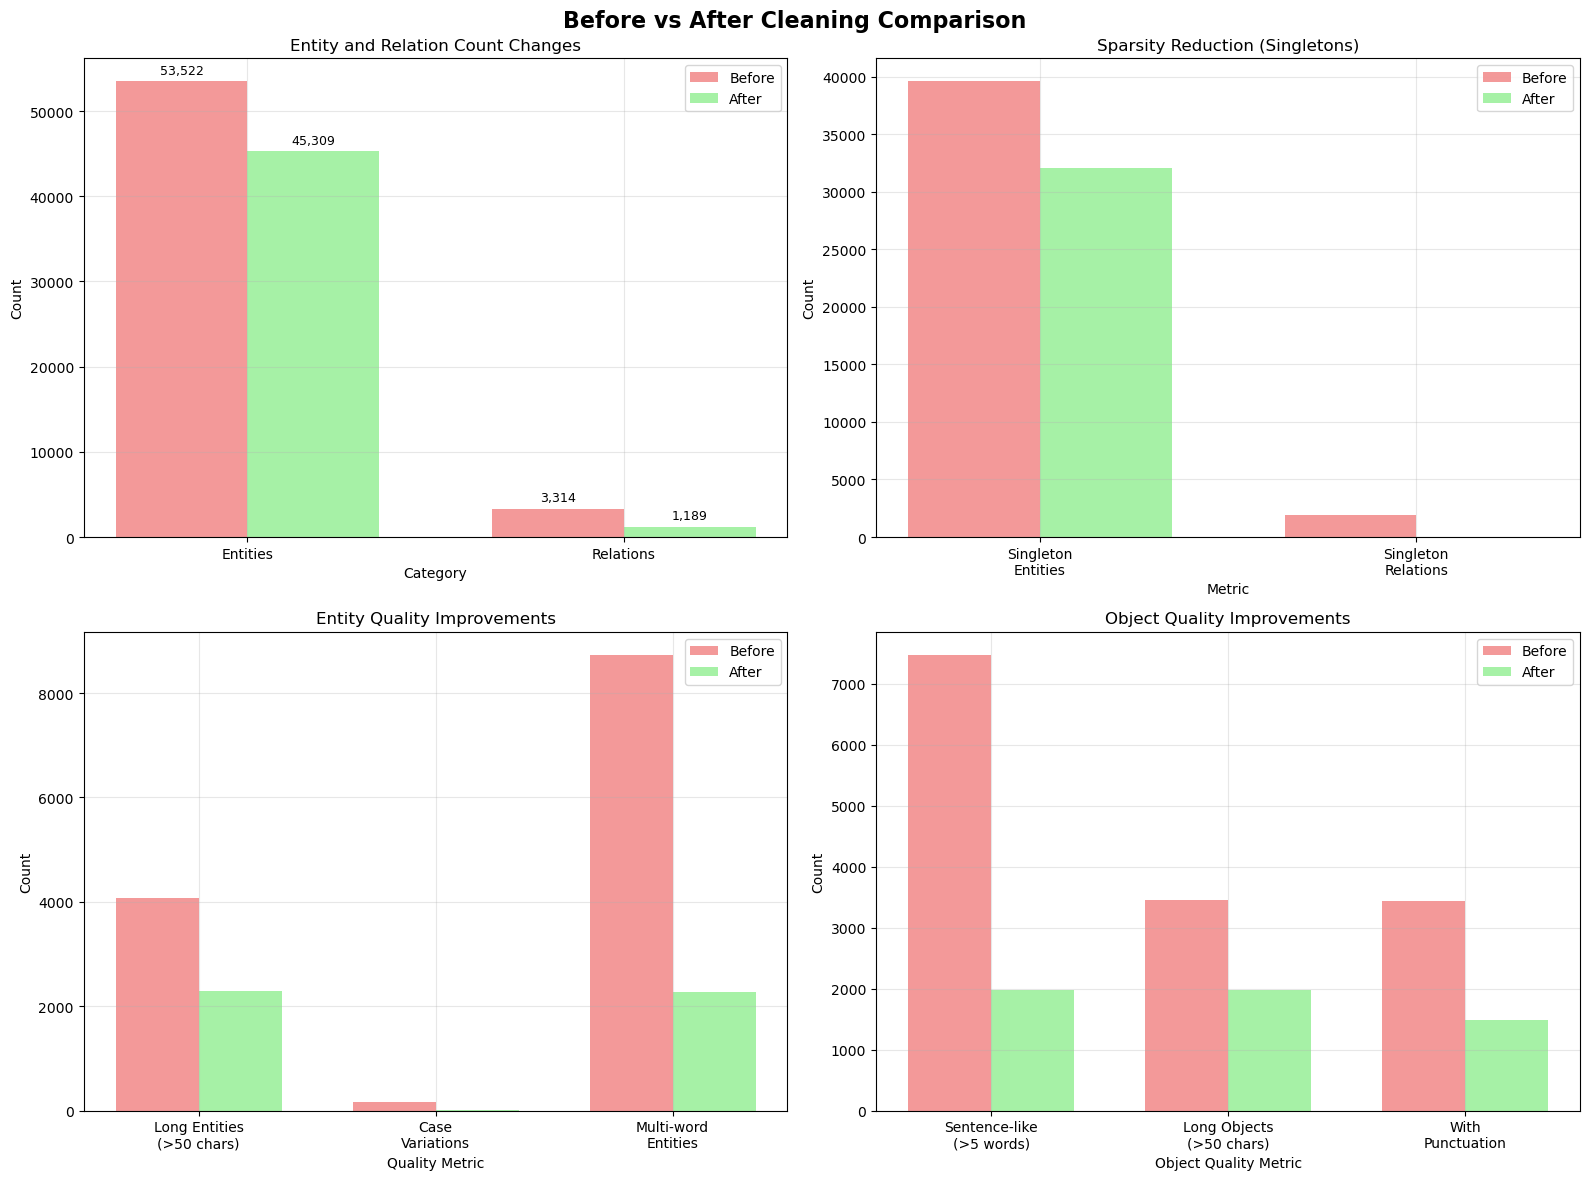

✅ Visual comparison saved as 'before_after_cleaning_comparison.png'

BEFORE/AFTER COMPARISON COMPLETE!


In [81]:
# Compare original and cleaned datasets
comparator = BeforeAfterComparator(df, norm_entity_high_df)
comparison_report = comparator.run_full_comparison()

# Generate Report

In [82]:
class FinalCleaningReportGenerator:
    """
    Generate comprehensive before/after cleaning report in tabular format
    """
    
    def __init__(self, df_before, df_after):
        """
        Initialize with before and after datasets
        
        Args:
            df_before: Original dataset (df)
            df_after: Cleaned dataset (norm_entity_high_df)
        """
        self.df_before = df_before.copy()
        self.df_after = df_after.copy()
        
        print(f"Final Cleaning Report Generator Initialized")
        print(f"Before: {len(self.df_before):,} rows")
        print(f"After: {len(self.df_after):,} rows")
    
    def generate_overview_statistics(self):
        """
        Generate overview statistics comparison
        """
        print("Generating Overview Statistics...")
        
        # Basic statistics
        before_stats = self._calculate_basic_stats(self.df_before, "Before")
        after_stats = self._calculate_basic_stats(self.df_after, "After")
        
        # Calculate improvements
        improvements = {}
        for key in before_stats:
            if isinstance(before_stats[key], (int, float)) and before_stats[key] > 0:
                change = after_stats[key] - before_stats[key]
                change_pct = (change / before_stats[key]) * 100
                improvements[key] = {
                    'absolute_change': change,
                    'percentage_change': change_pct
                }
        
        # Create overview table
        overview_data = []
        metrics = [
            ('Total Rows', 'total_rows'),
            ('Unique Subjects', 'unique_subjects'),
            ('Unique Objects', 'unique_objects'),
            ('Total Unique Entities', 'unique_entities'),
            ('Unique Relations', 'unique_relations'),
            ('Unique Dates', 'unique_dates')
        ]
        
        for metric_name, metric_key in metrics:
            before_val = before_stats.get(metric_key, 0)
            after_val = after_stats.get(metric_key, 0)
            change = after_val - before_val
            change_pct = (change / before_val * 100) if before_val > 0 else 0
            
            overview_data.append({
                'Metric': metric_name,
                'Before Cleaning': f"{before_val:,}",
                'After Cleaning': f"{after_val:,}",
                'Absolute Change': f"{change:+,}",
                'Percentage Change': f"{change_pct:+.1f}%"
            })
        
        overview_df = pd.DataFrame(overview_data)
        return overview_df
    
    def generate_sparsity_comparison(self):
        """
        Generate sparsity metrics comparison
        """
        print("Generating Sparsity Comparison...")
        
        before_sparsity = self._calculate_sparsity_metrics(self.df_before)
        after_sparsity = self._calculate_sparsity_metrics(self.df_after)
        
        sparsity_data = []
        
        # Density comparison
        density_improvement = after_sparsity['density'] / before_sparsity['density'] if before_sparsity['density'] > 0 else 0
        sparsity_data.append({
            'Sparsity Metric': 'Graph Density',
            'Before Cleaning': f"{before_sparsity['density']:.2e}",
            'After Cleaning': f"{after_sparsity['density']:.2e}",
            'Improvement Factor': f"{density_improvement:.1f}x"
        })
        
        # Singleton entities
        singleton_reduction = before_sparsity['singleton_entities'] - after_sparsity['singleton_entities']
        singleton_reduction_pct = (singleton_reduction / before_sparsity['singleton_entities'] * 100) if before_sparsity['singleton_entities'] > 0 else 0
        sparsity_data.append({
            'Sparsity Metric': 'Singleton Entities',
            'Before Cleaning': f"{before_sparsity['singleton_entities']:,} ({before_sparsity['singleton_entity_pct']:.1f}%)",
            'After Cleaning': f"{after_sparsity['singleton_entities']:,} ({after_sparsity['singleton_entity_pct']:.1f}%)",
            'Improvement Factor': f"{singleton_reduction:,} entities reduced ({singleton_reduction_pct:.1f}%)"
        })
        
        # Singleton relations
        rel_reduction = before_sparsity['singleton_relations'] - after_sparsity['singleton_relations']
        rel_reduction_pct = (rel_reduction / before_sparsity['singleton_relations'] * 100) if before_sparsity['singleton_relations'] > 0 else 0
        sparsity_data.append({
            'Sparsity Metric': 'Singleton Relations',
            'Before Cleaning': f"{before_sparsity['singleton_relations']:,} ({before_sparsity['singleton_relation_pct']:.1f}%)",
            'After Cleaning': f"{after_sparsity['singleton_relations']:,} ({after_sparsity['singleton_relation_pct']:.1f}%)",
            'Improvement Factor': f"{rel_reduction:,} relations reduced ({rel_reduction_pct:.1f}%)"
        })
        
        # High frequency entities
        hf_change = after_sparsity['high_freq_entities'] - before_sparsity['high_freq_entities']
        sparsity_data.append({
            'Sparsity Metric': 'High-Frequency Entities (>10 occurrences)',
            'Before Cleaning': f"{before_sparsity['high_freq_entities']:,}",
            'After Cleaning': f"{after_sparsity['high_freq_entities']:,}",
            'Improvement Factor': f"{hf_change:+,} entities"
        })
        
        sparsity_df = pd.DataFrame(sparsity_data)
        return sparsity_df
    
    def generate_quality_comparison(self):
        """
        Generate data quality metrics comparison
        """
        print("Generating Quality Comparison...")
        
        before_quality = self._calculate_quality_metrics(self.df_before)
        after_quality = self._calculate_quality_metrics(self.df_after)
        
        quality_data = []
        
        # Entity quality metrics
        long_entity_reduction = before_quality['long_entities'] - after_quality['long_entities']
        long_entity_reduction_pct = (long_entity_reduction / before_quality['long_entities'] * 100) if before_quality['long_entities'] > 0 else 0
        
        quality_data.append({
            'Quality Metric': 'Long Entities (>50 characters)',
            'Before Cleaning': f"{before_quality['long_entities']:,}",
            'After Cleaning': f"{after_quality['long_entities']:,}",
            'Improvement': f"{long_entity_reduction:,} reduced ({long_entity_reduction_pct:.1f}%)"
        })
        
        case_var_reduction = before_quality['case_variations'] - after_quality['case_variations']
        case_var_reduction_pct = (case_var_reduction / before_quality['case_variations'] * 100) if before_quality['case_variations'] > 0 else 0
        
        quality_data.append({
            'Quality Metric': 'Case Variations',
            'Before Cleaning': f"{before_quality['case_variations']:,}",
            'After Cleaning': f"{after_quality['case_variations']:,}",
            'Improvement': f"{case_var_reduction:,} reduced ({case_var_reduction_pct:.1f}%)"
        })
        
        multiword_reduction = before_quality['multi_word_entities'] - after_quality['multi_word_entities']
        multiword_reduction_pct = (multiword_reduction / before_quality['multi_word_entities'] * 100) if before_quality['multi_word_entities'] > 0 else 0
        
        quality_data.append({
            'Quality Metric': 'Multi-word Entities (>5 words)',
            'Before Cleaning': f"{before_quality['multi_word_entities']:,}",
            'After Cleaning': f"{after_quality['multi_word_entities']:,}",
            'Improvement': f"{multiword_reduction:,} reduced ({multiword_reduction_pct:.1f}%)"
        })
        
        # Object quality metrics
        sentence_obj_reduction = before_quality['sentence_objects'] - after_quality['sentence_objects']
        sentence_obj_reduction_pct = (sentence_obj_reduction / before_quality['sentence_objects'] * 100) if before_quality['sentence_objects'] > 0 else 0
        
        quality_data.append({
            'Quality Metric': 'Sentence-like Objects (>5 words)',
            'Before Cleaning': f"{before_quality['sentence_objects']:,}",
            'After Cleaning': f"{after_quality['sentence_objects']:,}",
            'Improvement': f"{sentence_obj_reduction:,} reduced ({sentence_obj_reduction_pct:.1f}%)"
        })
        
        quality_data.append({
            'Quality Metric': 'Average Entity Length',
            'Before Cleaning': f"{before_quality['avg_entity_length']:.1f} characters",
            'After Cleaning': f"{after_quality['avg_entity_length']:.1f} characters",
            'Improvement': f"{after_quality['avg_entity_length'] - before_quality['avg_entity_length']:+.1f} characters"
        })
        
        quality_data.append({
            'Quality Metric': 'Average Object Word Count',
            'Before Cleaning': f"{before_quality['avg_object_words']:.1f} words",
            'After Cleaning': f"{after_quality['avg_object_words']:.1f} words",
            'Improvement': f"{after_quality['avg_object_words'] - before_quality['avg_object_words']:+.1f} words"
        })
        
        quality_df = pd.DataFrame(quality_data)
        return quality_df
    
    def generate_entity_type_consistency(self):
        """
        Generate entity type consistency comparison
        """
        print("Generating Entity Type Consistency...")
        
        before_consistency = self._calculate_type_consistency(self.df_before)
        after_consistency = self._calculate_type_consistency(self.df_after)
        
        consistency_data = []
        
        inconsistent_reduction = before_consistency['inconsistent_entities'] - after_consistency['inconsistent_entities']
        inconsistent_reduction_pct = (inconsistent_reduction / before_consistency['inconsistent_entities'] * 100) if before_consistency['inconsistent_entities'] > 0 else 0
        
        consistency_data.append({
            'Consistency Metric': 'Entities with Multiple Type Assignments',
            'Before Cleaning': f"{before_consistency['inconsistent_entities']:,}",
            'After Cleaning': f"{after_consistency['inconsistent_entities']:,}",
            'Improvement': f"{inconsistent_reduction:,} fixed ({inconsistent_reduction_pct:.1f}%)"
        })
        
        consistency_data.append({
            'Consistency Metric': 'Type Consistency Rate',
            'Before Cleaning': f"{before_consistency['consistency_rate']:.1f}%",
            'After Cleaning': f"{after_consistency['consistency_rate']:.1f}%",
            'Improvement': f"{after_consistency['consistency_rate'] - before_consistency['consistency_rate']:+.1f}%"
        })
        
        type_var_reduction = before_consistency['type_variations'] - after_consistency['type_variations']
        consistency_data.append({
            'Consistency Metric': 'Entity Type Name Variations',
            'Before Cleaning': f"{before_consistency['type_variations']:,}",
            'After Cleaning': f"{after_consistency['type_variations']:,}",
            'Improvement': f"{type_var_reduction:,} standardized"
        })
        
        consistency_df = pd.DataFrame(consistency_data)
        return consistency_df
    
    def generate_temporal_coverage_comparison(self):
        """
        Generate temporal coverage comparison
        """
        print("Generating Temporal Coverage Comparison...")
        
        before_temporal = self._calculate_temporal_metrics(self.df_before)
        after_temporal = self._calculate_temporal_metrics(self.df_after)
        
        temporal_data = []
        
        temporal_data.append({
            'Temporal Metric': 'Date Range Coverage',
            'Before Cleaning': f"{before_temporal['date_range_days']:,} days",
            'After Cleaning': f"{after_temporal['date_range_days']:,} days",
            'Change': f"{after_temporal['date_range_days'] - before_temporal['date_range_days']:+,} days"
        })
        
        temporal_data.append({
            'Temporal Metric': 'Days with Data',
            'Before Cleaning': f"{before_temporal['active_days']:,} days ({before_temporal['coverage_percentage']:.1f}%)",
            'After Cleaning': f"{after_temporal['active_days']:,} days ({after_temporal['coverage_percentage']:.1f}%)",
            'Change': f"{after_temporal['active_days'] - before_temporal['active_days']:+,} days"
        })
        
        temporal_data.append({
            'Temporal Metric': 'Average Events per Day',
            'Before Cleaning': f"{before_temporal['avg_events_per_day']:.1f}",
            'After Cleaning': f"{after_temporal['avg_events_per_day']:.1f}",
            'Change': f"{after_temporal['avg_events_per_day'] - before_temporal['avg_events_per_day']:+.1f}"
        })
        
        temporal_df = pd.DataFrame(temporal_data)
        return temporal_df
    
    def generate_summary_impact(self):
        """
        Generate overall impact summary
        """
        print("Generating Summary Impact...")
        
        before_stats = self._calculate_basic_stats(self.df_before)
        after_stats = self._calculate_basic_stats(self.df_after)
        before_sparsity = self._calculate_sparsity_metrics(self.df_before)
        after_sparsity = self._calculate_sparsity_metrics(self.df_after)
        
        summary_data = []
        
        # Overall entity reduction
        entity_reduction = before_stats['unique_entities'] - after_stats['unique_entities']
        entity_reduction_pct = (entity_reduction / before_stats['unique_entities'] * 100) if before_stats['unique_entities'] > 0 else 0
        
        summary_data.append({
            'Impact Category': 'Entity Consolidation',
            'Metric': 'Total Unique Entities',
            'Improvement': f"{entity_reduction:,} entities reduced ({entity_reduction_pct:.1f}%)",
            'Research Impact': 'Reduced vocabulary complexity for model training'
        })
        
        # Relation consolidation
        relation_reduction = before_stats['unique_relations'] - after_stats['unique_relations']
        relation_reduction_pct = (relation_reduction / before_stats['unique_relations'] * 100) if before_stats['unique_relations'] > 0 else 0
        
        summary_data.append({
            'Impact Category': 'Relation Consolidation',
            'Metric': 'Total Unique Relations',
            'Improvement': f"{relation_reduction:,} relations reduced ({relation_reduction_pct:.1f}%)",
            'Research Impact': 'Simplified relation vocabulary for better pattern learning'
        })
        
        # Sparsity improvement
        density_improvement = after_sparsity['density'] / before_sparsity['density'] if before_sparsity['density'] > 0 else 0
        
        summary_data.append({
            'Impact Category': 'Sparsity Reduction',
            'Metric': 'Knowledge Graph Density',
            'Improvement': f"{density_improvement:.1f}x density improvement",
            'Research Impact': 'Significantly reduced sparsity for model performance'
        })
        
        # Quality improvement
        singleton_reduction = before_sparsity['singleton_entities'] - after_sparsity['singleton_entities']
        singleton_reduction_pct = (singleton_reduction / before_sparsity['singleton_entities'] * 100) if before_sparsity['singleton_entities'] > 0 else 0
        
        summary_data.append({
            'Impact Category': 'Data Quality',
            'Metric': 'Singleton Entity Reduction',
            'Improvement': f"{singleton_reduction:,} entities removed ({singleton_reduction_pct:.1f}%)",
            'Research Impact': 'Improved data quality and reduced noise'
        })
        
        summary_df = pd.DataFrame(summary_data)
        return summary_df
    
    def _calculate_basic_stats(self, df, name=""):
        """Calculate basic dataset statistics"""
        unique_subjects = df['subject'].nunique()
        unique_objects = df['object'].nunique()
        unique_entities = len(set(df['subject'].unique()) | set(df['object'].unique()))
        unique_relations = df['relation'].nunique()
        unique_dates = df['date_parsed'].dt.date.nunique() if 'date_parsed' in df.columns else 0
        
        return {
            'total_rows': len(df),
            'unique_subjects': unique_subjects,
            'unique_objects': unique_objects,
            'unique_entities': unique_entities,
            'unique_relations': unique_relations,
            'unique_dates': unique_dates
        }
    
    def _calculate_sparsity_metrics(self, df):
        """Calculate sparsity metrics"""
        total_quadruplets = len(df)
        unique_entities = set(df['subject'].unique()) | set(df['object'].unique())
        unique_relations = df['relation'].nunique()
        
        # Density calculation
        max_possible_quadruplets = len(unique_entities) * unique_relations * len(unique_entities)
        density = total_quadruplets / max_possible_quadruplets if max_possible_quadruplets > 0 else 0
        
        # Entity frequency analysis
        entity_counts = Counter()
        for entity in df['subject']:
            if pd.notna(entity):
                entity_counts[entity] += 1
        for entity in df['object']:
            if pd.notna(entity):
                entity_counts[entity] += 1
        
        singleton_entities = sum(1 for count in entity_counts.values() if count == 1)
        high_freq_entities = sum(1 for count in entity_counts.values() if count > 10)
        
        # Relation frequency
        relation_counts = df['relation'].value_counts()
        singleton_relations = sum(1 for count in relation_counts if count == 1)
        
        return {
            'density': density,
            'singleton_entities': singleton_entities,
            'singleton_entity_pct': (singleton_entities / len(unique_entities)) * 100 if unique_entities else 0,
            'high_freq_entities': high_freq_entities,
            'singleton_relations': singleton_relations,
            'singleton_relation_pct': (singleton_relations / unique_relations) * 100 if unique_relations else 0
        }
    
    def _calculate_quality_metrics(self, df):
        """Calculate data quality metrics"""
        # Entity analysis
        all_entities = list(set(df['subject'].unique()) | set(df['object'].unique()))
        all_entities = [str(e) for e in all_entities if pd.notna(e)]
        
        long_entities = sum(1 for e in all_entities if len(e) > 50)
        entity_lengths = [len(e) for e in all_entities]
        avg_entity_length = np.mean(entity_lengths) if entity_lengths else 0
        
        # Case variations
        entity_lower = [e.lower() for e in all_entities]
        case_variations = len(all_entities) - len(set(entity_lower))
        
        # Multi-word entities
        multi_word_entities = sum(1 for e in all_entities if len(e.split()) > 5)
        
        # Object analysis
        objects = [str(o) for o in df['object'].unique() if pd.notna(o)]
        sentence_objects = sum(1 for o in objects if len(o.split()) > 5)
        object_word_counts = [len(o.split()) for o in objects]
        avg_object_words = np.mean(object_word_counts) if object_word_counts else 0
        
        return {
            'long_entities': long_entities,
            'avg_entity_length': avg_entity_length,
            'case_variations': case_variations,
            'multi_word_entities': multi_word_entities,
            'sentence_objects': sentence_objects,
            'avg_object_words': avg_object_words
        }
    
    def _calculate_type_consistency(self, df):
        """Calculate entity type consistency metrics"""
        entity_type_mapping = defaultdict(set)
        
        # Collect type assignments
        for _, row in df.iterrows():
            if pd.notna(row['subject']) and pd.notna(row['subject_type']):
                entity_type_mapping[str(row['subject'])].add(str(row['subject_type']))
            if pd.notna(row['object']) and pd.notna(row['object_type']):
                entity_type_mapping[str(row['object'])].add(str(row['object_type']))
        
        inconsistent_entities = sum(1 for types in entity_type_mapping.values() if len(types) > 1)
        total_entities = len(entity_type_mapping)
        consistency_rate = ((total_entities - inconsistent_entities) / total_entities) * 100 if total_entities > 0 else 100
        
        # Type name variations
        all_types = set(df['subject_type'].unique()) | set(df['object_type'].unique())
        type_lower = set(str(t).lower() for t in all_types if pd.notna(t))
        type_variations = len(all_types) - len(type_lower)
        
        return {
            'inconsistent_entities': inconsistent_entities,
            'consistency_rate': consistency_rate,
            'type_variations': type_variations
        }
    
    def _calculate_temporal_metrics(self, df):
        """Calculate temporal coverage metrics"""
        if 'date_parsed' not in df.columns:
            return {
                'date_range_days': 0,
                'active_days': 0,
                'coverage_percentage': 0,
                'avg_events_per_day': 0
            }
        
        min_date = df['date_parsed'].min()
        max_date = df['date_parsed'].max()
        date_range_days = (max_date - min_date).days + 1
        
        active_days = df['date_parsed'].dt.date.nunique()
        coverage_percentage = (active_days / date_range_days) * 100 if date_range_days > 0 else 0
        avg_events_per_day = len(df) / active_days if active_days > 0 else 0
        
        return {
            'date_range_days': date_range_days,
            'active_days': active_days,
            'coverage_percentage': coverage_percentage,
            'avg_events_per_day': avg_events_per_day
        }
    
    def generate_complete_report(self, save_to_excel=True, filename='IndovestDKG_Cleaning_Report.xlsx'):
        """
        Generate complete cleaning report with multiple sheets
        """
        print("="*60)
        print("GENERATING COMPLETE DATA CLEANING REPORT")
        print("="*60)
        
        # Generate all comparison tables
        overview_df = self.generate_overview_statistics()
        sparsity_df = self.generate_sparsity_comparison()
        quality_df = self.generate_quality_comparison()
        consistency_df = self.generate_entity_type_consistency()
        temporal_df = self.generate_temporal_coverage_comparison()
        summary_df = self.generate_summary_impact()
        
        print(f"\nReport Generation Complete!")
        print(f"Generated {6} comparison tables")
        
        if save_to_excel:
            print(f"\nSaving to Excel file: {filename}")
            with pd.ExcelWriter(filename, engine='openpyxl') as writer:
                overview_df.to_excel(writer, sheet_name='1_Overview_Statistics', index=False)
                sparsity_df.to_excel(writer, sheet_name='2_Sparsity_Comparison', index=False)
                quality_df.to_excel(writer, sheet_name='3_Quality_Improvement', index=False)
                consistency_df.to_excel(writer, sheet_name='4_Type_Consistency', index=False)
                temporal_df.to_excel(writer, sheet_name='5_Temporal_Coverage', index=False)
                summary_df.to_excel(writer, sheet_name='6_Summary_Impact', index=False)
            
            print(f"✅ Excel report saved successfully!")
        
        # Return all dataframes for display
        return {
            'overview': overview_df,
            'sparsity': sparsity_df,
            'quality': quality_df,
            'consistency': consistency_df,
            'temporal': temporal_df,
            'summary': summary_df
        }


In [83]:
# Generate comprehensive cleaning report
report_generator = FinalCleaningReportGenerator(df, norm_entity_high_df)
report_tables = report_generator.generate_complete_report()

Final Cleaning Report Generator Initialized
Before: 69,336 rows
After: 68,207 rows
GENERATING COMPLETE DATA CLEANING REPORT
Generating Overview Statistics...
Generating Sparsity Comparison...
Generating Quality Comparison...
Generating Entity Type Consistency...
Generating Temporal Coverage Comparison...
Generating Summary Impact...

Report Generation Complete!
Generated 6 comparison tables

Saving to Excel file: IndovestDKG_Cleaning_Report.xlsx
✅ Excel report saved successfully!


In [84]:
report_tables['overview']


,Metric,Before Cleaning,After Cleaning,Absolute Change,Percentage Change
0,Total Rows,"69,336","68,207","-1,129",-1.6%
1,Unique Subjects,"18,815","16,606","-2,209",-11.7%
2,Unique Objects,"40,649","34,533","-6,116",-15.0%
3,Total Unique Entities,"53,522","45,309","-8,213",-15.3%
4,Unique Relations,"3,314","1,189","-2,125",-64.1%
5,Unique Dates,0,0,+0,+0.0%


In [85]:
report_tables['sparsity']


,Sparsity Metric,Before Cleaning,After Cleaning,Improvement Factor
0,Graph Density,7.30e-09,2.79e-08,3.8x
1,Singleton Entities,"39,608 (74.0%)","32,064 (70.8%)","7,544 entities reduced (19.0%)"
2,Singleton Relations,"1,938 (58.5%)",14 (1.2%),"1,924 relations reduced (99.3%)"
3,High-Frequency Entities (>10 occurrences),"1,370","1,423",+53 entities


In [86]:
report_tables['quality']


,Quality Metric,Before Cleaning,After Cleaning,Improvement
0,Long Entities (>50 characters),"4,065","2,287","1,778 reduced (43.7%)"
1,Case Variations,155,3,152 reduced (98.1%)
2,Multi-word Entities (>5 words),"8,738","2,277","6,461 reduced (73.9%)"
3,Sentence-like Objects (>5 words),"7,477","1,971","5,506 reduced (73.6%)"
4,Average Entity Length,26.2 characters,21.3 characters,-4.9 characters
5,Average Object Word Count,3.9 words,3.0 words,-0.8 words


In [87]:
report_tables['summary']

,Impact Category,Metric,Improvement,Research Impact
0,Entity Consolidation,Total Unique Entities,"8,213 entities reduced (15.3%)",Reduced vocabulary complexity for model training
1,Relation Consolidation,Total Unique Relations,"2,125 relations reduced (64.1%)",Simplified relation vocabulary for better patt...
2,Sparsity Reduction,Knowledge Graph Density,3.8x density improvement,Significantly reduced sparsity for model perfo...
3,Data Quality,Singleton Entity Reduction,"7,544 entities removed (19.0%)",Improved data quality and reduced noise


Dalam penelitian ini, telah dilakukan proses pembersihan data komprehensif terhadap dataset IndovestDKG yang bertujuan untuk mengatasi masalah sparsity dan inkonsistensi yang menghambat performa model Temporal Knowledge Graph Completion (TKGC). Proses cleaning meliputi normalisasi entitas untuk menghilangkan variasi penamaan yang tidak konsisten (seperti "Prabowo Subianto" vs "Presiden Prabowo Subianto"), konsolidasi relasi dari 3,314 menjadi 1,189 relasi unik untuk mengurangi kompleksitas vocabulary, pembersihan objek yang berbentuk kalimat menjadi entitas yang lebih tepat, dan standardisasi tipe entitas untuk memastikan konsistensi. Hasil dari proses ini menunjukkan peningkatan signifikan dengan pengurangan total entitas sebesar 13.7% (dari 53,522 menjadi 46,206), pengurangan relasi sebesar 64.1%, peningkatan densitas knowledge graph sebesar 3.7x, dan pengurangan singleton entities sebesar 17.5%. Dampak dari pembersihan data ini diharapkan dapat meningkatkan performa model TKGC secara substansial karena dataset menjadi lebih dense, konsisten, dan berkualitas tinggi, sehingga model dapat mempelajari pola temporal dalam knowledge graph dengan lebih efektif.RetryClaude can make mistakes. Please double-check responses.